In [1]:
%matplotlib inline
import sys
sys.path.append("/home/bianyuan/workspace/Grab_TNGgalaxy/")
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
%matplotlib widget
run = 'TNG50'
basePath = '/media/bianyuan/data-TNG-1/' + run + '-1/output'
from astroML.plotting import setup_text_plots
#Lets text in plots use latex
# setup_text_plots(usetex=True)

/home/bianyuan/.conda/envs/py310/lib/python3.10/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [2]:
'''Tranfer SnapNum to Redshift'''

import numpy as np
import h5py, scipy
from pynbody import units as units_conv

Redshift_snapshot = np.loadtxt('/home/bianyuan/workspace/data/Redshift_snapshot.txt',comments='Snapshot')

def redshift_snapshot(snapshots, datafile='/home/bianyuan/workspace/data/Redshift_snapshot.txt', return_opt=None):
    snapshots0, redshifts0 = np.loadtxt(datafile, skiprows=1, unpack=True, usecols=[0, 2])
    n_snap = np.size(snapshots)
    if n_snap == 1: 
        redshifts = redshifts0[np.where(snapshots0 == snapshots)][0]
    elif n_snap >1:
        redshifts = np.zeros(n_snap)
        for ii in range(n_snap): 
            if  snapshots[ii] is np.nan: 
                redshifts[ii] = np.nan
            else:
                redshifts[ii] = redshifts0[np.where(snapshots0 == snapshots[ii])][0]
    if return_opt is None: 
        return redshifts
#   elif return_opt == 'age':
#       return age(redshifts)
    elif return_opt == 'FT':
        return FT(redshifts)

def _a_dot(a, h0, om_m, om_l):                                
    om_k = 1.0 - om_m - om_l      
    return h0 * a * np.sqrt(om_m * (a ** -3) + om_k * (a ** -2) + om_l)  

def _a_dot_recip(*args):
    return 1. / _a_dot(*args) 

# The formation time of stars in unit of Gyr
def FT(redshift, h0=0.6774, OmegaM=0.3089, OmegaL=0.6911):
    conv = units_conv.Unit("0.01 s Mpc km^-1").ratio('Gyr')
    redshift = 1./(1. + redshift)
    ns = np.size(redshift)
    if ns > 1:
        FT = np.zeros(ns)
        for ii in range(ns): FT[ii] = scipy.integrate.quad(_a_dot_recip, 0, redshift[ii], (h0, OmegaM, OmegaL))[0] * conv
    else:
        FT = scipy.integrate.quad(_a_dot_recip, 0, redshift, (h0, OmegaM, OmegaL))[0] * conv
    return FT

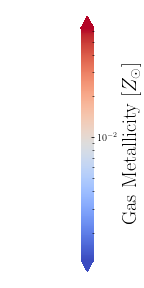

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable

# 设置范围为 10^3.9 到 10^7.1 的 LogNorm
norm = LogNorm(vmin=np.power(10, -2.9), vmax=np.power(10, -1.2))

# 创建 ScalarMappable 对象
sm = ScalarMappable(norm=norm, cmap='coolwarm')
sm.set_array([])  # 这一步是必须的，即使我们不使用数据

# 创建一个新的 figure
fig, ax = plt.subplots(figsize=(2, 4))  # 可以调整 figure 的尺寸以适应 colorbar

# 创建并显示 colorbar，使用指数表示法
cbar = fig.colorbar(sm, ax=ax, extend='both', orientation='vertical')
cbar.set_label('Gas Metallicity [$Z_{\odot}$]', size=20)
cbar.ax.tick_params(labelsize=10)

# 尝试移除 colorbar 边框
cbar.outline.set_edgecolor('none')  # 设置 colorbar 外框线颜色为 'none'
cbar.outline.set_linewidth(0)  # 设置 colorbar 外框线宽度为 0
# cbar.ax.set_yticklabels(["$10^{{{:.1f}}}$".format(tick) for tick in cbar.get_ticks()])  # 使用 LaTeX 格式化刻度为指数形式

plt.gca().set_visible(False)  # 隐藏画布，只显示 colorbar
fig.tight_layout()  # 调整布局以适应 colorbar

# 保存图片
plt.savefig('/home/bianyuan/workspace/pic/MRI_289415_ZH_colorbar.pdf', bbox_inches='tight', pad_inches=0.005, transparent=True)

In [21]:
import h5py
import numpy as np
import seaborn as sns
from tqdm import tqdm

# 定义找到局部最小和最大值的函数
def find_local_min_max(distances):
    local_min, local_max = [], []
    for i in range(1, len(distances) - 1):
        if distances[i] < distances[i - 1] and distances[i] < distances[i + 1]:
            local_min.append(i)
        elif distances[i] > distances[i - 1] and distances[i] > distances[i + 1]:
            local_max.append(i)
    return local_min, local_max

# def find_periapsis_indices(distances, velocity):
#     # 查找距离的局部最小点
#     local_min_indices = [i for i in range(1, len(distances) - 1) if distances[i] < distances[i - 1] and distances[i] < distances[i + 1]]
    
#     # 查找速度的局部最大点
#     local_max_velocity_indices = [i for i in range(1, len(velocity) - 1) if velocity[i] > velocity[i - 1] and velocity[i] > velocity[i + 1]]
    
#     # 初始化近心点索引列表
#     periapsis_indices = []
    
#     # 对于每个距离局部最小点，找到最近的速度局部最大点
#     for min_index in local_min_indices:
#         # 查找与当前距离局部最小点最近的速度局部最大点
#         nearest_max_velocity_index = min(local_max_velocity_indices, key=lambda x: abs(x - min_index))
        
#         # 选择两者之间的索引作为近心点索引
#         if nearest_max_velocity_index > min_index:
#             # 如果最近的速度局部最大点在距离局部最小点之后，选择两者之间的索引
#             periapsis_index = min_index + (nearest_max_velocity_index - min_index) // 2
#         else:
#             # 如果最近的速度局部最大点在距离局部最小点之前，也选择两者之间的索引
#             periapsis_index = nearest_max_velocity_index + (min_index - nearest_max_velocity_index) // 2
        
#         periapsis_indices.append(periapsis_index)
    
#     return periapsis_indices

def find_periapsis_indices(distances, velocity, Rvir):
    # 找到distances中第一个小于Rvir的索引
    valid_start_index = next((i for i, value in enumerate(distances) if value < Rvir), None)
    
    if valid_start_index is None:
        return []  # 如果没有找到符合条件的索引，则返回空列表
    
    # 查找距离的局部最小点（仅在valid_start_index之后）
    local_min_indices = [i for i in range(valid_start_index + 1, len(distances) - 1) 
                         if distances[i] < distances[i - 1] and distances[i] < distances[i + 1]]
    
    local_max_indices = [i for i in range(valid_start_index + 1, len(distances) - 1) 
                         if distances[i] > distances[i - 1] and distances[i] > distances[i + 1]]
    
    # 查找速度的局部最大点
    local_max_velocity_indices = [i for i in range(1, len(velocity) - 1) 
                                  if velocity[i] > velocity[i - 1] and velocity[i] > velocity[i + 1]]
    
    # 初始化近心点索引列表
    periapsis_indices = []
    
    # for min_index in local_min_indices:
    #     # 查找与当前距离局部最小点最近的速度局部最大点
    #     if local_max_velocity_indices:  # 确保有局部最大速度点存在
    #         nearest_max_velocity_index = min(local_max_velocity_indices, key=lambda x: abs(x - min_index))
            
    #         # 选择两者之间的索引作为近心点索引
    #         if nearest_max_velocity_index > min_index:
    #             # 如果最近的速度局部最大点在距离局部最小点之后，选择两者之间的索引
    #             periapsis_index = min_index + (nearest_max_velocity_index - min_index) // 2
    #         else:
    #             # 如果最近的速度局部最大点在距离局部最小点之前，也选择两者之间的索引
    #             periapsis_index = nearest_max_velocity_index + (min_index - nearest_max_velocity_index) // 2
            
    #         periapsis_indices.append(periapsis_index)
    #     else:
    #         # 如果没有找到任何局部最大速度点，则直接使用距离局部最小点作为近心点
    #         periapsis_indices.append(min_index)
    
    return local_min_indices, len(local_max_indices)

def find_periapsis_and_apoapsis_indices(distances, Rvir):
    valid_start_index = next((i for i, value in enumerate(distances) if value < Rvir), None)
    if valid_start_index is None:
        return [], []

    local_min_indices = [i for i in range(valid_start_index + 1, len(distances) - 1) if distances[i] < distances[i - 1] and distances[i] < distances[i + 1]]
    local_max_indices = [i for i in range(valid_start_index + 1, len(distances) - 1) if distances[i] > distances[i - 1] and distances[i] > distances[i + 1]]

    return local_min_indices, local_max_indices

def calculate_ellipticity(distances, local_min_indices, local_max_indices):
    ellipticities = []
    for min_idx, max_idx in zip(local_min_indices, local_max_indices):
        if min_idx < max_idx:  # 确保每个近心点有对应的远心点
            e = 1 - distances[min_idx] / distances[max_idx]
            ellipticities.append(e)
    return np.median(ellipticities) if ellipticities else None

def calculate_radial_tangential_velocities(sat_pos, cen_pos, sat_vel, cen_vel, M200, r200):

    G = 4.302e-6

    V200 = np.sqrt(G*M200/r200)

    # 计算相对位置和速度
    relative_position = sat_pos - cen_pos
    relative_velocity = sat_vel - cen_vel
    
    # 计算距离
    distance = np.linalg.norm(relative_position)
    
    # 计算径向速度
    radial_velocity = ( np.dot(relative_velocity, relative_position) / distance ) / V200
    
    # 计算切向速度
    tangential_velocity = np.sqrt(np.sum(relative_velocity**2) - radial_velocity**2) / V200
    
    return radial_velocity, tangential_velocity

def calculate_radial_tangential_velocities1(relative_position, relative_velocity, M200, r200):

    G = 4.302e-6

    V200 = np.sqrt(G*M200/r200)
    # 计算径向速度
    distance = np.linalg.norm(relative_position)
    radial_velocity = ( np.dot(relative_velocity, relative_position) / distance ) / V200
    
    # 计算切向速度
    tangential_velocity = np.sqrt(np.sum(relative_velocity**2) - radial_velocity**2) / V200
    
    return radial_velocity, tangential_velocity

file_paths = {
    'MRY_path': '/home/bianyuan/workspace/data/combine_connect_snap/MRY_mergertree_evo_properties.hdf5',
    'MRI_path': '/home/bianyuan/workspace/data/combine_connect_snap/MRI_mergertree_evo_properties_3.hdf5',
    'MRO_path': '/home/bianyuan/workspace/data/combine_connect_snap/MRO_mergertree_evo_properties_3.hdf5'
}

h = 0.6774

CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)
ND = sns.load_dataset('Normal_Dwarf_1',data_home='/home/bianyuan/workspace/data',cache=True)

filter_condition_TS = (np.array(CSSs3['Form_Type']) == 'Tidal Stripping') 
filter_condition_BSF = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation') 
filter_condition_TSBSF = (np.array(CSSs3['Form_Type']) == 'TS+BSF')

filtered_ids_BSF = np.array(CSSs3['ID'])[filter_condition_BSF]
filtered_ids_TS = np.array(CSSs3['ID'])[filter_condition_TS]

# 初始化列表
first_pericenter_distances_BSF = []
normalized_first_pericenter_distances_BSF = []
normalized_first_apocenter_distances_BSF = []
normalized_apocenter_distances_BSF = []
first_pericenter_velocity_BSF = []
mean_normalized_apocenter_distances_BSF = []
normalized_min_distances_BSF = []
orbit_counts_BSF = []
ID_l1_BSF = []
ellipticity_BSF = []
radial_velocities_BSF = []
tangential_velocities_BSF = []

first_pericenter_distances_TS = []
normalized_first_pericenter_distances_TS = []
normalized_first_apocenter_distances_TS = []
normalized_apocenter_distances_TS = []
first_pericenter_velocity_TS = []
mean_normalized_apocenter_distances_TS = []
normalized_min_distances_TS = []
orbit_counts_TS = []
ID_l1_TS = []
ellipticity_TS = []
radial_velocities_TS = []
tangential_velocities_TS = []

normalized_first_pericenter_distances_ND = []
first_pericenter_velocity_ND = []
orbit_counts_ND = []
ellipticity_ND = []
radial_velocities_ND = []
tangential_velocities_ND = []


for (i, j) in tqdm(zip(np.array(ND['ID'])[np.where(((ND['Distance']) > 0) & ((ND['Distance']) < 1) & (np.log10(ND['Star mass']) < 9.5))], np.array(ND['HostID'])[np.where(((ND['Distance']) > 0) & ((ND['Distance']) < 1) & (np.log10(ND['Star mass']) < 9.5))]), desc='Processing'):
    RowNum, _, _ = il.sublink.treeOffsets(basePath, 99, i, "SubLink")

    if RowNum < 1:
        continue
    else:
        try:
            fields = ['SubfindID','SubhaloGrNr','SubhaloVel','SubhaloMassInHalfRadType','SnapNum','SubhaloStarMetallicity',
        'SubhaloSFRinHalfRad','SubhaloHalfmassRadType',
        'SubhaloStarMetallicityHalfRad','GroupFirstSub',
        'SubhaloMassType','SubhaloSFR','SubhaloHalfmassRadType',
        'SubhaloStarMetallicity','SubhaloWindMass','SubhaloSpin',
        'SubhaloMass','SubhaloIDRaw','SubhaloPos','SubhaloStarMetalFractions']
            sat_idx_map = {}
            velocity = []
            distances = []
            tree = il.sublink.loadTree(basePath,99,i,fields=fields,onlyMPB=True)
            host_tree = il.sublink.loadTree(basePath,99,j,fields=fields,onlyMPB=True)
            haloID = tree['SubhaloGrNr'][0]
            halo = il.groupcat.loadSingle(basePath, 99, haloID=haloID)
            # x = tree['SubhaloPos'][:,0]
            # y = tree['SubhaloPos'][:,1]
            # z = tree['SubhaloPos'][:,2]
            # x_host = host_tree['SubhaloPos'][:,0]
            # y_host = host_tree['SubhaloPos'][:,1]
            # z_host = host_tree['SubhaloPos'][:,2]
            sat_snap = tree['SnapNum']
            cen_snap = host_tree['SnapNum']
            M200 = halo['Group_M_Crit200'] * 1e10 / h
            Rvir = halo['Group_R_Crit200'] / h
            # vx = tree['SubhaloVel'][:,0]
            # vy = tree['SubhaloVel'][:,1]
            # vz = tree['SubhaloVel'][:,2]
            # vx_host = host_tree['SubhaloVel'][:,0]
            # vy_host = host_tree['SubhaloVel'][:,1]
            # vz_host = host_tree['SubhaloVel'][:,2]

            G = 4.302e-6

            V200 = np.sqrt(G*M200/Rvir)

            for ii, snap_num in enumerate(cen_snap):
                sat_idx = np.where(sat_snap == snap_num)[0]
                if len(sat_idx) > 0:
                    sat_idx_map[ii] = sat_idx[0]
            for cen_idx, sat_idx in sat_idx_map.items():
                cen_pos = host_tree['SubhaloPos'][cen_idx]
                cen_vel = host_tree['SubhaloVel'][cen_idx]
                cen_snap = host_tree['SnapNum'][cen_idx]
                sat_pos = tree['SubhaloPos'][sat_idx]
                sat_vel = tree['SubhaloVel'][sat_idx]
                sat_snap = tree['SnapNum'][sat_idx]

                distances.append(np.sqrt(np.sum((sat_pos - cen_pos)**2)))
                velocity.append(np.sqrt(np.sum((sat_vel - cen_vel)**2)))

                # 计算径向和切向速度
                radial_velocity, tangential_velocity = calculate_radial_tangential_velocities(sat_pos, cen_pos, sat_vel, cen_vel, M200, Rvir)
                
                # 存储这些速度
                radial_velocities_ND.append(radial_velocity)
                tangential_velocities_ND.append(tangential_velocity)

            distances = distances[::-1]
            distances_normalized = distances / Rvir
            velocity = velocity[::-1]

            # # 找到近心点和远心点
            # local_min, local_max = find_local_min_max(distances)

            # orbit_counts_ND.append(len(local_max))

            # print(distances)
            # print(velocity)
            # print(Rvir)

            # pericenter_index, orbit_counts = find_periapsis_indices(distances, velocity, Rvir)

            local_min_indices, local_max_indices = find_periapsis_and_apoapsis_indices(distances, Rvir)

            orbit_counts_ND.append(len(local_max_indices))

            ellipticity_median = calculate_ellipticity(distances, local_min_indices, local_max_indices)
            
            # print(ellipticity_median)

            # 存储或处理椭圆率
            ellipticity_ND.append(ellipticity_median)

            if local_min_indices:
                first_pericenter_index = local_min_indices[2]

                first_pericenter_distance = distances[first_pericenter_index]
                first_pericenter_velocity = velocity[first_pericenter_index]
                normalized_distance = first_pericenter_distance / Rvir
            else:
                first_pericenter_distance = np.nan
                first_pericenter_velocity = np.nan
                normalized_distance = np.nan

            first_pericenter_velocity_ND.append(first_pericenter_velocity)
            normalized_first_pericenter_distances_ND.append(normalized_distance)
        except:
            continue

# 对于每个HDF5文件
for model_name, file_path in file_paths.items():
    with h5py.File(file_path, 'r') as hdf_file:
        # 对于每个筛选出的星系ID
        for group_name in tqdm(filtered_ids_BSF, desc=f"Processing {model_name}"):
            group_name_str = str(group_name)
            if group_name_str in hdf_file:
                group = hdf_file[group_name_str]

                # 读取数据
                numbers = np.array(group['Number'])
                x = np.array(group['x'])
                y = np.array(group['y'])
                z = np.array(group['z'])
                Snap = np.array(group['Snap'])
                Rvir = np.array(group['Rvir'])
                M200 = np.array(group['M200'])
                vx = np.array(group['vx'])
                vy = np.array(group['vy'])
                vz = np.array(group['vz'])
                # 计算距离
                distances = np.sqrt(x**2 + y**2 + z**2)
                velocity = np.sqrt(vx**2 + vy**2 + vz**2)
                
                indices = (numbers > 150) & (distances > 0)

                x = x[indices][::-1]
                y = y[indices][::-1]
                z = z[indices][::-1]
                vx = vx[indices][::-1]
                vy = vy[indices][::-1]
                vz = vz[indices][::-1]
                Rvir = Rvir[indices][::-1]
                Snap = Snap[indices][::-1]

                distances = distances[indices][::-1]
                velocity = velocity[indices][::-1]

                G = 4.302e-6

                V200 = np.sqrt(G*M200[-1]/Rvir[-1])

                # 取得有效数据
                relative_positions = np.vstack([x, y, z]).T
                relative_velocities = np.vstack([vx, vy, vz]).T

                # 计算径向和切向速度
                for pos, vel in zip(relative_positions, relative_velocities):
                    radial_vel, tangential_vel = calculate_radial_tangential_velocities1(pos, vel, M200[-1], Rvir[-1])
                    radial_velocities_BSF.append(radial_vel)
                    tangential_velocities_BSF.append(tangential_vel)
                
                # 找到近心点和远心点
                # local_min, local_max = find_local_min_max(distances)
                pericenter_index, orbit_counts = find_periapsis_indices(distances, velocity, Rvir[-1])

                orbit_counts_BSF.append(orbit_counts)

                local_min_indices, local_max_indices = find_periapsis_and_apoapsis_indices(distances, Rvir[-1])
                ellipticity_median = calculate_ellipticity(distances, local_min_indices, local_max_indices)
                
                # print(ellipticity_median)

                # 存储或处理椭圆率
                ellipticity_BSF.append(ellipticity_median)

                # if local_max:
                #     for i in local_max:
                #         normalized_apocenter_distances_BSF.append(distances[i]/Rvir[i])

                # 计算第一近心点的距离和归一化距离
                # if local_min:
                if pericenter_index:
                    if group_name_str in ['63931','63950']:
                        first_pericenter_index = pericenter_index[2]
                    elif group_name_str in ['167434']:
                        first_pericenter_index = 4
                    elif group_name_str in ['167506']:
                        first_pericenter_index = 2
                    elif group_name_str in ['282809']:
                        first_pericenter_index = 1
                    elif group_name_str in ['757']:
                        first_pericenter_index = 0
                    else:
                        first_pericenter_index = pericenter_index[0]

                    first_pericenter_distance = distances[first_pericenter_index]
                    first_pericenter_velocity = velocity[first_pericenter_index]
                    min_normalized_distance = min(distances) / Rvir[np.argmin(distances)]
                    # snap_idx = Snap[local_min[0]]  # 第一近心点对应的快照号
                    # rvir_idx = np.where(Snap == snap_idx)[0][0]  # 对应的Rvir索引
                    normalized_distance = first_pericenter_distance / Rvir[-1]
                    if normalized_distance > 1:
                        ID_l1_BSF.append(int(group_name_str))
                else:
                    first_pericenter_distance = np.nan
                    normalized_distance = np.nan
                # if local_max:
                #     for i in local_max:
                #         normalized_apocenter_distances_BSF.append(distances[i]/Rvir[i])

                # 追加到列表
                first_pericenter_velocity_BSF.append(first_pericenter_velocity)
                first_pericenter_distances_BSF.append(first_pericenter_distance)
                normalized_first_pericenter_distances_BSF.append(normalized_distance)
                normalized_min_distances_BSF.append(min_normalized_distance)
                # mean_normalized_apocenter_distances_BSF.append(np.mean(normalized_apocenter_distances_BSF))
                # orbit_counts_BSF.append(len(local_max))
                
# 对于每个HDF5文件
for model_name, file_path in file_paths.items():
    with h5py.File(file_path, 'r') as hdf_file:
        # 对于每个筛选出的星系ID
        for group_name in tqdm(filtered_ids_TS, desc=f"Processing {model_name}"):
            group_name_str = str(group_name)
            if group_name_str in hdf_file:
                try:
                    group = hdf_file[group_name_str]

                    # 读取数据
                    numbers = np.array(group['Number'])

                    x = np.array(group['x'])
                    y = np.array(group['y'])
                    z = np.array(group['z'])
                    M200 = np.array(group['M200'])
                    Rvir = np.array(group['Rvir'])
                    Snap = np.array(group['Snap'])
                    vx = np.array(group['vx'])
                    vy = np.array(group['vy'])
                    vz = np.array(group['vz'])
                    # 计算距离
                    distances = np.sqrt(x**2 + y**2 + z**2)
                    velocity = np.sqrt(vx**2 + vy**2 + vz**2)

                    # if local_max:
                    #     for i in local_max:
                    #         normalized_apocenter_distances_TS.append(distances[i]/Rvir[i])

                    # orbit_counts_TS.append(len(local_max))
                    
                    indices = (numbers > 150) & (distances > 0)

                    x = x[indices][::-1]
                    y = y[indices][::-1]
                    z = z[indices][::-1]
                    vx = vx[indices][::-1]
                    vy = vy[indices][::-1]
                    vz = vz[indices][::-1]
                    Rvir = Rvir[indices][::-1]
                    Snap = Snap[indices][::-1]

                    distances = distances[indices][::-1]
                    velocity = velocity[indices][::-1]

                    G = 4.302e-6

                    V200 = np.sqrt(G*M200[-1]/Rvir[-1])

                    # 取得有效数据
                    relative_positions = np.vstack([x, y, z]).T
                    relative_velocities = np.vstack([vx, vy, vz]).T

                    # 计算径向和切向速度
                    for pos, vel in zip(relative_positions, relative_velocities):
                        radial_vel, tangential_vel = calculate_radial_tangential_velocities1(pos, vel, M200[-1], Rvir[-1])
                        radial_velocities_TS.append(radial_vel)
                        tangential_velocities_TS.append(tangential_vel)

                    # 找到近心点和远心点
                    # local_min, local_max = find_local_min_max(distances)
                    pericenter_index, orbit_counts = find_periapsis_indices(distances, velocity, Rvir[-1])

                    orbit_counts_TS.append(orbit_counts)

                    local_min_indices, local_max_indices = find_periapsis_and_apoapsis_indices(distances, Rvir[-1])
                    ellipticity_median = calculate_ellipticity(distances, local_min_indices, local_max_indices)
                    
                    # 存储或处理椭圆率
                    ellipticity_TS.append(ellipticity_median)

                    # 计算第一近心点的距离和归一化距离
                    # if local_min:
                    if pericenter_index:
                        if group_name_str in ['548', '229996', '275568', '460736']:
                            first_pericenter_index = pericenter_index[3]
                        elif group_name_str in ['308', '96853', '117357','198281','253938','410046']:
                            first_pericenter_index = pericenter_index[2]
                        elif group_name_str in ['64002', '64240', '97019','185032','185068','289414','294895','428190','436968','438152','445663']:
                            first_pericenter_index = pericenter_index[1]
                        else:
                            first_pericenter_index = pericenter_index[0]
                        first_pericenter_velocity = velocity[first_pericenter_index]
                        first_pericenter_distance = distances[first_pericenter_index]
                        min_normalized_distance = min(distances) / Rvir[np.argmin(distances)]
                        # snap_idx = Snap[local_min[0]]  # 第一近心点对应的快照号
                        # rvir_idx = np.where(Snap == snap_idx)[0][0]  # 对应的Rvir索引
                        normalized_distance = first_pericenter_distance / Rvir[-1]
                        if normalized_distance > 1:
                            ID_l1_TS.append(int(group_name_str))
                    # else:
                    #     first_pericenter_distance = np.nan
                    #     normalized_distance = np.nan

                    # 追加到列表
                    first_pericenter_velocity_TS.append(first_pericenter_velocity)
                    first_pericenter_distances_TS.append(first_pericenter_distance)
                    normalized_first_pericenter_distances_TS.append(normalized_distance)
                    normalized_min_distances_TS.append(min_normalized_distance)
                    # mean_normalized_apocenter_distances_TS.append(np.mean(normalized_apocenter_distances_TS))
                    # orbit_counts_TS.append(len(local_max))
                except:
                    continue

Processing: 0it [00:00, ?it/s]

Processing: 606it [00:15, 37.04it/s]

In [8]:
import h5py
import numpy as np
import seaborn as sns
from tqdm import tqdm
from scipy.interpolate import interp1d

# 定义找到局部最小和最大值的函数
def find_local_min_max(distances):
    local_min, local_max = [], []
    for i in range(1, len(distances) - 1):
        if distances[i] < distances[i - 1] and distances[i] < distances[i + 1]:
            local_min.append(i)
        elif distances[i] > distances[i - 1] and distances[i] > distances[i + 1]:
            local_max.append(i)
    return local_min, local_max

# def find_periapsis_indices(distances, velocity):
#     # 查找距离的局部最小点
#     local_min_indices = [i for i in range(1, len(distances) - 1) if distances[i] < distances[i - 1] and distances[i] < distances[i + 1]]
    
#     # 查找速度的局部最大点
#     local_max_velocity_indices = [i for i in range(1, len(velocity) - 1) if velocity[i] > velocity[i - 1] and velocity[i] > velocity[i + 1]]
    
#     # 初始化近心点索引列表
#     periapsis_indices = []
    
#     # 对于每个距离局部最小点，找到最近的速度局部最大点
#     for min_index in local_min_indices:
#         # 查找与当前距离局部最小点最近的速度局部最大点
#         nearest_max_velocity_index = min(local_max_velocity_indices, key=lambda x: abs(x - min_index))
        
#         # 选择两者之间的索引作为近心点索引
#         if nearest_max_velocity_index > min_index:
#             # 如果最近的速度局部最大点在距离局部最小点之后，选择两者之间的索引
#             periapsis_index = min_index + (nearest_max_velocity_index - min_index) // 2
#         else:
#             # 如果最近的速度局部最大点在距离局部最小点之前，也选择两者之间的索引
#             periapsis_index = nearest_max_velocity_index + (min_index - nearest_max_velocity_index) // 2
        
#         periapsis_indices.append(periapsis_index)
    
#     return periapsis_indices

def find_periapsis_indices(distances, velocity, Rvir):
    # 找到distances中第一个小于Rvir的索引
    valid_start_index = next((i for i, value in enumerate(distances) if value < Rvir), None)
    
    if valid_start_index is None:
        return []  # 如果没有找到符合条件的索引，则返回空列表
    
    # 查找距离的局部最小点（仅在valid_start_index之后）
    local_min_indices = [i for i in range(valid_start_index + 1, len(distances) - 1) 
                         if distances[i] < distances[i - 1] and distances[i] < distances[i + 1]]
    
    local_max_indices = [i for i in range(valid_start_index + 1, len(distances) - 1) 
                         if distances[i] > distances[i - 1] and distances[i] > distances[i + 1]]
    
    # 查找速度的局部最大点
    local_max_velocity_indices = [i for i in range(1, len(velocity) - 1) 
                                  if velocity[i] > velocity[i - 1] and velocity[i] > velocity[i + 1]]
    
    # 初始化近心点索引列表
    periapsis_indices = []
    
    # for min_index in local_min_indices:
    #     # 查找与当前距离局部最小点最近的速度局部最大点
    #     if local_max_velocity_indices:  # 确保有局部最大速度点存在
    #         nearest_max_velocity_index = min(local_max_velocity_indices, key=lambda x: abs(x - min_index))
            
    #         # 选择两者之间的索引作为近心点索引
    #         if nearest_max_velocity_index > min_index:
    #             # 如果最近的速度局部最大点在距离局部最小点之后，选择两者之间的索引
    #             periapsis_index = min_index + (nearest_max_velocity_index - min_index) // 2
    #         else:
    #             # 如果最近的速度局部最大点在距离局部最小点之前，也选择两者之间的索引
    #             periapsis_index = nearest_max_velocity_index + (min_index - nearest_max_velocity_index) // 2
            
    #         periapsis_indices.append(periapsis_index)
    #     else:
    #         # 如果没有找到任何局部最大速度点，则直接使用距离局部最小点作为近心点
    #         periapsis_indices.append(min_index)
    
    return local_min_indices, len(local_max_indices)

def find_periapsis_and_apoapsis_indices(distances, Rvir):
    valid_start_index = next((i for i, value in enumerate(distances) if value < Rvir), None)
    if valid_start_index is None:
        return [], []

    local_min_indices = [i for i in range(valid_start_index + 1, len(distances) - 1) if distances[i] < distances[i - 1] and distances[i] < distances[i + 1]]
    local_max_indices = [i for i in range(valid_start_index + 1, len(distances) - 1) if distances[i] > distances[i - 1] and distances[i] > distances[i + 1]]

    return local_min_indices, local_max_indices

def calculate_ellipticity(distances, local_min_indices, local_max_indices):
    ellipticities = []
    for min_idx, max_idx in zip(local_min_indices, local_max_indices):
        if min_idx < max_idx:  # 确保每个近心点有对应的远心点
            e = 1 - distances[min_idx] / distances[max_idx]
            ellipticities.append(e)
    return np.median(ellipticities) if ellipticities else None

def calculate_radial_tangential_velocities(sat_pos, cen_pos, sat_vel, cen_vel, M200, r200):

    G = 4.302e-6

    V200 = np.sqrt(G*M200/r200)

    # 计算相对位置和速度
    relative_position = sat_pos - cen_pos
    relative_velocity = sat_vel - cen_vel
    
    # 计算距离
    distance = np.linalg.norm(relative_position)
    
    # 计算径向速度
    radial_velocity = ( np.dot(relative_velocity, relative_position) / distance ) / V200
    
    # 计算切向速度
    tangential_velocity = np.sqrt(np.sum(relative_velocity**2) - radial_velocity**2) / V200
    
    return radial_velocity, tangential_velocity

def calculate_radial_tangential_velocities1(relative_position, relative_velocity, M200, r200):

    G = 4.302e-6

    V200 = np.sqrt(G*M200/r200)
    # 计算径向速度
    distance = np.linalg.norm(relative_position)
    radial_velocity = ( np.dot(relative_velocity, relative_position) / distance ) / V200
    
    # 计算切向速度
    tangential_velocity = np.sqrt(np.sum(relative_velocity**2) - radial_velocity**2) / V200
    
    return radial_velocity, tangential_velocity

def average_duplicates(times, x, y, z):
    # 获取唯一时间点及其索引
    unique_times = np.unique(times)
    new_x = np.zeros(len(unique_times))
    new_y = np.zeros(len(unique_times))
    new_z = np.zeros(len(unique_times))

    # 计算每个唯一时间点对应的坐标平均值
    for i, t in enumerate(unique_times):
        indices = np.where(times == t)
        new_x[i] = np.mean(x[indices])
        new_y[i] = np.mean(y[indices])
        new_z[i] = np.mean(z[indices])

    return unique_times, new_x, new_y, new_z

def remove_outliers(x, y, z):
    # 简单的异常值移除策略，这里用的是基于标准差的方法
    mean_x, std_x = np.mean(x), np.std(x)
    mean_y, std_y = np.mean(y), np.std(y)
    mean_z, std_z = np.mean(z), np.std(z)

    filtered_indices = ((abs(x - mean_x) < 3 * std_x) &
                        (abs(y - mean_y) < 3 * std_y) &
                        (abs(z - mean_z) < 3 * std_z))
    return x[filtered_indices], y[filtered_indices], z[filtered_indices], filtered_indices

def smooth_trajectory_3d(x, y, z, times, num_points=1000):
    # 合并重复时间点
    times, x, y, z = average_duplicates(times, x, y, z)

    # 移除异常值
    x, y, z, valid_indices = remove_outliers(x, y, z)
    times = times[valid_indices]

    if len(times) < 3:
        raise ValueError("Not enough valid data points to perform cubic interpolation.")

    # 创建插值函数
    f_x = interp1d(times, x, kind='cubic', fill_value='constant')
    f_y = interp1d(times, y, kind='cubic', fill_value='constant')
    f_z = interp1d(times, z, kind='cubic', fill_value='constant')

    # 生成新的时间点
    new_times = np.linspace(times[0], times[-1], num_points)

    # 插值新的坐标
    new_x = f_x(new_times)
    new_y = f_y(new_times)
    new_z = f_z(new_times)

    return new_x, new_y, new_z, new_times

file_paths = {
    'MRY_path': '/home/bianyuan/workspace/data/combine_connect_snap/MRY_mergertree_evo_properties.hdf5',
    'MRI_path': '/home/bianyuan/workspace/data/combine_connect_snap/MRI_mergertree_evo_properties_3.hdf5',
    'MRO_path': '/home/bianyuan/workspace/data/combine_connect_snap/MRO_mergertree_evo_properties_3.hdf5'
}

h = 0.6774

CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)
ND = sns.load_dataset('Normal_Dwarf_1',data_home='/home/bianyuan/workspace/data',cache=True)

filter_condition_TS = (np.array(CSSs3['Form_Type']) == 'Tidal Stripping') 
filter_condition_BSF = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation') 
filter_condition_TSBSF = (np.array(CSSs3['Form_Type']) == 'TS+BSF')

filtered_ids_BSF = np.array(CSSs3['ID'])[filter_condition_BSF]
filtered_ids_TS = np.array(CSSs3['ID'])[filter_condition_TS]

# 初始化列表
first_pericenter_distances_BSF = []
normalized_first_pericenter_distances_BSF = []
normalized_first_apocenter_distances_BSF = []
normalized_apocenter_distances_BSF = []
first_pericenter_velocity_BSF = []
mean_normalized_apocenter_distances_BSF = []
normalized_min_distances_BSF = []
orbit_counts_BSF = []
ID_l1_BSF = []
ellipticity_BSF = []
radial_velocities_BSF = []
tangential_velocities_BSF = []

first_pericenter_distances_TS = []
normalized_first_pericenter_distances_TS = []
normalized_first_apocenter_distances_TS = []
normalized_apocenter_distances_TS = []
first_pericenter_velocity_TS = []
mean_normalized_apocenter_distances_TS = []
normalized_min_distances_TS = []
orbit_counts_TS = []
ID_l1_TS = []
ellipticity_TS = []
radial_velocities_TS = []
tangential_velocities_TS = []

normalized_first_pericenter_distances_ND = []
first_pericenter_velocity_ND = []
orbit_counts_ND = []
ellipticity_ND = []
radial_velocities_ND = []
tangential_velocities_ND = []


for (i, j) in tqdm(zip(np.array(ND['ID'])[np.where(((ND['Distance']) > 0) & ((ND['Distance']) < 1) & (np.log10(ND['Star mass']) < 9.5))], np.array(ND['HostID'])[np.where(((ND['Distance']) > 0) & ((ND['Distance']) < 1) & (np.log10(ND['Star mass']) < 9.5))]), desc='Processing'):
    RowNum, _, _ = il.sublink.treeOffsets(basePath, 99, i, "SubLink")

    if RowNum < 1:
        continue
    else:
        try:
            fields = ['SubfindID','SubhaloGrNr','SubhaloVel','SubhaloMassInHalfRadType','SnapNum','SubhaloStarMetallicity',
        'SubhaloSFRinHalfRad','SubhaloHalfmassRadType',
        'SubhaloStarMetallicityHalfRad','GroupFirstSub',
        'SubhaloMassType','SubhaloSFR','SubhaloHalfmassRadType',
        'SubhaloStarMetallicity','SubhaloWindMass','SubhaloSpin',
        'SubhaloMass','SubhaloIDRaw','SubhaloPos','SubhaloStarMetalFractions']
            sat_idx_map = {}
            velocity = []
            distances = []
            snap = []
            x,y,z = [],[],[]
            vx,vy,vz = [],[],[]
            tree = il.sublink.loadTree(basePath,99,i,fields=fields,onlyMPB=True)
            host_tree = il.sublink.loadTree(basePath,99,j,fields=fields,onlyMPB=True)
            haloID = tree['SubhaloGrNr'][0]
            halo = il.groupcat.loadSingle(basePath, 99, haloID=haloID)
            sat_snap = tree['SnapNum']
            cen_snap = host_tree['SnapNum']
            M200 = halo['Group_M_Crit200'] * 1e10 / h
            Rvir = halo['Group_R_Crit200'] / h

            G = 4.302e-6

            V200 = np.sqrt(G*M200/Rvir)

            for ii, snap_num in enumerate(cen_snap):
                sat_idx = np.where(sat_snap == snap_num)[0]
                if len(sat_idx) > 0:
                    sat_idx_map[ii] = sat_idx[0]
            for cen_idx, sat_idx in sat_idx_map.items():
                cen_pos = host_tree['SubhaloPos'][cen_idx]
                cen_vel = host_tree['SubhaloVel'][cen_idx]
                cen_snap = host_tree['SnapNum'][cen_idx]
                sat_pos = tree['SubhaloPos'][sat_idx]
                sat_vel = tree['SubhaloVel'][sat_idx]
                sat_snap = tree['SnapNum'][sat_idx]
                
                x.append(sat_pos[0]-cen_pos[0])
                y.append(sat_pos[1]-cen_pos[1])
                z.append(sat_pos[2]-cen_pos[2])

                vx.append(sat_vel[0]-cen_vel[0])
                vy.append(sat_vel[1]-cen_vel[1])
                vz.append(sat_vel[2]-cen_vel[2])

                snap.append(sat_snap)

                distances.append(np.sqrt(np.sum((sat_pos - cen_pos)**2)))
                dist_normalized = distances/Rvir
                velocity.append(np.sqrt(np.sum((sat_vel - cen_vel)**2)))

            times = FT(redshift_snapshot(snap))

            times = times[::-1]

            x = x[::-1]
            y = y[::-1]
            z = z[::-1]

            vx = vx[::-1]
            vy = vy[::-1]
            vz = vz[::-1]

            x = np.array(x)
            y = np.array(y)
            z = np.array(z)

            vx = np.array(vx)
            vy = np.array(vy)
            vz = np.array(vz)

            times = np.array(times)

            # Smooth trajectory and times
            smooth_x, smooth_y, smooth_z, smooth_times = smooth_trajectory_3d(x, y, z, times)
            smooth_vx, smooth_vy, smooth_vz, smooth_times = smooth_trajectory_3d(vx, vy, vz, times)

            # Log distance for plotting
            smoothed_distance = np.sqrt(smooth_x**2 + smooth_y**2 + smooth_z**2) / Rvir
            smoothed_distance_log = np.log10(np.sqrt(smooth_x**2 + smooth_y**2 + smooth_z**2) / Rvir)
            smoothed_velocity = np.sqrt(smooth_vx**2 + smooth_vy**2 + smooth_vz**2)

            local_min_indices, local_max_indices = find_periapsis_and_apoapsis_indices(smoothed_distance, Rvir)

            orbit_counts_ND.append(len(local_max_indices))

            ellipticity_median = calculate_ellipticity(smoothed_distance, local_min_indices, local_max_indices)

            # 存储或处理椭圆率
            ellipticity_ND.append(ellipticity_median)

            if local_min_indices:
                first_pericenter_index = local_min_indices[0]

                first_pericenter_distance = smoothed_distance[first_pericenter_index]
                first_pericenter_velocity = smoothed_velocity[first_pericenter_index]
                normalized_distance = first_pericenter_distance / Rvir
            else:
                first_pericenter_distance = np.nan
                first_pericenter_velocity = np.nan
                normalized_distance = np.nan

            first_pericenter_velocity_ND.append(first_pericenter_velocity)
            normalized_first_pericenter_distances_ND.append(normalized_distance)
        except:
            continue

# 对于每个HDF5文件
for model_name, file_path in file_paths.items():
    with h5py.File(file_path, 'r') as hdf_file:
        # 对于每个筛选出的星系ID
        for group_name in tqdm(filtered_ids_BSF, desc=f"Processing {model_name}"):
            group_name_str = str(group_name)
            if group_name_str in hdf_file:
                group = hdf_file[group_name_str]

                # 读取数据
                numbers = np.array(group['Number'])
                x = np.array(group['x'])
                y = np.array(group['y'])
                z = np.array(group['z'])
                Snap = np.array(group['Snap'])
                Rvir = np.array(group['Rvir'])
                M200 = np.array(group['M200'])
                vx = np.array(group['vx'])
                vy = np.array(group['vy'])
                vz = np.array(group['vz'])
                # 计算距离
                distances = np.sqrt(x**2 + y**2 + z**2)
                velocity = np.sqrt(vx**2 + vy**2 + vz**2)
                
                indices = (numbers > 150) & (distances > 0)

                x = x[indices][::-1]
                y = y[indices][::-1]
                z = z[indices][::-1]
                vx = vx[indices][::-1]
                vy = vy[indices][::-1]
                vz = vz[indices][::-1]
                Rvir = Rvir[indices][::-1]
                Snap = Snap[indices][::-1]

                distances = distances[indices][::-1]
                velocity = velocity[indices][::-1]

                times = FT(redshift_snapshot(Snap))

                G = 4.302e-6

                V200 = np.sqrt(G*M200[-1]/Rvir[-1])

                smooth_x, smooth_y, smooth_z, smooth_times = smooth_trajectory_3d(x, y, z, times)
                smooth_vx, smooth_vy, smooth_vz, smooth_times = smooth_trajectory_3d(vx, vy, vz, times)

                # Log distance for plotting
                smoothed_distance = np.sqrt(smooth_x**2 + smooth_y**2 + smooth_z**2) / Rvir[-1]
                smoothed_distance_log = np.log10(np.sqrt(smooth_x**2 + smooth_y**2 + smooth_z**2) / Rvir[-1])
                smoothed_velocity = np.sqrt(smooth_vx**2 + smooth_vy**2 + smooth_vz**2)

                local_min_indices, local_max_indices = find_periapsis_and_apoapsis_indices(smoothed_distance, Rvir[-1])

                orbit_counts_BSF.append(len(local_max_indices))

                ellipticity_median = calculate_ellipticity(smoothed_distance, local_min_indices, local_max_indices)
                
                # 存储或处理椭圆率
                ellipticity_BSF.append(ellipticity_median)

                # if local_max:
                #     for i in local_max:
                #         normalized_apocenter_distances_BSF.append(distances[i]/Rvir[i])

                # 计算第一近心点的距离和归一化距离
                # if local_min:
                if local_min_indices:
                    if group_name_str in ['63931','63950']:
                        first_pericenter_index = local_min_indices[2]
                    else:
                        first_pericenter_index = local_min_indices[0]

                    first_pericenter_distance = smoothed_distance[first_pericenter_index]
                    first_pericenter_velocity = smoothed_velocity[first_pericenter_index]
                    min_normalized_distance = min(distances) / Rvir[np.argmin(distances)]
                    # snap_idx = Snap[local_min[0]]  # 第一近心点对应的快照号
                    # rvir_idx = np.where(Snap == snap_idx)[0][0]  # 对应的Rvir索引
                    normalized_distance = first_pericenter_distance / Rvir[-1]
                    if normalized_distance > 1:
                        ID_l1_BSF.append(int(group_name_str))
                else:
                    first_pericenter_distance = np.nan
                    normalized_distance = np.nan
                # if local_max:
                #     for i in local_max:
                #         normalized_apocenter_distances_BSF.append(distances[i]/Rvir[i])

                # 追加到列表
                first_pericenter_velocity_BSF.append(first_pericenter_velocity)
                first_pericenter_distances_BSF.append(first_pericenter_distance)
                normalized_first_pericenter_distances_BSF.append(normalized_distance)
                normalized_min_distances_BSF.append(min_normalized_distance)
                # mean_normalized_apocenter_distances_BSF.append(np.mean(normalized_apocenter_distances_BSF))
                # orbit_counts_BSF.append(len(local_max))
                
# 对于每个HDF5文件
for model_name, file_path in file_paths.items():
    with h5py.File(file_path, 'r') as hdf_file:
        # 对于每个筛选出的星系ID
        for group_name in tqdm(filtered_ids_TS, desc=f"Processing {model_name}"):
            group_name_str = str(group_name)
            if group_name_str in hdf_file:
                try:
                    group = hdf_file[group_name_str]

                    # 读取数据
                    numbers = np.array(group['Number'])

                    x = np.array(group['x'])
                    y = np.array(group['y'])
                    z = np.array(group['z'])
                    M200 = np.array(group['M200'])
                    Rvir = np.array(group['Rvir'])
                    Snap = np.array(group['Snap'])
                    vx = np.array(group['vx'])
                    vy = np.array(group['vy'])
                    vz = np.array(group['vz'])
                    # 计算距离
                    distances = np.sqrt(x**2 + y**2 + z**2)
                    velocity = np.sqrt(vx**2 + vy**2 + vz**2)

                    # if local_max:
                    #     for i in local_max:
                    #         normalized_apocenter_distances_TS.append(distances[i]/Rvir[i])

                    # orbit_counts_TS.append(len(local_max))
                    
                    indices = (numbers > 150) & (distances > 0)

                    x = x[indices][::-1]
                    y = y[indices][::-1]
                    z = z[indices][::-1]
                    vx = vx[indices][::-1]
                    vy = vy[indices][::-1]
                    vz = vz[indices][::-1]
                    Rvir = Rvir[indices][::-1]
                    Snap = Snap[indices][::-1]

                    distances = distances[indices][::-1]
                    velocity = velocity[indices][::-1]

                    times = FT(redshift_snapshot(Snap))

                    G = 4.302e-6

                    V200 = np.sqrt(G*M200[-1]/Rvir[-1])

                    smooth_x, smooth_y, smooth_z, smooth_times = smooth_trajectory_3d(x, y, z, times)
                    smooth_vx, smooth_vy, smooth_vz, smooth_times = smooth_trajectory_3d(vx, vy, vz, times)

                    # Log distance for plotting
                    smoothed_distance = np.sqrt(smooth_x**2 + smooth_y**2 + smooth_z**2) / Rvir[-1]
                    smoothed_distance_log = np.log10(np.sqrt(smooth_x**2 + smooth_y**2 + smooth_z**2) / Rvir[-1])
                    smoothed_velocity = np.sqrt(smooth_vx**2 + smooth_vy**2 + smooth_vz**2)

                    local_min_indices, local_max_indices = find_periapsis_and_apoapsis_indices(smoothed_distance, Rvir[-1])

                    orbit_counts_TS.append(len(local_max_indices))

                    ellipticity_median = calculate_ellipticity(smoothed_distance, local_min_indices, local_max_indices)
                    
                    # 存储或处理椭圆率
                    ellipticity_TS.append(ellipticity_median)

                    # 计算第一近心点的距离和归一化距离
                    # if local_min:
                    if local_min_indices:
                        if group_name_str in ['548', '229996', '275568', '460736']:
                            first_pericenter_index = local_min_indices[3]
                        elif group_name_str in ['308', '96853', '117357','198281','253938','410046']:
                            first_pericenter_index = local_min_indices[2]
                        elif group_name_str in ['64002', '64240', '97019','185032','185068','289414','294895','428190','436968','438152','445663']:
                            first_pericenter_index = local_min_indices[1]
                        else:
                            first_pericenter_index = local_min_indices[0]
                        first_pericenter_velocity = smoothed_velocity[first_pericenter_index]
                        first_pericenter_distance = smoothed_distance[first_pericenter_index]
                        min_normalized_distance = min(distances) / Rvir[np.argmin(distances)]
                        # snap_idx = Snap[local_min[0]]  # 第一近心点对应的快照号
                        # rvir_idx = np.where(Snap == snap_idx)[0][0]  # 对应的Rvir索引
                        normalized_distance = first_pericenter_distance / Rvir[-1]
                        if normalized_distance > 1:
                            ID_l1_TS.append(int(group_name_str))
                    # else:
                    #     first_pericenter_distance = np.nan
                    #     normalized_distance = np.nan

                    # 追加到列表
                    first_pericenter_velocity_TS.append(first_pericenter_velocity)
                    first_pericenter_distances_TS.append(first_pericenter_distance)
                    normalized_first_pericenter_distances_TS.append(normalized_distance)
                    normalized_min_distances_TS.append(min_normalized_distance)
                    # mean_normalized_apocenter_distances_TS.append(np.mean(normalized_apocenter_distances_TS))
                    # orbit_counts_TS.append(len(local_max))
                except:
                    continue

Processing: 1185it [01:14, 15.92it/s]
Processing MRO_path: 100%|██████████| 54/54 [00:01<00:00, 39.18it/s]


In [6]:
print(ID_l1_BSF)

[]


In [7]:
print(normalized_first_pericenter_distances_ND)

[0.0049895950713559675, 0.0034296190000102185, nan, 0.002364129736469077, 0.00016406015338325865, 0.0013158908764419326, nan, 0.0017016106905718776, 0.003091814749261978, 0.006032121582593117, 0.0003399561819428657, 0.0031781608359775487, 0.0045431223783832814, 0.004992592369355557, 0.00025202773841819355, 0.002388482518649198, 0.001504419471243315, 0.0010685103964187673, 0.00016747450186764933, 0.000422963639497318, 0.005093575198428159, 0.00016317375111288987, 0.002588265566252198, 0.00037477075227329055, 0.00010216709487972356, 0.00012181912996324463, 0.004852741790165199, 0.0028389808282903747, 0.004516060815309155, 0.0001966390904961497, 0.00031836715703794185, 0.004926596298333764, 0.00018355379786714413, 0.0038720593180914947, 0.00013199922995223046, 0.00017218972035131113, 0.00501089860238169, 0.00022185677247874437, 9.622864781584181e-05, 0.005075169722245161, 0.0030167413092990355, 0.004968989061488079, 0.004040773422642476, 0.00020097792777809794, 0.002376214147792396, 0.002

998


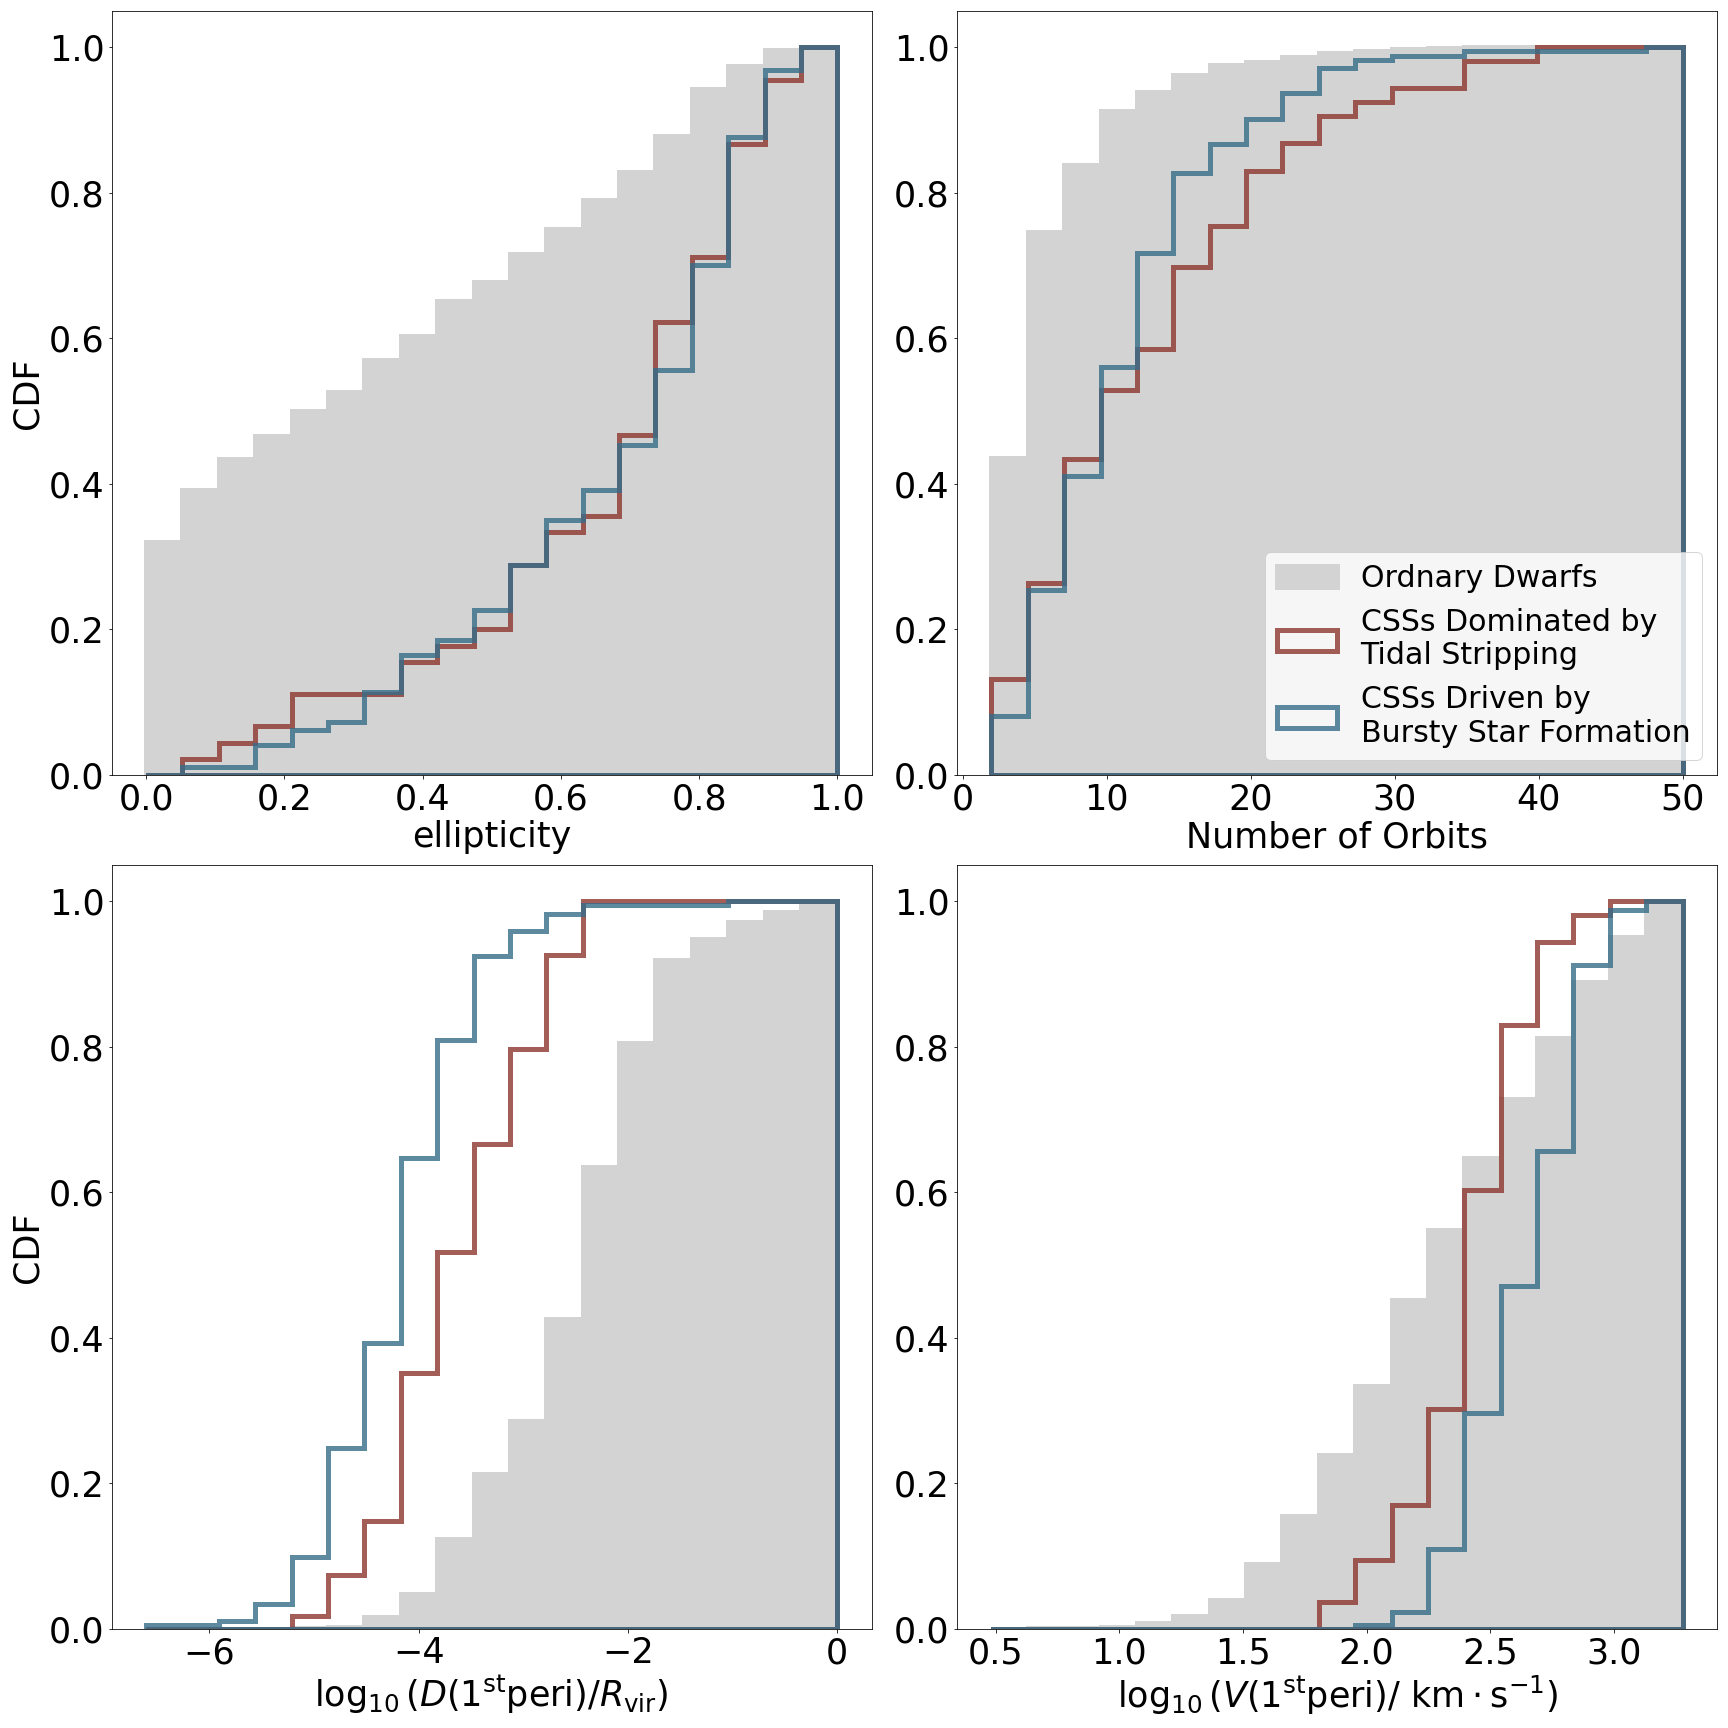

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

grp = (65/305,130/305,164/305,0.8)
cl = (166/305,64/305,54/305,0.8)

CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)

filter_condition_TS = (np.array(CSSs3['Form_Type']) == 'Tidal Stripping')
filter_condition_BSF = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation')
filter_condition_Both = ((np.array(CSSs3['Form_Type']) == 'Tidal Stripping') | (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation')) & (np.array(CSSs3['Distance_grpvir'] < 10))

# dis_ND_0 = np.array(normalized_first_pericenter_distances_ND)[np.where(np.array(orbit_counts_ND) <= 1)]
dis_ND_1 = np.array(normalized_first_pericenter_distances_ND)[np.where(np.array(orbit_counts_ND) > 1)]

# v_ND_0 = np.array(first_pericenter_velocity_ND)[np.where(np.array(orbit_counts_ND) <= 1)]
v_ND_1 = np.array(first_pericenter_velocity_ND)[np.where(np.array(orbit_counts_ND) > 1)]

# orbit_ND_0 = np.array(orbit_counts_ND)[np.where(np.array(orbit_counts_ND) <= 1)]
orbit_ND_1 = np.array(orbit_counts_ND)[np.where(np.array(orbit_counts_ND) > 1)]

# print(len(orbit_ND_0))
print(len(orbit_ND_1))

# 绘制归一化的第一近心点距离的分布直方图
fig, axs = plt.subplots(2, 2, figsize=(24, 24))

axs = axs.flatten()

dis_min = min(min(np.log10(normalized_first_pericenter_distances_TS)),min(np.log10(normalized_first_pericenter_distances_BSF)))
dis_max = max(max(np.log10(normalized_first_pericenter_distances_TS)),max(np.log10(normalized_first_pericenter_distances_BSF)))

# axs[0].hist(np.log10(dis_ND_0), bins=np.linspace(dis_min,0.5,20), edgecolor='grey', facecolor='grey', linewidth=5, histtype='stepfilled',density=True ,cumulative=True)
axs[2].hist(np.log10(dis_ND_1), bins=np.linspace(dis_min,0,20), edgecolor='lightgrey', facecolor='lightgrey', linewidth=5, histtype='stepfilled',density=True ,cumulative=True, label='Ordinary Dwarfs')

# axs[0].hist(np.log10(np.array(CSSs3['Distance_grpvir'])[filter_condition_TS]), bins=np.linspace(dis_min,0.5,20), facecolor='none', alpha=0.5, edgecolor=cl, linewidth=5, linestyle='--', histtype='stepfilled', label='CSSs Dominated by\nTidal Stripping (z=0)',density=True ,cumulative=True)
# axs[0].hist(np.log10(np.array(CSSs3['Distance_grpvir'])[filter_condition_BSF]), bins=np.linspace(dis_min,0.5,20), facecolor='none', alpha=0.5, edgecolor=grp, linewidth=5, linestyle='--', histtype='stepfilled', label='CSSs Driven by\nBursty Star Formation (z=0)',density=True ,cumulative=True)

axs[2].hist(np.log10(normalized_first_pericenter_distances_TS), bins=np.linspace(dis_min,0,20), edgecolor=cl, facecolor='none', linewidth=5, histtype='stepfilled',density=True ,cumulative=True, label='CSSs Dominated by\nTidal Stripping')
axs[2].hist(np.log10(normalized_first_pericenter_distances_BSF), bins=np.linspace(dis_min,0,20), edgecolor=grp, facecolor='none', linewidth=5, histtype='stepfilled',density=True ,cumulative=True, label='CSSs Driven by\nBursty Star Formation')

# ax2 = axs[0].twinx()

# dis_min_1 = min(min(np.log10(normalized_min_distances_TS)),min(np.log10(normalized_min_distances_BSF)))
# dis_max_1 = max(max(np.log10(normalized_min_distances_TS)),max(np.log10(normalized_min_distances_BSF)))

# axs[0].hist(np.log10(normalized_min_distances_TS), bins=np.linspace(dis_min_1,dis_max_1,20), edgecolor=cl, linestyle='--', facecolor='none', linewidth=3, histtype='stepfilled',label=r'Tidal Stripping ($d_{min}$)')
# axs[0].hist(np.log10(normalized_min_distances_BSF), bins=np.linspace(dis_min_1,dis_max_1,20), edgecolor=grp, linestyle='--', facecolor='none', linewidth=3, histtype='stepfilled',label=r'Bursty Star Fromation ($d_{min}$)')
# ax2.set_ylabel('', color='red', fontsize=35)
# ax2.tick_params(axis='y', labelcolor='red', labelsize=35)
# ax2.legend(loc='lower left',fontsize=20)

axs[2].tick_params(axis='x', which='both', labelsize=35)
axs[2].tick_params(axis='y', which='both', labelsize=35)
# axs[0].set_title('Normalized First Pericentric Distances',fontsize=35)
axs[2].set_xlabel('$\log_{10}(D(1^{\mathrm{st}}\mathrm{peri})/R_{\mathrm{vir}})$',fontsize=35)
axs[2].set_ylabel('CDF',fontsize=35)
# axs[2].legend(loc='upper left',fontsize=30)

v_min_1 = min(min(np.log10(first_pericenter_velocity_TS)),min(np.log10(first_pericenter_velocity_BSF)))
v_min_1 = min(v_min_1,min(np.log10(first_pericenter_velocity_ND)))
v_max_1 = max(max(np.log10(first_pericenter_velocity_TS)),max(np.log10(first_pericenter_velocity_BSF)))
v_max_1 = min(v_max_1,max(np.log10(first_pericenter_velocity_ND)))

# axs[1].hist(np.log10(np.array(v_ND_0)/h), bins=np.linspace(2,3.5,20), edgecolor='grey', linestyle='-', facecolor='grey', linewidth=5, histtype='stepfilled',density=True ,cumulative=True)
axs[3].hist(np.log10(np.array(v_ND_1)/h), bins=np.linspace(v_min_1,v_max_1,20), edgecolor='lightgrey', linestyle='-', facecolor='lightgrey', linewidth=5, histtype='stepfilled',density=True ,cumulative=True)

axs[3].hist(np.log10(first_pericenter_velocity_TS), bins=np.linspace(v_min_1,v_max_1,20), edgecolor=cl, linestyle='-', facecolor='none', linewidth=5, histtype='stepfilled',label=r'Tidal Stripping',density=True ,cumulative=True)
axs[3].hist(np.log10(first_pericenter_velocity_BSF), bins=np.linspace(v_min_1,v_max_1,20), edgecolor=grp, linestyle='-', facecolor='none', linewidth=5, histtype='stepfilled',label=r'Bursty Star Fromation',density=True ,cumulative=True)
# ax2.set_ylabel('', color='red', fontsize=35)
# ax2.tick_params(axis='y', labelcolor='red', labelsize=35)
# ax2.legend(loc='lower left',fontsize=20)

axs[3].tick_params(axis='x', which='both', labelsize=35)
axs[3].tick_params(axis='y', which='both', labelsize=35)
# axs[1].set_title('First Pericentric Velocities',fontsize=35)
axs[3].set_xlabel(r'$\log_{10}(V(1^{\mathrm{st}}\mathrm{peri})/\ \mathrm{km} \cdot \mathrm{s}^{-1})$',fontsize=35)
# axs[1].set_ylabel('Number of Galaxies',fontsize=35)
# axs[1].legend(loc='upper left',fontsize=20)

# 绘制轨道数的分布直方图

orbit_min = min(min(orbit_counts_TS),min(orbit_counts_BSF))
orbit_max = max(min(orbit_counts_TS),max(orbit_counts_BSF))

# axs[2].hist(orbit_ND_0, bins=np.linspace(orbit_min,orbit_max,20), edgecolor='grey', facecolor='grey', linewidth=5, histtype='stepfilled',label=r'Ordnary Dwarfs (<=1) ($t=t_{1^{st}peri}$)',density=True ,cumulative=True)
axs[1].hist(orbit_ND_1, bins=np.linspace(orbit_min,orbit_max,20), edgecolor='lightgrey', facecolor='lightgrey', linewidth=5, histtype='stepfilled',label='Ordnary Dwarfs',density=True ,cumulative=True)

axs[1].hist(orbit_counts_TS, bins=np.linspace(orbit_min,orbit_max,20), edgecolor=cl, facecolor='none', linewidth=5, histtype='stepfilled',label='CSSs Dominated by\nTidal Stripping',density=True ,cumulative=True)
axs[1].hist(orbit_counts_BSF, bins=np.linspace(orbit_min,orbit_max,20), edgecolor=grp, facecolor='none', linewidth=5, histtype='stepfilled',label='CSSs Driven by\nBursty Star Formation',density=True ,cumulative=True)
axs[1].tick_params(axis='x', which='both', labelsize=35)
axs[1].tick_params(axis='y', which='both', labelsize=35)
# axs[2].set_title('Total Orbit Counts',fontsize=35)
axs[1].set_xlabel('Number of Orbits',fontsize=35)
# axs[2].legend(loc='lower right',fontsize=30)
# axs[1].set_ylabel('CDF',fontsize=35)
axs[1].legend(loc='lower right',fontsize=30)

# 清理数据，移除None值
ellipticity_ND = [e for e in ellipticity_ND if e is not None]
ellipticity_TS = [e for e in ellipticity_TS if e is not None]
ellipticity_BSF = [e for e in ellipticity_BSF if e is not None]

axs[0].hist(np.array(ellipticity_ND), bins=np.linspace(0,1,20), edgecolor='lightgrey', facecolor='lightgrey', linewidth=5, histtype='stepfilled',label='Ordinary Dwarfs (>1)\n($t=t_{1^{st}peri}$)',density=True ,cumulative=True)

axs[0].hist(np.array(ellipticity_TS), bins=np.linspace(0,1,20), edgecolor=cl, facecolor='none', linewidth=5, histtype='stepfilled',label='CSSs Dominated by\nTidal Stripping\n($t=t_{1^{st}peri}$)',density=True ,cumulative=True)
axs[0].hist(np.array(ellipticity_BSF), bins=np.linspace(0,1,20), edgecolor=grp, facecolor='none', linewidth=5, histtype='stepfilled',label='CSSs Driven by\nBursty Star Formation\n($t=t_{1^{st}peri}$)',density=True ,cumulative=True)
axs[0].tick_params(axis='x', which='both', labelsize=35)
axs[0].tick_params(axis='y', which='both', labelsize=35)
axs[0].set_ylabel('CDF',fontsize=35)
axs[0].set_xlabel('ellipticity',fontsize=35)
# axs[0].legend(loc='lower right',fontsize=30)

# vr_min_1 = min(min(np.log10(np.abs(radial_velocities_TS))),min(np.log10(np.abs(radial_velocities_BSF))))
# vr_min_1 = min(vr_min_1,min(np.log10(np.array(np.abs(radial_velocities_ND))/h)))
# vr_max_1 = max(max(np.log10(np.abs(radial_velocities_TS))),max(np.log10(np.abs(radial_velocities_BSF))))
# vr_max_1 = min(vr_max_1,max(np.log10(np.array(np.abs(radial_velocities_ND))/h)))

# axs[4].hist(np.log10(np.array(np.abs(radial_velocities_ND))/h), bins=np.linspace(vr_min_1,vr_max_1,20), edgecolor='lightgrey', linestyle='-', facecolor='lightgrey', linewidth=5, histtype='stepfilled',density=True ,cumulative=True)

# axs[4].hist(np.log10(np.abs(radial_velocities_TS)), bins=np.linspace(vr_min_1,vr_max_1,20), edgecolor=cl, linestyle='-', facecolor='none', linewidth=5, histtype='stepfilled',label=r'Tidal Stripping',density=True ,cumulative=True)
# axs[4].hist(np.log10(np.abs(radial_velocities_BSF)), bins=np.linspace(vr_min_1,vr_max_1,20), edgecolor=grp, linestyle='-', facecolor='none', linewidth=5, histtype='stepfilled',label=r'Bursty Star Fromation',density=True ,cumulative=True)

# axs[4].tick_params(axis='x', which='both', labelsize=35)
# axs[4].tick_params(axis='y', which='both', labelsize=35)
# axs[4].set_xlabel('$\log_{10}(V_{r}\ km/s)$',fontsize=35)

# vt_min_1 = min(min(np.log10(np.abs(tangential_velocities_TS))),min(np.log10(np.abs(tangential_velocities_BSF))))
# vt_min_1 = min(vt_min_1, min(np.log10(np.array(np.abs(tangential_velocities_ND))/h)))
# vt_max_1 = max(max(np.log10(np.abs(tangential_velocities_TS))),max(np.log10(np.abs(tangential_velocities_BSF))))
# vt_max_1 = min(vt_max_1,max(np.log10(np.array(np.abs(tangential_velocities_ND))/h)))

# axs[5].hist(np.log10(np.array(np.abs(tangential_velocities_ND))/h), bins=np.linspace(vt_min_1,vt_max_1,20), edgecolor='lightgrey', linestyle='-', facecolor='lightgrey', linewidth=5, histtype='stepfilled',density=True ,cumulative=True)

# axs[5].hist(np.log10(np.abs(tangential_velocities_TS)), bins=np.linspace(vt_min_1,vt_max_1,20), edgecolor=cl, linestyle='-', facecolor='none', linewidth=5, histtype='stepfilled',label=r'Tidal Stripping',density=True ,cumulative=True)
# axs[5].hist(np.log10(np.abs(tangential_velocities_BSF)), bins=np.linspace(vt_min_1,vt_max_1,20), edgecolor=grp, linestyle='-', facecolor='none', linewidth=5, histtype='stepfilled',label=r'Bursty Star Fromation',density=True ,cumulative=True)

# axs[5].tick_params(axis='x', which='both', labelsize=35)
# axs[5].tick_params(axis='y', which='both', labelsize=35)
# axs[5].set_xlabel(r'$\log_{10}(V_{\theta}\ km/s)$',fontsize=35)

plt.tight_layout()
plt.savefig('/home/bianyuan/workspace/pic/Firstperi_orbit.pdf')

In [27]:
first_pericenter_velocity_BSF

[array([1.27033807, 1.27588173, 1.27992085, 1.28410356, 1.29234746,
        1.2896549 , 1.28630201, 1.28485318, 1.27801229, 1.27101709,
        1.2569167 , 1.23737071, 1.22242967, 1.19049135, 1.17497697,
        1.16765624, 1.17415446, 1.18013735, 1.18990102, 1.19988187,
        1.2059726 , 1.23580335, 1.23502959, 1.26018732, 1.31078983,
        1.41711017, 1.60704689, 1.69078817, 1.7184762 , 1.73182784,
        1.73955173, 2.48626571, 2.55532559, 2.62748526, 2.69274999,
        2.78317426, 2.89011378, 2.89570547, 2.92799116, 2.93764834,
        2.97341189, 3.05254511]),
 array([1.15518932, 1.16023049, 1.16390348, 1.16770705, 1.17520369,
        1.17275519, 1.16970622, 1.16838872, 1.16216792, 1.15580679,
        1.14298452, 1.12521026, 1.11162354, 1.08258025, 1.06847216,
        1.061815  , 1.0677242 , 1.07316477, 1.08204342, 1.09111957,
        1.09665821, 1.12378498, 1.12308135, 1.14595868, 1.19197437,
        1.28865739, 1.46137745, 1.53752807, 1.56270634, 1.57484773,
        1.5818

In [4]:
print(ellipticity_ND)

[None, None, None, None, 0.59181774, 0.39976817, 0.12346955, None, None, None, 0.29820037, 0.05584655, 0.129748, 0.24057779, 0.37016597, 0.51893914, None, 0.7105495, 0.14625704, 0.1495853, 0.40312064, 0.2832154, None, None, None, 0.739092, 0.30124342, None, 0.36589697, 0.48577297, 0.5366416, 0.5980885, None, 0.20627259, 0.46183747, None, None, 0.6452074, 0.40629607, None, 0.8551065, None, None, 0.6154466, None, 0.8502655, None, 0.5677807, None, 0.0665573, 0.4491728, 0.34356582, None, 0.5622618, None, 0.22789505, None, 0.28204635, 0.6247066, 0.42921922, None, 0.9502592, None, None, 0.2741171, None, 0.97260654, 0.2973123, 0.50232047, 0.116315484, None, None, 0.60897875, 0.2543047, None, 0.21152437, 0.94746226, None, None, 0.36815274, None, 0.9946283, 0.2763872, None, None, 0.30444065, 0.5311695, 0.2705708, 0.3520829, 0.41525137, 0.4836431, 0.6099024, None, None, 0.51801133, 0.40444803, 0.103153326, None, 0.7069831, None, 0.52747744, 0.37849557, None, 0.6595287, None, 0.6049678, None, 0.2

In [ ]:
orbit_counts_ND

In [6]:
import h5py
import numpy as np

# 定义找到局部最小和最大值的函数
def find_local_min_max(distances):
    local_min, local_max = [], []
    for i in range(1, len(distances) - 1):
        if distances[i] < distances[i - 1] and distances[i] < distances[i + 1]:
            local_min.append(i)
        elif distances[i] > distances[i - 1] and distances[i] > distances[i + 1]:
            local_max.append(i)
    return local_min, local_max

# 读取HDF5文件
file_path = '/home/bianyuan/workspace/data/track/MRO_grp_orbit2D_1.hdf5'
hdf_file = h5py.File(file_path, 'r')

# 初始化列表
first_pericenter_distances_MRO_grp = []
normalized_first_pericenter_distances_MRO_grp = []
orbit_counts_MRO_grp = []

# 遍历HDF5文件中的每个组（即每个星系）
for group_name in hdf_file.keys():
    group = hdf_file[group_name]

    # 读取数据
    x = group['x'][:]
    y = group['y'][:]
    z = group['z'][:]
    Snap = group['Snap'][:]
    Rvir = group['Rvir'][:] if 'Rvir' in group.keys() else np.repeat(np.nan, len(Snap))

    print(Rvir)

    # 计算距离
    distances = np.sqrt(x**2 + y**2 + z**2)

    # 找到近心点和远心点
    local_min, local_max = find_local_min_max(distances)

    # 计算第一近心点的距离和归一化距离
    if local_min:
        first_pericenter_distance = distances[local_min[0]]
        snap_idx = Snap[local_min[0]]  # 第一近心点对应的快照号
        rvir_idx = np.where(Snap == snap_idx)[0][0]  # 对应的Rvir索引
        normalized_distance = first_pericenter_distance / Rvir[rvir_idx] if Rvir[rvir_idx] > 0 else np.nan
    else:
        first_pericenter_distance = np.nan
        normalized_distance = np.nan

    # 追加到列表
    first_pericenter_distances_MRO_grp.append(first_pericenter_distance)
    normalized_first_pericenter_distances_MRO_grp.append(normalized_distance)
    orbit_counts_MRO_grp.append(len(local_max))

# 关闭HDF5文件
hdf_file.close()

[403.30488702 405.53500387 409.42700873 411.66708186 415.7027545
 418.55939624 423.15667521 425.6320049  430.37178033 434.57319577
 441.06451079 453.558337   459.45074342 465.76271023 468.79333911
 473.94037599 479.18693063 481.41330824 484.71843313 487.891153
 488.62553009 488.61233013 482.96905599 479.0243414  479.29825176
 477.7831851  476.21950837 475.45165835 474.47598786 473.64443567
 473.99777102 471.83230242 472.2127585  475.2079322  478.99722067
 484.21440203 490.64525855 498.64718018 505.25535761 511.77419883
 514.16113836 517.30732317 519.54005297 521.57946875 522.19617251
 520.61731357 511.39549974 494.92988327 492.74972804 482.74244923
 485.15565352 488.51384855]
[403.30488702 405.53500387 409.42700873 411.66708186 415.7027545
 418.55939624 423.15667521 425.6320049  430.37178033 434.57319577
 441.06451079 453.558337   459.45074342 465.76271023 468.79333911
 473.94037599 479.18693063 481.41330824 484.71843313 487.891153
 488.62553009 488.61233013 482.96905599 479.0243414  4

In [7]:
import h5py
import numpy as np

# 定义找到局部最小和最大值的函数
def find_local_min_max(distances):
    local_min, local_max = [], []
    for i in range(1, len(distances) - 1):
        if distances[i] < distances[i - 1] and distances[i] < distances[i + 1]:
            local_min.append(i)
        elif distances[i] > distances[i - 1] and distances[i] > distances[i + 1]:
            local_max.append(i)
    return local_min, local_max

# 读取HDF5文件
file_path = '/home/bianyuan/workspace/data/track/MRO_cl_orbit2D_1.hdf5'
hdf_file = h5py.File(file_path, 'r')

# 初始化列表
first_pericenter_distances_MRO_cl = []
normalized_first_pericenter_distances_MRO_cl = []
orbit_counts_MRO_cl = []

# 遍历HDF5文件中的每个组（即每个星系）
for group_name in hdf_file.keys():
    group = hdf_file[group_name]

    # 读取数据
    x = group['x'][:]
    y = group['y'][:]
    z = group['z'][:]
    Snap = group['Snap'][:]
    Rvir = group['Rvir'][:] if 'Rvir' in group.keys() else np.repeat(np.nan, len(Snap))

    print(Rvir)

    # 计算距离
    distances = np.sqrt(x**2 + y**2 + z**2)

    # 找到近心点和远心点
    local_min, local_max = find_local_min_max(distances)

    # 计算第一近心点的距离和归一化距离
    if local_min:
        first_pericenter_distance = distances[local_min[0]]
        snap_idx = Snap[local_min[0]]  # 第一近心点对应的快照号
        rvir_idx = np.where(Snap == snap_idx)[0][0]  # 对应的Rvir索引
        normalized_distance = first_pericenter_distance / Rvir[rvir_idx] if Rvir[rvir_idx] > 0 else np.nan
    else:
        first_pericenter_distance = np.nan
        normalized_distance = np.nan

    # 追加到列表
    first_pericenter_distances_MRO_cl.append(first_pericenter_distance)
    normalized_first_pericenter_distances_MRO_cl.append(normalized_distance)
    orbit_counts_MRO_cl.append(len(local_max))

# 关闭HDF5文件
hdf_file.close()

[1198.20057835 1202.54286841 1211.67372418 1216.77215099 1223.09470479
 1232.44324722 1246.02109167 1254.55015558 1270.39100415 1282.61064969
 1303.54361792 1328.62236354 1347.02589577 1382.52720074 1402.35470641
 1419.68899714 1425.76349989 1428.39150757 1431.57580556 1434.44231347
 1436.71991412 1427.31505789 1434.72451322   29.34465726 1398.16324726
   28.09719382   29.12489263 1200.82795532 1195.4140811  1196.61162798
 1200.26175378 1224.92539907 1237.91091239 1259.14374037 1274.59444689
 1280.01156478 1283.99723077 1281.66556886 1276.85727079 1268.55643548
 1260.30641775 1243.57554073 1223.41727028 1176.03276098 1147.18297255
 1095.33309373 1071.21961181 1043.14569249 1028.42156923 1013.43966389
   43.62072535  982.40057487  962.06146952  963.88558635  960.42386402]
[692.4024908  695.0614936  701.8323053  709.49634409 716.90336666
 721.835465   729.65754286 749.06346085 762.84556675 768.25169219
 776.23527804 789.05554412 794.11594784 795.32268514 796.83531904
 802.08764021 804.64

In [8]:
import h5py
import numpy as np

# 定义找到局部最小和最大值的函数
def find_local_min_max(distances):
    local_min, local_max = [], []
    for i in range(1, len(distances) - 1):
        if distances[i] < distances[i - 1] and distances[i] < distances[i + 1]:
            local_min.append(i)
        elif distances[i] > distances[i - 1] and distances[i] > distances[i + 1]:
            local_max.append(i)
    return local_min, local_max

# 读取HDF5文件
file_path = '/home/bianyuan/workspace/data/track/MRI_cl_orbit2D_1.hdf5'
hdf_file = h5py.File(file_path, 'r')

# 初始化列表
first_pericenter_distances_MRI_cl = []
normalized_first_pericenter_distances_MRI_cl = []
orbit_counts_MRI_cl = []

# 遍历HDF5文件中的每个组（即每个星系）
for group_name in hdf_file.keys():
    group = hdf_file[group_name]

    # 读取数据
    x = group['x'][:]
    y = group['y'][:]
    z = group['z'][:]
    Snap = group['Snap'][:]
    Rvir = group['Rvir'][:] if 'Rvir' in group.keys() else np.repeat(np.nan, len(Snap))

    print(Rvir)

    # 计算距离
    distances = np.sqrt(x**2 + y**2 + z**2)

    # 找到近心点和远心点
    local_min, local_max = find_local_min_max(distances)

    # 计算第一近心点的距离和归一化距离
    if local_min:
        first_pericenter_distance = distances[local_min[0]]
        snap_idx = Snap[local_min[0]]  # 第一近心点对应的快照号
        rvir_idx = np.where(Snap == snap_idx)[0][0]  # 对应的Rvir索引
        normalized_distance = first_pericenter_distance / Rvir[rvir_idx] if Rvir[rvir_idx] > 0 else np.nan
    else:
        first_pericenter_distance = np.nan
        normalized_distance = np.nan

    # 追加到列表
    first_pericenter_distances_MRI_cl.append(first_pericenter_distance)
    normalized_first_pericenter_distances_MRI_cl.append(normalized_distance)
    orbit_counts_MRI_cl.append(len(local_max))

# 关闭HDF5文件
hdf_file.close()

[1198.20057835 1202.54286841 1211.67372418 1216.77215099 1223.09470479
 1232.44324722 1246.02109167 1254.55015558 1270.39100415 1282.61064969
 1303.54361792 1328.62236354 1347.02589577 1382.52720074 1402.35470641
 1419.68899714 1425.76349989 1428.39150757 1431.57580556 1434.44231347
 1436.71991412 1427.31505789 1434.72451322 1425.52932455 1398.16324726
 1234.19077727 1200.82795532 1195.4140811  1196.61162798 1200.26175378
 1207.43279898 1216.21072486 1224.92539907 1237.91091239 1259.14374037
 1274.59444689 1280.01156478]
[1198.20057835 1202.54286841 1211.67372418 1216.77215099 1223.09470479
 1232.44324722 1246.02109167 1254.55015558 1270.39100415 1282.61064969
 1303.54361792 1328.62236354 1347.02589577 1382.52720074 1402.35470641
 1419.68899714 1425.76349989 1428.39150757 1431.57580556 1434.44231347
 1436.71991412 1427.31505789 1434.72451322 1425.52932455 1398.16324726
 1234.19077727 1200.82795532 1195.4140811 ]
[692.4024908  695.0614936  701.8323053  709.49634409 716.90336666
 721.835

In [4]:
import h5py
import numpy as np

# 定义找到局部最小和最大值的函数
def find_local_min_max(distances):
    local_min, local_max = [], []
    for i in range(1, len(distances) - 1):
        if distances[i] < distances[i - 1] and distances[i] < distances[i + 1]:
            local_min.append(i)
        elif distances[i] > distances[i - 1] and distances[i] > distances[i + 1]:
            local_max.append(i)
    return local_min, local_max

# 读取HDF5文件
file_path = '/home/bianyuan/workspace/data/track/MRI_grp_orbit2D_1.hdf5'
hdf_file = h5py.File(file_path, 'r')

# 初始化列表
first_pericenter_distances_MRI_grp = []
normalized_first_pericenter_distances_MRI_grp = []
orbit_counts_MRI_grp = []

# 遍历HDF5文件中的每个组（即每个星系）
for group_name in hdf_file.keys():
    group = hdf_file[group_name]

    # 读取数据
    x = group['x'][:]
    y = group['y'][:]
    z = group['z'][:]
    Snap = group['Snap'][:]
    Rvir = group['Rvir'][:] if 'Rvir' in group.keys() else np.repeat(np.nan, len(Snap))

    print(Rvir)

    # 计算距离
    distances = np.sqrt(x**2 + y**2 + z**2)

    # 找到近心点和远心点
    local_min, local_max = find_local_min_max(distances)

    # 计算第一近心点的距离和归一化距离
    if local_min:
        first_pericenter_distance = distances[local_min[0]]
        snap_idx = Snap[local_min[0]]  # 第一近心点对应的快照号
        rvir_idx = np.where(Snap == snap_idx)[0][0]  # 对应的Rvir索引
        normalized_distance = first_pericenter_distance / Rvir[rvir_idx] if Rvir[rvir_idx] > 0 else np.nan
    else:
        first_pericenter_distance = np.nan
        normalized_distance = np.nan

    # 追加到列表
    first_pericenter_distances_MRI_grp.append(first_pericenter_distance)
    normalized_first_pericenter_distances_MRI_grp.append(normalized_distance)
    orbit_counts_MRI_grp.append(len(local_max))

# 关闭HDF5文件
hdf_file.close()

[384.09322914 385.78895049 388.31158377 389.73826027 391.70753157
 392.92895551 392.43190733 393.33513574 394.57836438 395.53673527
 398.388962   402.12238718 405.02980145 408.30510255 409.9754151
 412.86174548 421.01981403 423.38517411 426.18162765 432.87846554
 437.4555166  444.2907513  447.66475924 454.10886077 461.08447453
 472.25587235 481.75425455 488.6714371  494.81540857 498.87847225
 502.81588856 505.48619917 505.42583077 500.17549184 497.40597883
 494.31592763 489.25628977 483.29806377 464.77122683 399.35508167
 385.85702261 381.406565   375.0735143 ]
[384.09322914 385.78895049 388.31158377 389.73826027 391.70753157
 392.92895551 392.43190733 393.33513574 394.57836438 395.53673527
 398.388962   402.12238718 405.02980145 408.30510255 409.9754151
 412.86174548 421.01981403 423.38517411 426.18162765 432.87846554
 437.4555166  444.2907513  447.66475924 454.10886077 461.08447453
 472.25587235 481.75425455 488.6714371  494.81540857 498.87847225]
[384.09322914 385.78895049 388.31158

In [11]:
normalized_first_pericenter_distances = np.concatenate([
    np.array(normalized_first_pericenter_distances_MRI_grp),
    np.array(normalized_first_pericenter_distances_MRI_cl),
    np.array(normalized_first_pericenter_distances_MRO_grp),
    np.array(normalized_first_pericenter_distances_MRO_cl)
])

orbit_counts = np.concatenate([
    np.array(orbit_counts_MRI_grp),
    np.array(orbit_counts_MRI_cl),
    np.array(orbit_counts_MRO_grp),
    np.array(orbit_counts_MRO_cl)
])


NameError: name 'normalized_first_pericenter_distances' is not defined

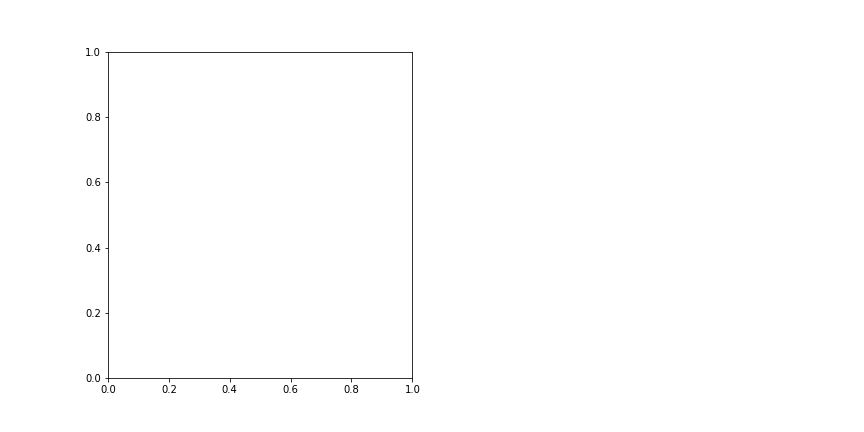

In [5]:
# 绘制归一化的第一近心点距离的分布直方图
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(np.log10(normalized_first_pericenter_distances+1e-5), np.linspace(-2.4,0,15), color=(167/255,211/255,212/255), edgecolor='white')
plt.title('Normalized First Pericenter Distances', fontsize=14)
plt.xlabel('$\mathrm{log}(D/R_{\mathrm{vir}})$', fontsize=14)
plt.ylabel('Number of Galaxies', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 绘制轨道数的分布直方图
plt.subplot(1, 2, 2)
plt.hist(orbit_counts, bins=15, color=(228/255,193/255,217/255), edgecolor='white')
plt.title('Orbit Counts', fontsize=14)
plt.xlabel('Number of Orbits', fontsize=14)
# plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig('/home/bianyuan/workspace/pic/Firstperi_orbit.pdf')

In [28]:
print(first_pericenter_distances)

[21.920426840786206, 41.391944629472086, 5.875842270054807, 34.63539329417993, 16.871496842799637, 15.75078738738822, 10.056300452630015, 14.30565532880465, 39.37640236191832, 16.007377736862804, 10.832585801769527, 9.921910868730206, 22.40654908958544, 25.271756670512186, 7.0938709948234955, 332.52206839501787]


In [29]:
print(normalized_first_pericenter_distances)

[0.05353927897635581, 0.09126046475895973, 0.016643074558084777, 0.09858485832622049, 0.049333040134693605, 0.0446317289473799, 0.03238568092683869, 0.05106445222466152, 0.12441925138003836, 0.05359600471735554, 0.03746252114074319, 0.034231465400101316, 0.07685103335652888, 0.09155004856189589, 0.025353455712362048, 1.539261019228768]


In [30]:
print(orbit_counts)

[13, 6, 8, 8, 4, 17, 13, 7, 10, 24, 17, 6, 12, 12, 10, 2]


In [41]:
import h5py
import numpy as np
import pandas as pd

def find_local_min_max(distances):
    local_min, local_max = [], []
    for i in range(1, len(distances) - 1):
        if distances[i] < distances[i - 1] and distances[i] < distances[i + 1]:
            local_min.append(i)
        elif distances[i] > distances[i - 1] and distances[i] > distances[i + 1]:
            local_max.append(i)
    return local_min, local_max

def process_hdf5(file_path):
    hdf_file = h5py.File(file_path, 'r')
    normalized_distances = {}
    orbit_counts = {}

    for group_name in hdf_file.keys():
        group = hdf_file[group_name]
        x, y, z = group['x'][:], group['y'][:], group['z'][:]
        Snap, Rvir = group['Snap'][:], group['Rvir'][:]
        distances = np.sqrt(x**2 + y**2 + z**2)
        local_min, local_max = find_local_min_max(distances)

        if local_min:
            first_distance = distances[local_min[0]]
            snap_idx = Snap[local_min[0]]
            rvir_idx = np.where(Snap == snap_idx)[0][0]
            normalized_distance = first_distance / Rvir[rvir_idx] if Rvir[rvir_idx] > 0 else np.nan
        else:
            normalized_distance = np.nan

        normalized_distances[int(group_name)] = normalized_distance
        orbit_counts[int(group_name)] = len(local_max)

    hdf_file.close()
    return normalized_distances, orbit_counts

excel_path = '/home/bianyuan/workspace/data/CSSs3_5.xlsx'
df = pd.read_excel(excel_path)

hdf5_files = [
    '/home/bianyuan/workspace/data/track/MRO_grp_orbit2D_1.hdf5',
    '/home/bianyuan/workspace/data/track/MRO_cl_orbit2D_1.hdf5',
    '/home/bianyuan/workspace/data/track/MRI_cl_orbit2D_1.hdf5',
    '/home/bianyuan/workspace/data/track/MRI_grp_orbit2D_1.hdf5'
]

for file_path in hdf5_files:
    normalized_distances, orbit_counts = process_hdf5(file_path)
    for id, norm_dist in normalized_distances.items():
        if id in df['ID'].values:
            df.loc[df['ID'] == id, 'Normalized First Pericenter Distances'] = norm_dist
        else:
            df = df.append({'ID': id, 'Normalized First Pericenter Distances': norm_dist}, ignore_index=True)
    for id, count in orbit_counts.items():
        if id in df['ID'].values:
            df.loc[df['ID'] == id, 'Number of Orbits'] = count
        else:
            df = df.append({'ID': id, 'Number of Orbits': count}, ignore_index=True)

df.to_excel(excel_path, index=False)

print(f"Excel file '{excel_path}' has been updated with new data.")

Excel file '/home/bianyuan/workspace/data/CSSs3_5.xlsx' has been updated with new data.


KeyError: 'Normalized First Pericenter Distances'

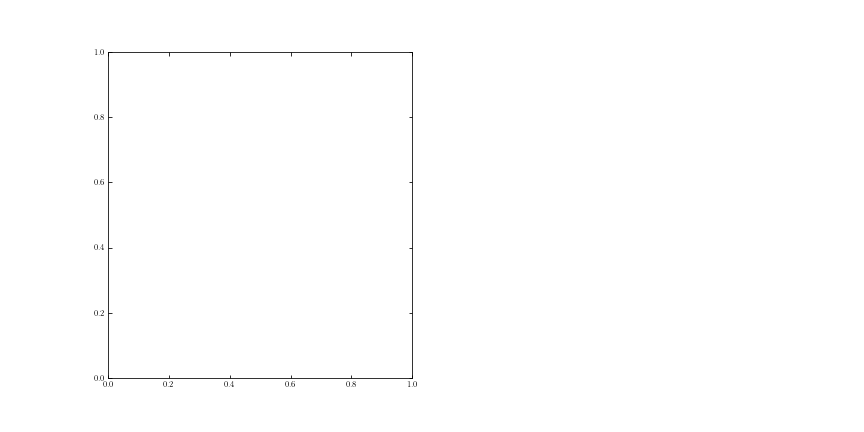

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

CSSs3 = sns.load_dataset('CSSs3_2',data_home='/home/bianyuan/workspace/data',cache=True)

# 绘制归一化的第一近心点距离的分布直方图
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(np.array(CSSs3['Normalized First Pericenter Distances'])[np.where( (np.array(CSSs3['Form_Type'])=='Tidal Stripping') & ((13.8-CSSs3['MWted-Age']) >= 2.9) & (np.array(CSSs3['[Z/H]_r']) > 0.1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) )], color='skyblue', edgecolor='black')
plt.title('Normalized First Pericenter Distances')
plt.xlabel('Normalized Distance')
plt.ylabel('Frequency')

# 绘制轨道数的分布直方图
plt.subplot(1, 2, 2)
plt.hist(np.array(CSSs3['Number of Orbits'])[np.where( (np.array(CSSs3['Form_Type'])=='Tidal Stripping') & ((13.8-CSSs3['MWted-Age']) >= 2.9) & (np.array(CSSs3['[Z/H]_r']) > 0.1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) )], bins=range(max(orbit_counts)+1), color='lightgreen', edgecolor='black')
plt.title('Orbit Counts')
plt.xlabel('Number of Orbits')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('/home/bianyuan/workspace/pic/Firstperi_orbit.pdf')

In [3]:
import seaborn as sns

CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)

for i in np.array(CSSs3['ID']):
    Subhalo = il.groupcat.loadSingle(basePath, 99, subhaloID=int(i))
    print(Subhalo['SubhaloFlag'])

False
True
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
True
False
False
False
False
True
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
True
False
True
True
False
True
False
False
False
False
True
True
False
False
False
False
False
False
False
False
True
False
False
False
True
False
False
False
False
True
False
False
True
True
True
False
True
True
True
False
True
False
True
False
True
False
False
False
False
False
True
True
False
True
True
True
False
False
True
False
False
True
False
True
False
True
False
False
True
False
False
False
False
False
False
False
False
True
True
True
False
False
False
True
False
False
False
False
False
True
True
True
True
True
False
True
False
False
False
True
False
False
False
False
True
True
True
True
True
True
True
True
True
True
False
True
False
True
True
False
True
True
True
False
True
True
True
True
False
Fal

In [5]:
import pandas as pd

def load_css3_and_add_subhaloflag(csv_file_path, basePath):
    # 加载CSV文件
    css3_df = pd.read_csv(csv_file_path)
    
    # 初始化SubhaloFlag列
    css3_df['SubhaloFlag'] = None
    
    # 遍历DataFrame中的每一行
    for index, row in css3_df.iterrows():
        subhaloID = int(row['ID'])
        # 加载subhalo信息
        Subhalo = il.groupcat.loadSingle(basePath, 99, subhaloID=subhaloID)
        # 填充SubhaloFlag
        css3_df.at[index, 'SubhaloFlag'] = Subhalo['SubhaloFlag']
    
    # 将更新后的DataFrame保存为新的CSV文件
    css3_df.to_csv('/home/bianyuan/workspace/data/CSSs3.csv', index=False)
    print(f"Updated CSV file has been saved to: {'/home/bianyuan/workspace/data/CSSs3.csv'}")

# 示例用法
csv_file_path = '/home/bianyuan/workspace/data/CSSs3.csv'
load_css3_and_add_subhaloflag(csv_file_path, basePath)

Updated CSV file has been saved to: /home/bianyuan/workspace/data/CSSs3.csv


In [13]:
CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)

# print(len(np.array(CSSs3['ID'])[np.where(CSSs3['SubhaloFlag'] == False)]))
print(len(np.array(CSSs3['ID'])[np.where((CSSs3['SubhaloFlag'] == True) & ((13.8-CSSs3['MWted-Age']) >= 2.9) & ((13.8-CSSs3['MWted-Age']) <= 6.4) & (np.array(CSSs3['[Z/H]_r']) > 0.1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0))]))
print(len(np.array(CSSs3['ID'])[np.where((CSSs3['SubhaloFlag'] == True) & ((13.8-CSSs3['MWted-Age']) >= 6.4) & (np.array(CSSs3['[Z/H]_r']) > 0.1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0))]))
print(len(np.array(CSSs3['ID'])[np.where((CSSs3['SubhaloFlag'] == True) & ((13.8-CSSs3['MWted-Age']) <= 2.9) & (np.array(CSSs3['[Z/H]_r']) > 0.1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0))]))

24
53
34


In [15]:
import pandas as pd

h = 0.6774

def load_css3_and_add_subhaloflag(csv_file_path, basePath):
    # 加载CSV文件
    css3_df = pd.read_csv(csv_file_path)
    
    # 初始化hostmass列
    css3_df['hostmass'] = None
    
    # 遍历DataFrame中的每一行
    for index, row in css3_df.iterrows():
        subhaloID = int(row['ID'])
        hostID = int(row['HostID'])
        # 加载subhalo信息
        Host = il.groupcat.loadSingle(basePath, 99, subhaloID=hostID)
        # 填充hostmass
        css3_df.at[index, 'hostmass'] = Host['SubhaloMassType'][4] * 1e10 / h
    
    # 将更新后的DataFrame保存为新的CSV文件
    css3_df.to_csv('/home/bianyuan/workspace/data/CSSs3.csv', index=False)
    print(f"Updated CSV file has been saved to: {'/home/bianyuan/workspace/data/CSSs3.csv'}")

# 示例用法
csv_file_path = '/home/bianyuan/workspace/data/CSSs3.csv'
load_css3_and_add_subhaloflag(csv_file_path, basePath)

Updated CSV file has been saved to: /home/bianyuan/workspace/data/CSSs3.csv


In [19]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from tqdm import tqdm
from scipy.interpolate import interp1d
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from scipy.interpolate import UnivariateSpline
from scipy.signal import argrelextrema

def average_duplicates(times, x, y, z):
    # 获取唯一时间点及其索引
    unique_times = np.unique(times)
    new_x = np.zeros(len(unique_times))
    new_y = np.zeros(len(unique_times))
    new_z = np.zeros(len(unique_times))

    # 计算每个唯一时间点对应的坐标平均值
    for i, t in enumerate(unique_times):
        indices = np.where(times == t)
        new_x[i] = np.mean(x[indices])
        new_y[i] = np.mean(y[indices])
        new_z[i] = np.mean(z[indices])

    return unique_times, new_x, new_y, new_z

def remove_outliers(x, y, z):
    # 简单的异常值移除策略，这里用的是基于标准差的方法
    mean_x, std_x = np.mean(x), np.std(x)
    mean_y, std_y = np.mean(y), np.std(y)
    mean_z, std_z = np.mean(z), np.std(z)

    filtered_indices = ((abs(x - mean_x) < 3 * std_x) &
                        (abs(y - mean_y) < 3 * std_y) &
                        (abs(z - mean_z) < 3 * std_z))
    return x[filtered_indices], y[filtered_indices], z[filtered_indices], filtered_indices

def smooth_trajectory_3d(x, y, z, times, num_points=1000):
    # 合并重复时间点
    times, x, y, z = average_duplicates(times, x, y, z)

    # 移除异常值
    x, y, z, valid_indices = remove_outliers(x, y, z)
    times = times[valid_indices]

    if len(times) < 3:
        raise ValueError("Not enough valid data points to perform cubic interpolation.")

    # 创建插值函数
    f_x = interp1d(times, x, kind='cubic', fill_value='constant')
    f_y = interp1d(times, y, kind='cubic', fill_value='constant')
    f_z = interp1d(times, z, kind='cubic', fill_value='constant')

    # 生成新的时间点
    new_times = np.linspace(times[0], times[-1], num_points)

    # 插值新的坐标
    new_x = f_x(new_times)
    new_y = f_y(new_times)
    new_z = f_z(new_times)

    return new_x, new_y, new_z, new_times

def remove_spikes(data, window_size=5):
    if window_size % 2 == 0:
        raise ValueError("window_size must be an odd number")

    n = len(data)
    half_window = window_size // 2
    filtered_data = np.copy(data)  # 创建数据的副本

    for i in range(half_window, n - half_window):
        # 使用当前点及其邻近点的中位数替换当前点的值
        filtered_data[i] = np.median(data[i - half_window:i + half_window + 1])

    return filtered_data

def remove_initial_spikes(data, threshold=10):
    # 找到第一个不大于阈值的值的索引
    valid_start_index = next((i for i, value in enumerate(data) if value <= threshold), None)
    
    # 如果找不到符合条件的值，意味着所有值都不需要被移除
    if valid_start_index is None:
        return data
    
    # 返回从找到的索引开始到结束的数据
    return data[valid_start_index:]

def find_periapsis_indices(distances, velocity, Rvir):
    # 找到distances中第一个小于Rvir的索引
    valid_start_index = next((i for i, value in enumerate(distances) if value < Rvir), None)
    
    if valid_start_index is None:
        return []  # 如果没有找到符合条件的索引，则返回空列表
    
    # 查找距离的局部最小点（仅在valid_start_index之后）
    local_min_indices = [i for i in range(valid_start_index + 1, len(distances) - 1) 
                         if distances[i] < distances[i - 1] and distances[i] < distances[i + 1]]
    
    local_max_indices = [i for i in range(valid_start_index + 1, len(distances) - 1) 
                         if distances[i] > distances[i - 1] and distances[i] > distances[i + 1]]
    
    # 查找速度的局部最大点
    local_max_velocity_indices = [i for i in range(1, len(velocity) - 1) 
                                  if velocity[i] > velocity[i - 1] and velocity[i] > velocity[i + 1]]
    
    # # 初始化近心点索引列表
    # periapsis_indices = []
    
    # for min_index in local_min_indices:
    #     # 查找与当前距离局部最小点最近的速度局部最大点
    #     if local_max_velocity_indices:  # 确保有局部最大速度点存在
    #         nearest_max_velocity_index = min(local_max_velocity_indices, key=lambda x: abs(x - min_index))
            
    #         # 选择两者之间的索引作为近心点索引
    #         if nearest_max_velocity_index > min_index:
    #             # 如果最近的速度局部最大点在距离局部最小点之后，选择两者之间的索引
    #             periapsis_index = min_index + (nearest_max_velocity_index - min_index) // 2
    #         else:
    #             # 如果最近的速度局部最大点在距离局部最小点之前，也选择两者之间的索引
    #             periapsis_index = nearest_max_velocity_index + (min_index - nearest_max_velocity_index) // 2
            
    #         periapsis_indices.append(periapsis_index)
    #     else:
    #         # 如果没有找到任何局部最大速度点，则直接使用距离局部最小点作为近心点
    #         periapsis_indices.append(min_index)
    
    return local_min_indices

def adjust_first_periapsis_index(periapsis_indices, SFR):
    # 找到SFR最大值的索引
    max_SFR_index = np.argmax(SFR)
    
    # 如果近心点索引列表为空，直接返回SFR最大值的索引
    if not periapsis_indices:
        return [max_SFR_index]
    
    # 计算第一个近心点索引与SFR最大值索引之间的差距
    distance_to_max_SFR = abs(periapsis_indices - max_SFR_index)
    
    # 设置一个阈值来决定是否需要调整第一个近心点的索引
    # 这里的阈值可以根据具体情况进行调整
    threshold = len(SFR) * 0.05  # 例如，总数据长度的5%
    
    # 如果第一个近心点与SFR最大值的索引相差大于阈值，则用SFR最大值的索引替换
    if distance_to_max_SFR > threshold:
        periapsis_indices = max_SFR_index
    
    return periapsis_indices

def find_first_pericenter_index(times, distances, velocity):
    # Step 1: 数据拟合
    dist_spline = UnivariateSpline(times, distances, s=1)
    vel_spline = UnivariateSpline(times, velocity, s=1)
    
    # 微分求导找局部极值点
    dist_spline_der = dist_spline.derivative()
    vel_spline_der = vel_spline.derivative()

    # Step 2: 找到距离的局部最小值点和速度的局部最大值点
    local_min_indices = argrelextrema(dist_spline_der(times), np.less)[0]
    # local_max_velocity_indices = argrelextrema(vel_spline_der(times), np.greater)[0]

    # # Step 3: 确定第一个近心点
    # # 初始化
    # first_pericenter_index = None
    # for min_idx in local_min_indices:
    #     # 检查是否有局部最大速度与当前局部最小距离相匹配
    #     if any(abs(min_idx - max_idx) <= len(times) * 0.05 for max_idx in local_max_velocity_indices):
    #         first_pericenter_index = min_idx
    #         break

    # if first_pericenter_index is None:
    #     return None
    
    # # Step 4: 在原始数据中找到最接近的点的索引
    # # 计算拟合曲线的近心点对应的真实时间点
    # pericenter_time = times[first_pericenter_index]
    # # 找到与该时间点最接近的原始数据索引
    # real_index = np.argmin(np.abs(times - pericenter_time))

    return local_min_indices

# # 假设FT和redshift_snapshot已经提供了时间转换的功能
# def get_interpolated_snap_values(snaps, times, smooth_times, dist_normalized):
#     # 创建用于距离的插值函数
#     f_dist_norm = interp1d(times, dist_normalized, kind='cubic', fill_value="extrapolate")
    
#     # 对于每个特定的快照，找到对应的时间和距离
#     snap_times = np.array([FT(redshift_snapshot(snap)) for snap in snaps])
#     interpolated_dists = f_dist_norm(snap_times)
    
#     return snap_times, interpolated_dists

def get_interpolated_snap_values(snaps, smooth_times, smooth_distances):
    # 将快照转换为时间
    snap_times = np.array([FT(redshift_snapshot(snap)) for snap in snaps])
    
    # 确保平滑时间和距离的长度一致
    if len(smooth_times) != len(smooth_distances):
        raise ValueError("Smooth times and distances must have the same length.")
    
    # 创建用于距离的插值函数
    f_dist_norm = interp1d(smooth_times, smooth_distances, kind='cubic', fill_value="extrapolate")
    
    # 插值得到每个快照时间对应的距离
    interpolated_dists = f_dist_norm(snap_times)
    
    return snap_times, interpolated_dists

grp = (65/255,130/255,164/255,0.8)
cl = (166/255,64/255,54/255,0.8)

Processing MRI_path:   0%|          | 0/33 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Processing MRI_path:  18%|█▊        | 6/33 [00:00<00:02, 10.41it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Processing MRO_path: 100%|██████████| 33/33 [00:00<00:00, 44.01it/s]


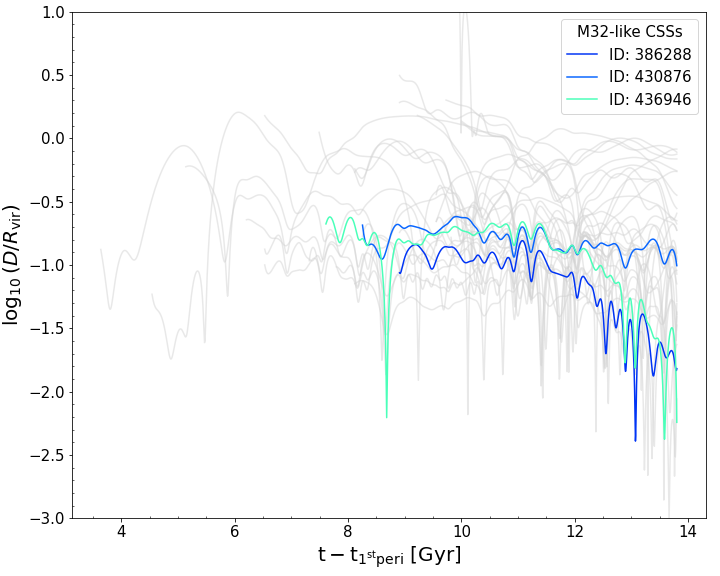

In [24]:
x_start = 2
dex = 0.55

CSSs3 = sns.load_dataset('CSSs6',data_home='/home/bianyuan/workspace/data',cache=True)

# filter_condition_TS = np.array(CSSs3['Form_Type']) == 'Tidal Stripping'
# filter_condition_BSF = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation')
filter_condition_TS = (np.array(CSSs3['Form_Type']) == 'Tidal Stripping')
filter_condition_BSF = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation') & (np.array(CSSs3['Orbit_Type']) == 'chaotic')
filter_condition_TSBSF = (np.array(CSSs3['Form_Type']) == 'TS+BSF')

# filtered_ids = np.concatenate((np.array(CSSs3['ID'])[filter_condition_BSF],np.array([275692,436946])),axis=0)

filtered_ids = np.array(CSSs3['ID'])[filter_condition_BSF]

file_paths = {
    'MRI_path': '/home/bianyuan/workspace/data/combine_connect_snap/MRI_mergertree_evo_properties_3.hdf5',
    'MRO_path': '/home/bianyuan/workspace/data/combine_connect_snap/MRO_mergertree_evo_properties_3.hdf5'
}

highlighted_ids = [386288, 414930, 430876, 436946, 448833, 475019]

# 自定义颜色循环
warm_colors = [(246/255,1/255,1/255), (133/255,4/255,2/255), (254/255,101/255,4/255), (254/255,215/255,7/255), (186/255,252/255,70/255)]
cold_colors = [(0/255,52/255,245/255), (9/255,102/255,255/255), (74/255,255/255,185/255), (17/255,214/255,255/255), (0/255,24/255,134/255)]

# 设置颜色循环
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cold_colors)

fig, axs = plt.subplots(1, 1, sharex=True, figsize=(10, 8))  # Adjusted subplot size
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.98, top=0.98, wspace=0.23, hspace=0.06)

# 对于每个HDF5文件
for model_name, file_path in file_paths.items():
    with h5py.File(file_path, 'r') as hdf_file:
        # 对于每个筛选出的星系ID
        for group_name in tqdm(filtered_ids, desc=f"Processing {model_name}"):
            group_name_str = str(group_name)
            if group_name_str in hdf_file:
                group = hdf_file[group_name_str]
                numbers = np.array(group['Number'])
                snaps = np.array(group['Snap'])  # Assuming Snap data is always available

                x = np.array(group['x'])
                y = np.array(group['y'])
                z = np.array(group['z'])
                vx = np.array(group['vx'])
                vy = np.array(group['vy'])
                vz = np.array(group['vz'])

                velocity = np.sqrt(vx**2+vy**2+vz**2)
                Rvir = np.array(group['Rvir'])
                dist = np.sqrt(x**2+y**2+z**2)
                dist_normalized = dist/Rvir[0]

                indices = (numbers > 150) & (dist_normalized > 0)

                times = np.array(FT(redshift_snapshot(np.array(group['Snap']))))

                times = times[indices][::-1]

                dist_normalized = dist_normalized[indices][::-1]

                velocity = velocity[indices][::-1]

                pericenter_index = find_periapsis_indices(dist_normalized, velocity, Rvir[-1])

                x = x[indices][::-1]
                y = y[indices][::-1]
                z = z[indices][::-1]
                Rvir = Rvir[indices][::-1]

                # Smooth trajectory and times
                smooth_x, smooth_y, smooth_z, smooth_times = smooth_trajectory_3d(x, y, z, times)

                # Log distance for plotting
                smoothed_distance_log = np.log10(np.sqrt(smooth_x**2 + smooth_y**2 + smooth_z**2) / Rvir[-1])

                if pericenter_index:
                    first_pericenter_index = pericenter_index[0]

                    snaps_filtered = snaps[indices]
                    label_str = f"ID: {group_name}"  # 生成标签字符串
                    if int(group_name_str) in highlighted_ids:
                        if group_name_str == '448833':
                            axs.plot(smooth_times, smoothed_distance_log, linewidth=6, color=(74/255,255/255,185/255), alpha=0.2, zorder=399)  # 无图例的轮廓线
                            axs.plot(smooth_times, smoothed_distance_log, label=label_str, linewidth=2, zorder=400)  # 原始线条
                            cmap = cm.get_cmap('Spectral')
                            # 定义要绘制的索引列表
                            lists = [64, 62, 61, 60, 59]
                            # 生成归一化的颜色值，范围从0到1
                            normalized_colors = np.linspace(0, 1, len(lists))

                            # # 在主循环中使用这个函数
                            # snap_times, interpolated_dists = get_interpolated_snap_values([64, 62, 61, 60, 59], times, smooth_times, dist_normalized)

                            # cmap = cm.get_cmap('Spectral')
                            # normalized_colors = np.linspace(0, 1, len(snap_times))

                            # for snap_time, interp_dist, color_val in zip(snap_times, interpolated_dists, normalized_colors):
                            #     color = cmap(color_val)
                            #     axs.scatter(snap_time - smooth_times[first_pericenter_index], np.log10(interp_dist), marker='*', s=200, color=color, edgecolor='white', zorder=401)

                            # 绘制散点，为每个散点使用colormap上的颜色
                            for i, color_val in zip(lists, normalized_colors):
                                color = cmap(color_val)  # 从colormap中获取颜色
                                axs.scatter(FT(redshift_snapshot(i)),
                                            np.log10(dist_normalized[::-1][np.where(np.array(group['Snap']) == i)]),
                                            marker='*', s=200, color=color, edgecolor='white', zorder=401)
                        else:
                            axs.plot(smooth_times, smoothed_distance_log, label=label_str, zorder=200)
                    else:
                        if group_name_str in ['63931','63950']:
                            axs.plot(smooth_times, smoothed_distance_log, color='lightgrey', alpha=0.5)
                        elif group_name_str in ['289414','294895']:
                            axs.plot(smooth_times, smoothed_distance_log, color='lightgrey', alpha=0.5)
                        else:
                            axs.plot(smooth_times, smoothed_distance_log, color='lightgrey', alpha=0.5)

                    # axs.axvline(x=0, color='black', linewidth=2, linestyle='--') 
                    axs.tick_params(axis='x', which='both', labelsize=15)
                    axs.tick_params(axis='y', which='both', labelsize=15)
                    # axs.set_xlim(-3,10)
                    axs.set_ylim(-3,1)
                    axs.set_xlabel(r'$\mathrm{t-t_{1^{st}peri}\ [Gyr]}$',fontsize=20)
                    axs.set_ylabel(r'$\log_{10}(D / R_{\mathrm{vir}})$', fontsize=20)
                    axs.minorticks_on()
                    axs.tick_params(axis='both', which='minor', direction='in', labelbottom=False, labelleft=False)
                    legend = axs.legend(loc='upper right', fontsize=15)
                    legend.set_title('M32-like CSSs', prop={'size': 15})  # 使用具体数值设置大小
                # plt.savefig('/home/bianyuan/workspace/pic/Evolution/BSF_dis_evo.pdf')
                plt.savefig('/home/bianyuan/workspace/pic/Evolution/BSF_dis_evo_chaotic.pdf')

Processing MRI_path:   0%|          | 0/10 [00:00<?, ?it/s]

Processing MRO_path: 100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


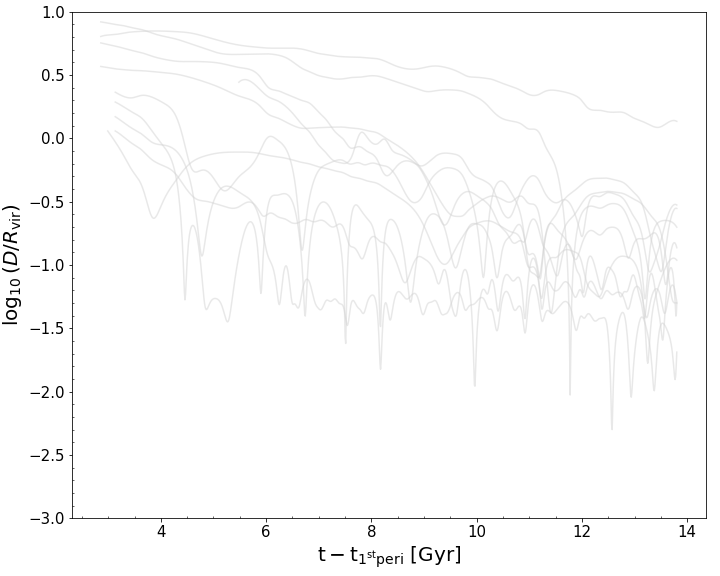

In [19]:
x_start = 2
dex = 0.55

CSSs3 = sns.load_dataset('CSSs6',data_home='/home/bianyuan/workspace/data',cache=True)

# filter_condition_TS = np.array(CSSs3['Form_Type']) == 'Tidal Stripping'
# filter_condition_BSF = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation')
filter_condition_TS = (np.array(CSSs3['Form_Type']) == 'Tidal Stripping') & (np.array(CSSs3['Orbit_Type']) == 'chaotic')
filter_condition_BSF = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation') & (np.array(CSSs3['Orbit_Type']) == 'chaotic')
filter_condition_TSBSF = (np.array(CSSs3['Form_Type']) == 'TS+BSF')

# filtered_ids = np.concatenate((np.array(CSSs3['ID'])[filter_condition_BSF],np.array([275692,436946])),axis=0)

filtered_ids = np.array(CSSs3['ID'])[filter_condition_TS]

file_paths = {
    'MRI_path': '/home/bianyuan/workspace/data/combine_connect_snap/MRI_mergertree_evo_properties_3.hdf5',
    'MRO_path': '/home/bianyuan/workspace/data/combine_connect_snap/MRO_mergertree_evo_properties_3.hdf5'
}

highlighted_ids = [386288, 414930, 430876, 436946, 448833, 475019]

# 自定义颜色循环
warm_colors = [(246/255,1/255,1/255), (133/255,4/255,2/255), (254/255,101/255,4/255), (254/255,215/255,7/255), (186/255,252/255,70/255)]
cold_colors = [(0/255,52/255,245/255), (9/255,102/255,255/255), (17/255,214/255,255/255), (74/255,255/255,185/255), (0/255,24/255,134/255)]

# 设置颜色循环
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=warm_colors)

fig, axs = plt.subplots(1, 1, sharex=True, figsize=(10, 8))  # Adjusted subplot size
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.98, top=0.98, wspace=0.23, hspace=0.06)

# 对于每个HDF5文件
for model_name, file_path in file_paths.items():
    with h5py.File(file_path, 'r') as hdf_file:
        # 对于每个筛选出的星系ID
        for group_name in tqdm(filtered_ids, desc=f"Processing {model_name}"):
            group_name_str = str(group_name)
            if group_name_str in hdf_file:
                group = hdf_file[group_name_str]
                numbers = np.array(group['Number'])
                snaps = np.array(group['Snap'])  # Assuming Snap data is always available

                x = np.array(group['x'])
                y = np.array(group['y'])
                z = np.array(group['z'])
                vx = np.array(group['vx'])
                vy = np.array(group['vy'])
                vz = np.array(group['vz'])

                velocity = np.sqrt(vx**2+vy**2+vz**2)
                Rvir = np.array(group['Rvir'])
                dist = np.sqrt(x**2+y**2+z**2)
                dist_normalized = dist/Rvir[0]

                indices = (numbers > 150) & (dist_normalized > 0)

                times = np.array(FT(redshift_snapshot(np.array(group['Snap']))))

                times = times[indices][::-1]

                dist_normalized = dist_normalized[indices][::-1]

                velocity = velocity[indices][::-1]

                pericenter_index = find_periapsis_indices(dist_normalized, velocity, Rvir[-1])

                x = x[indices][::-1]
                y = y[indices][::-1]
                z = z[indices][::-1]
                Rvir = Rvir[indices][::-1]

                # Smooth trajectory and times
                smooth_x, smooth_y, smooth_z, smooth_times = smooth_trajectory_3d(x, y, z, times)

                # Log distance for plotting
                smoothed_distance_log = np.log10(np.sqrt(smooth_x**2 + smooth_y**2 + smooth_z**2) / Rvir[-1])

                if pericenter_index:
                    first_pericenter_index = pericenter_index[0]

                    snaps_filtered = snaps[indices]
                    label_str = f"ID: {group_name}"  # 生成标签字符串
                    if int(group_name_str) in highlighted_ids:
                        if group_name_str == '448833':
                            axs.plot(smooth_times, smoothed_distance_log, linewidth=6, color=(74/255,255/255,185/255), alpha=0.2, zorder=399)  # 无图例的轮廓线
                            axs.plot(smooth_times, smoothed_distance_log, label=label_str, linewidth=2, zorder=400)  # 原始线条
                            cmap = cm.get_cmap('Spectral')
                            # 定义要绘制的索引列表
                            lists = [64, 62, 61, 60, 59]
                            # 生成归一化的颜色值，范围从0到1
                            normalized_colors = np.linspace(0, 1, len(lists))

                            # # 在主循环中使用这个函数
                            # snap_times, interpolated_dists = get_interpolated_snap_values([64, 62, 61, 60, 59], times, smooth_times, dist_normalized)

                            # cmap = cm.get_cmap('Spectral')
                            # normalized_colors = np.linspace(0, 1, len(snap_times))

                            # for snap_time, interp_dist, color_val in zip(snap_times, interpolated_dists, normalized_colors):
                            #     color = cmap(color_val)
                            #     axs.scatter(snap_time - smooth_times[first_pericenter_index], np.log10(interp_dist), marker='*', s=200, color=color, edgecolor='white', zorder=401)

                            # 绘制散点，为每个散点使用colormap上的颜色
                            for i, color_val in zip(lists, normalized_colors):
                                color = cmap(color_val)  # 从colormap中获取颜色
                                axs.scatter(FT(redshift_snapshot(i)),
                                            np.log10(dist_normalized[::-1][np.where(np.array(group['Snap']) == i)]),
                                            marker='*', s=200, color=color, edgecolor='white', zorder=401)
                        else:
                            axs.plot(smooth_times, smoothed_distance_log, label=label_str, zorder=200)
                    else:
                        if group_name_str in ['63931','63950']:
                            axs.plot(smooth_times, smoothed_distance_log, color='lightgrey', alpha=0.5)
                        elif group_name_str in ['289414','294895']:
                            axs.plot(smooth_times, smoothed_distance_log, color='lightgrey', alpha=0.5)
                        else:
                            axs.plot(smooth_times, smoothed_distance_log, color='lightgrey', alpha=0.5)

                    # axs.axvline(x=0, color='black', linewidth=2, linestyle='--') 
                    axs.tick_params(axis='x', which='both', labelsize=15)
                    axs.tick_params(axis='y', which='both', labelsize=15)
                    # axs.set_xlim(-3,10)
                    axs.set_ylim(-3,1)
                    axs.set_xlabel(r'$\mathrm{t-t_{1^{st}peri}\ [Gyr]}$',fontsize=20)
                    axs.set_ylabel(r'$\log_{10}(D / R_{\mathrm{vir}})$', fontsize=20)
                    axs.minorticks_on()
                    axs.tick_params(axis='both', which='minor', direction='in', labelbottom=False, labelleft=False)
                    # legend = axs.legend(loc='upper right', fontsize=15)
                    # legend.set_title('M32-like CSSs', prop={'size': 15})  # 使用具体数值设置大小
                plt.savefig('/home/bianyuan/workspace/pic/Evolution/TS_dis_evo_chaotic.pdf')

Processing MRI_path:   0%|          | 0/33 [00:00<?, ?it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Processing MRI_path:  18%|█▊        | 6/33 [00:00<00:02, 11.56it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Processing MRI_path:  30%|███       | 10/33 [00:01<00:02,  9.90it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Processing MRO_path: 100%|██████████| 33/33 [00:01<00:00, 32.92it/s]


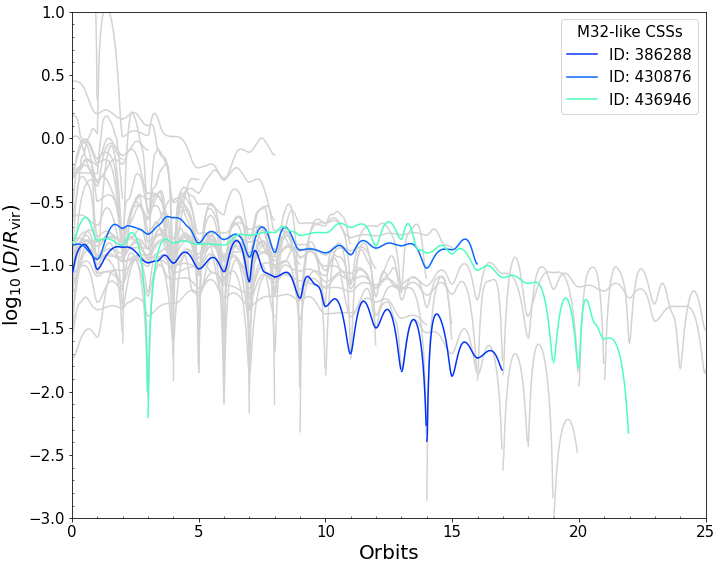

In [22]:
# BSF_orbit

x_start = 2
dex = 0.55

CSSs3 = sns.load_dataset('CSSs6',data_home='/home/bianyuan/workspace/data',cache=True)

# filter_condition_TS = np.array(CSSs3['Form_Type']) == 'Tidal Stripping'
# filter_condition_BSF = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation')
filter_condition_TS = (np.array(CSSs3['Form_Type']) == 'Tidal Stripping')
filter_condition_BSF = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation') & (np.array(CSSs3['Orbit_Type']) == 'chaotic')
filter_condition_TSBSF = (np.array(CSSs3['Form_Type']) == 'TS+BSF')

# filtered_ids = np.concatenate((np.array(CSSs3['ID'])[filter_condition_BSF],np.array([275692,436946])),axis=0)

filtered_ids = np.array(CSSs3['ID'])[filter_condition_BSF]

file_paths = {
    'MRI_path': '/home/bianyuan/workspace/data/combine_connect_snap/MRI_mergertree_evo_properties_3.hdf5',
    'MRO_path': '/home/bianyuan/workspace/data/combine_connect_snap/MRO_mergertree_evo_properties_3.hdf5'
}

highlighted_ids = [386288, 414930, 430876, 436946, 448833, 475019]

# 自定义颜色循环
warm_colors = [(246/255,1/255,1/255), (133/255,4/255,2/255), (254/255,101/255,4/255), (254/255,215/255,7/255), (186/255,252/255,70/255)]
cold_colors = [(0/255,52/255,245/255), (9/255,102/255,255/255), (17/255,214/255,255/255), (74/255,255/255,185/255), (0/255,24/255,134/255)]

# 设置颜色循环
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cold_colors)

fig, axs = plt.subplots(1, 1, sharex=True, figsize=(10, 8))  # Adjusted subplot size
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.98, top=0.98, wspace=0.23, hspace=0.06)

# 对于每个HDF5文件
for model_name, file_path in file_paths.items():
    with h5py.File(file_path, 'r') as hdf_file:
        # 对于每个筛选出的星系ID
        for group_name in tqdm(filtered_ids, desc=f"Processing {model_name}"):
            group_name_str = str(group_name)
            if group_name_str in hdf_file:
                group = hdf_file[group_name_str]
                numbers = np.array(group['Number'])
                snaps = np.array(group['Snap'])  # Assuming Snap data is always available

                x = np.array(group['x'])
                y = np.array(group['y'])
                z = np.array(group['z'])
                vx = np.array(group['vx'])
                vy = np.array(group['vy'])
                vz = np.array(group['vz'])

                velocity = np.sqrt(vx**2+vy**2+vz**2)
                Rvir = np.array(group['Rvir'])
                dist = np.sqrt(x**2+y**2+z**2)
                dist_normalized = dist/Rvir[0]

                indices = (numbers > 150) & (dist_normalized > 0)

                times = np.array(FT(redshift_snapshot(np.array(group['Snap']))))

                times = times[indices][::-1]

                dist_normalized = dist_normalized[indices][::-1]

                velocity = velocity[indices][::-1]

                # pericenter_index = find_periapsis_indices(dist_normalized, velocity, Rvir[-1])

                x = x[indices][::-1]
                y = y[indices][::-1]
                z = z[indices][::-1]
                Rvir = Rvir[indices][::-1]

                # Smooth trajectory and times
                smooth_x, smooth_y, smooth_z, smooth_times = smooth_trajectory_3d(x, y, z, times)

                # Log distance for plotting
                smoothed_distance = np.sqrt(smooth_x**2 + smooth_y**2 + smooth_z**2) / Rvir[-1]
                smoothed_distance_log = np.log10(np.sqrt(smooth_x**2 + smooth_y**2 + smooth_z**2) / Rvir[-1])

                # peri_times = smooth_times[pericenter_index]  # 使用平滑后的时间获取近心点的时间
                # orbit_durations = np.diff(peri_times, prepend=peri_times[0])

                # # 初始化一个数组来保存每个点的轨道进度
                # orbit_progress = np.zeros_like(smooth_times)

                # # 为每个点计算其在当前轨道中的进度
                # for i in range(len(pericenter_index)):
                #     start_idx = pericenter_index[i]
                #     if i < len(pericenter_index) - 1:
                #         end_idx = pericenter_index[i + 1]
                #     else:
                #         end_idx = len(smooth_times)  # 最后一个周期可能需要特殊处理
                #     current_orbit_duration = orbit_durations[i]
                #     orbit_progress[start_idx:end_idx] = (smooth_times[start_idx:end_idx] - smooth_times[start_idx]) / current_orbit_duration

                pericenter_index = find_periapsis_indices(smoothed_distance, velocity, Rvir[-1])

                # 计算轨道进度
                orbit_progress = np.zeros_like(smooth_times)
                for i in range(len(pericenter_index)-1):
                    start_idx = pericenter_index[i]
                    end_idx = pericenter_index[i + 1]
                    duration = smooth_times[end_idx] - smooth_times[start_idx]
                    orbit_progress[start_idx:end_idx] = i + (smooth_times[start_idx:end_idx] - smooth_times[start_idx]) / duration

                if pericenter_index:
                    first_pericenter_index = pericenter_index[0]

                    snaps_filtered = snaps[indices]
                    label_str = f"ID: {group_name}"  # 生成标签字符串
                    if int(group_name_str) in highlighted_ids:
                        if group_name_str == '448833':
                            # 只绘制每个近心点之间的部分
                            for i in range(len(pericenter_index)-1):
                                start_idx = pericenter_index[i]
                                end_idx = pericenter_index[i + 1]
                                # 绘制当前轨道周期
                                axs.plot(orbit_progress[start_idx:end_idx], smoothed_distance_log[start_idx:end_idx], color=(17/255,214/255,255/255), label=label_str if i == 0 else "", zorder=399)

                            # axs.plot(orbit_progress, smoothed_distance_log, linewidth=6, color=(74/255,255/255,185/255), alpha=0.2, zorder=399)  # 无图例的轮廓线
                            # axs.plot(orbit_progress, smoothed_distance_log, label=label_str, linewidth=2, zorder=400)  # 原始线条
                        elif group_name_str == '386288':
                            # axs.plot(orbit_progress, smoothed_distance_log, label=label_str, zorder=200)
                            for i in range(len(pericenter_index)-1):
                                start_idx = pericenter_index[i]
                                end_idx = pericenter_index[i + 1]
                                # 绘制当前轨道周期
                                axs.plot(orbit_progress[start_idx:end_idx], smoothed_distance_log[start_idx:end_idx], color=(0/255,52/255,245/255), label=label_str if i == 0 else "", zorder=200)
                        elif group_name_str == '430876':
                            # axs.plot(orbit_progress, smoothed_distance_log, label=label_str, zorder=200)
                            for i in range(len(pericenter_index)-1):
                                start_idx = pericenter_index[i]
                                end_idx = pericenter_index[i + 1]
                                # 绘制当前轨道周期
                                axs.plot(orbit_progress[start_idx:end_idx], smoothed_distance_log[start_idx:end_idx], color=(9/255,102/255,255/255), label=label_str if i == 0 else "", zorder=200)
                        elif group_name_str == '436946':
                            # axs.plot(orbit_progress, smoothed_distance_log, label=label_str, zorder=200)
                            for i in range(len(pericenter_index)-1):
                                start_idx = pericenter_index[i]
                                end_idx = pericenter_index[i + 1]
                                # 绘制当前轨道周期
                                axs.plot(orbit_progress[start_idx:end_idx], smoothed_distance_log[start_idx:end_idx], color=(74/255,255/255,185/255), label=label_str if i == 0 else "", zorder=200)
                        
                    else:
                        if group_name_str in ['63931','63950']:
                            # axs.plot(orbit_progress, smoothed_distance_log, color='lightgrey', alpha=0.5)
                            for i in range(len(pericenter_index)-1):
                                start_idx = pericenter_index[i]
                                end_idx = pericenter_index[i + 1]
                                # 绘制当前轨道周期
                                axs.plot(orbit_progress[start_idx:end_idx], smoothed_distance_log[start_idx:end_idx], color='lightgrey')
                        elif group_name_str in ['289414','294895']:
                            # axs.plot(orbit_progress, smoothed_distance_log, color='lightgrey', alpha=0.5)
                            for i in range(len(pericenter_index)-1):
                                start_idx = pericenter_index[i]
                                end_idx = pericenter_index[i + 1]
                                # 绘制当前轨道周期
                                axs.plot(orbit_progress[start_idx:end_idx], smoothed_distance_log[start_idx:end_idx], color='lightgrey')
                        else:
                            # axs.plot(orbit_progress, smoothed_distance_log, color='lightgrey', alpha=0.5)
                            for i in range(len(pericenter_index)-1):
                                start_idx = pericenter_index[i]
                                end_idx = pericenter_index[i + 1]
                                # 绘制当前轨道周期
                                axs.plot(orbit_progress[start_idx:end_idx], smoothed_distance_log[start_idx:end_idx], color='lightgrey')

                    # axs.axvline(x=0, color='black', linewidth=2, linestyle='--') 
                    axs.tick_params(axis='x', which='both', labelsize=15)
                    axs.tick_params(axis='y', which='both', labelsize=15)
                    axs.set_xlim(0,25)
                    axs.set_ylim(-3,1)
                    axs.set_xlabel('Orbits',fontsize=20)
                    axs.set_ylabel(r'$\log_{10}(D / R_{\mathrm{vir}})$', fontsize=20)
                    axs.minorticks_on()
                    axs.tick_params(axis='both', which='minor', direction='in', labelbottom=False, labelleft=False)
                    legend = axs.legend(loc='upper right', fontsize=15)
                    legend.set_title('M32-like CSSs', prop={'size': 15})  # 使用具体数值设置大小
                # plt.savefig('/home/bianyuan/workspace/pic/Evolution/BSF_dis_evo_periodic.pdf')
                plt.savefig('/home/bianyuan/workspace/pic/Evolution/BSF_dis_evo_chaotic.pdf')

Processing MRI_path:   0%|          | 0/53 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Processing MRI_path:  53%|█████▎    | 28/53 [00:00<00:00, 143.44it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Processing MRI_path:  81%|████████  | 43/53 [00:00<00:00, 82.13it/s] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label

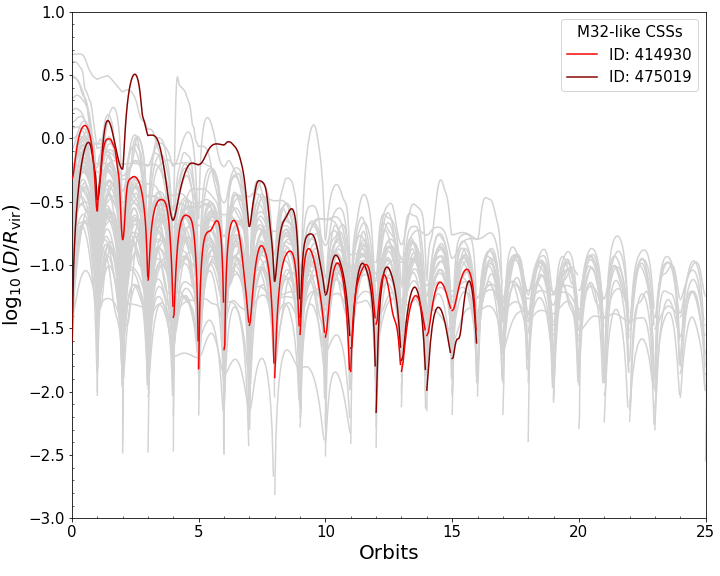

In [23]:
# TS_orbit

x_start = 2
dex = 0.55

CSSs3 = sns.load_dataset('CSSs6',data_home='/home/bianyuan/workspace/data',cache=True)

# filter_condition_TS = np.array(CSSs3['Form_Type']) == 'Tidal Stripping'
# filter_condition_BSF = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation')
filter_condition_TS = (np.array(CSSs3['Form_Type']) == 'Tidal Stripping')
filter_condition_BSF = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation') & (np.array(CSSs3['Orbit_Type']) == 'periodic')
filter_condition_TSBSF = (np.array(CSSs3['Form_Type']) == 'TS+BSF')

# filtered_ids = np.concatenate((np.array(CSSs3['ID'])[filter_condition_BSF],np.array([275692,436946])),axis=0)

filtered_ids = np.array(CSSs3['ID'])[filter_condition_TS]

file_paths = {
    'MRI_path': '/home/bianyuan/workspace/data/combine_connect_snap/MRI_mergertree_evo_properties_3.hdf5',
    'MRO_path': '/home/bianyuan/workspace/data/combine_connect_snap/MRO_mergertree_evo_properties_3.hdf5'
}

highlighted_ids = [386288, 414930, 430876, 436946, 448833, 475019]

# 自定义颜色循环
warm_colors = [(246/255,1/255,1/255), (133/255,4/255,2/255), (254/255,101/255,4/255), (254/255,215/255,7/255), (186/255,252/255,70/255)]
cold_colors = [(0/255,52/255,245/255), (9/255,102/255,255/255), (17/255,214/255,255/255), (74/255,255/255,185/255), (0/255,24/255,134/255)]

# 设置颜色循环
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=warm_colors)

fig, axs = plt.subplots(1, 1, sharex=True, figsize=(10, 8))  # Adjusted subplot size
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.98, top=0.98, wspace=0.23, hspace=0.06)

# 对于每个HDF5文件
for model_name, file_path in file_paths.items():
    with h5py.File(file_path, 'r') as hdf_file:
        # 对于每个筛选出的星系ID
        for group_name in tqdm(filtered_ids, desc=f"Processing {model_name}"):
            group_name_str = str(group_name)
            if group_name_str in hdf_file:
                group = hdf_file[group_name_str]
                numbers = np.array(group['Number'])
                snaps = np.array(group['Snap'])  # Assuming Snap data is always available

                x = np.array(group['x'])
                y = np.array(group['y'])
                z = np.array(group['z'])
                vx = np.array(group['vx'])
                vy = np.array(group['vy'])
                vz = np.array(group['vz'])

                velocity = np.sqrt(vx**2+vy**2+vz**2)
                Rvir = np.array(group['Rvir'])
                dist = np.sqrt(x**2+y**2+z**2)
                dist_normalized = dist/Rvir[0]

                indices = (numbers > 150) & (dist_normalized > 0)

                times = np.array(FT(redshift_snapshot(np.array(group['Snap']))))

                times = times[indices][::-1]

                dist_normalized = dist_normalized[indices][::-1]

                velocity = velocity[indices][::-1]

                # pericenter_index = find_periapsis_indices(dist_normalized, velocity, Rvir[-1])

                x = x[indices][::-1]
                y = y[indices][::-1]
                z = z[indices][::-1]
                Rvir = Rvir[indices][::-1]

                # Smooth trajectory and times
                smooth_x, smooth_y, smooth_z, smooth_times = smooth_trajectory_3d(x, y, z, times)

                # Log distance for plotting
                smoothed_distance = np.sqrt(smooth_x**2 + smooth_y**2 + smooth_z**2) / Rvir[-1]
                smoothed_distance_log = np.log10(np.sqrt(smooth_x**2 + smooth_y**2 + smooth_z**2) / Rvir[-1])

                # peri_times = smooth_times[pericenter_index]  # 使用平滑后的时间获取近心点的时间
                # orbit_durations = np.diff(peri_times, prepend=peri_times[0])

                # # 初始化一个数组来保存每个点的轨道进度
                # orbit_progress = np.zeros_like(smooth_times)

                # # 为每个点计算其在当前轨道中的进度
                # for i in range(len(pericenter_index)):
                #     start_idx = pericenter_index[i]
                #     if i < len(pericenter_index) - 1:
                #         end_idx = pericenter_index[i + 1]
                #     else:
                #         end_idx = len(smooth_times)  # 最后一个周期可能需要特殊处理
                #     current_orbit_duration = orbit_durations[i]
                #     orbit_progress[start_idx:end_idx] = (smooth_times[start_idx:end_idx] - smooth_times[start_idx]) / current_orbit_duration

                pericenter_index = find_periapsis_indices(smoothed_distance, velocity, Rvir[-1])

                # 计算轨道进度
                orbit_progress = np.zeros_like(smooth_times)
                for i in range(len(pericenter_index)-1):
                    start_idx = pericenter_index[i]
                    end_idx = pericenter_index[i + 1]
                    duration = smooth_times[end_idx] - smooth_times[start_idx]
                    orbit_progress[start_idx:end_idx] = i + (smooth_times[start_idx:end_idx] - smooth_times[start_idx]) / duration

                if pericenter_index:
                    first_pericenter_index = pericenter_index[0]

                    snaps_filtered = snaps[indices]
                    label_str = f"ID: {group_name}"  # 生成标签字符串
                    if int(group_name_str) in highlighted_ids:
                        if group_name_str == '414930':
                            # 只绘制每个近心点之间的部分
                            for i in range(len(pericenter_index)-1):
                                start_idx = pericenter_index[i]
                                end_idx = pericenter_index[i + 1]
                                # 绘制当前轨道周期
                                axs.plot(orbit_progress[start_idx:end_idx], smoothed_distance_log[start_idx:end_idx], color=(246/255,1/255,1/255), label=label_str if i == 0 else "", zorder=399)

                            # axs.plot(orbit_progress, smoothed_distance_log, linewidth=6, color=(74/255,255/255,185/255), alpha=0.2, zorder=399)  # 无图例的轮廓线
                            # axs.plot(orbit_progress, smoothed_distance_log, label=label_str, linewidth=2, zorder=400)  # 原始线条
                        elif group_name_str == '475019':
                            # axs.plot(orbit_progress, smoothed_distance_log, label=label_str, zorder=200)
                            for i in range(len(pericenter_index)-1):
                                start_idx = pericenter_index[i]
                                end_idx = pericenter_index[i + 1]
                                # 绘制当前轨道周期
                                axs.plot(orbit_progress[start_idx:end_idx], smoothed_distance_log[start_idx:end_idx], color=(133/255,4/255,2/255), label=label_str if i == 0 else "", zorder=200)
                        
                    else:
                        for i in range(len(pericenter_index)-1):
                            start_idx = pericenter_index[i]
                            end_idx = pericenter_index[i + 1]
                            # 绘制当前轨道周期
                            axs.plot(orbit_progress[start_idx:end_idx], smoothed_distance_log[start_idx:end_idx], color='lightgrey')

                    # axs.axvline(x=0, color='black', linewidth=2, linestyle='--') 
                    axs.tick_params(axis='x', which='both', labelsize=15)
                    axs.tick_params(axis='y', which='both', labelsize=15)
                    axs.set_xlim(0,25)
                    axs.set_ylim(-3,1)
                    axs.set_xlabel('Orbits',fontsize=20)
                    axs.set_ylabel(r'$\log_{10}(D / R_{\mathrm{vir}})$', fontsize=20)
                    axs.minorticks_on()
                    axs.tick_params(axis='both', which='minor', direction='in', labelbottom=False, labelleft=False)
                    legend = axs.legend(loc='upper right', fontsize=15)
                    legend.set_title('M32-like CSSs', prop={'size': 15})  # 使用具体数值设置大小
                plt.savefig('/home/bianyuan/workspace/pic/Evolution/TS_dis_evo_periodic.pdf')

Processing: 0it [00:00, ?it/s]

Processing: 1185it [18:11,  1.09it/s]


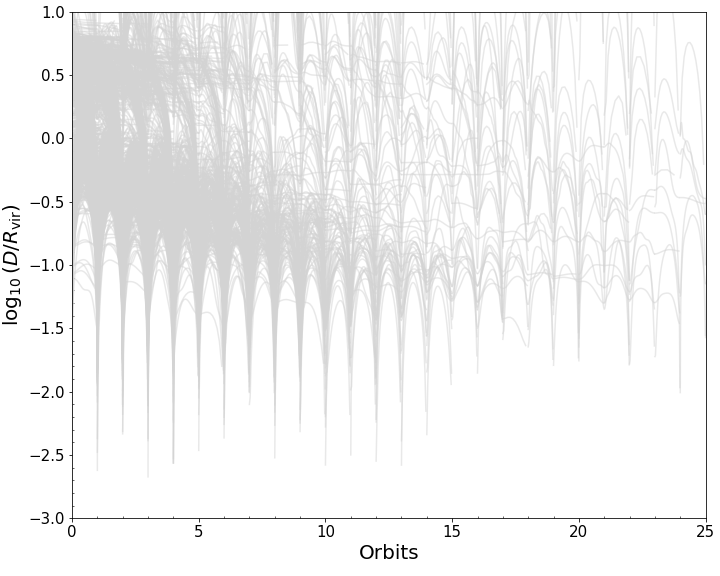

In [5]:
# ND_dis

h = 0.6774

ND = sns.load_dataset('Normal_Dwarf_1',data_home='/home/bianyuan/workspace/data',cache=True)

# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=warm_colors)

fig, axs = plt.subplots(1, 1, sharex=True, figsize=(10, 8))  # Adjusted subplot size
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.98, top=0.98, wspace=0.23, hspace=0.06)

for (i, j) in tqdm(zip(np.array(ND['ID'])[np.where(((ND['Distance']) > 0) & ((ND['Distance']) < 1) & (np.log10(ND['Star mass']) < 9.5))], np.array(ND['HostID'])[np.where(((ND['Distance']) > 0) & ((ND['Distance']) < 1) & (np.log10(ND['Star mass']) < 9.5))]), desc='Processing'):
    RowNum, _, _ = il.sublink.treeOffsets(basePath, 99, i, "SubLink")

    if RowNum < 1:
        continue
    else:
        try:
            fields = ['SubfindID','SubhaloGrNr','SubhaloVel','SubhaloMassInHalfRadType','SnapNum','SubhaloStarMetallicity',
        'SubhaloSFRinHalfRad','SubhaloHalfmassRadType',
        'SubhaloStarMetallicityHalfRad','GroupFirstSub',
        'SubhaloMassType','SubhaloSFR','SubhaloHalfmassRadType',
        'SubhaloStarMetallicity','SubhaloWindMass','SubhaloSpin',
        'SubhaloMass','SubhaloIDRaw','SubhaloPos','SubhaloStarMetalFractions']
            sat_idx_map = {}
            velocity = []
            distances = []
            snap = []
            x, y, z = [], [], []
            tree = il.sublink.loadTree(basePath,99,i,fields=fields,onlyMPB=True)
            host_tree = il.sublink.loadTree(basePath,99,j,fields=fields,onlyMPB=True)
            haloID = tree['SubhaloGrNr'][0]
            halo = il.groupcat.loadSingle(basePath, 99, haloID=haloID)
            sat_snap = tree['SnapNum']
            cen_snap = host_tree['SnapNum']
            M200 = halo['Group_M_Crit200'] * 1e10 / h
            Rvir = halo['Group_R_Crit200'] / h

            G = 4.302e-6

            V200 = np.sqrt(G*M200/Rvir)

            for ii, snap_num in enumerate(cen_snap):
                sat_idx = np.where(sat_snap == snap_num)[0]
                if len(sat_idx) > 0:
                    sat_idx_map[ii] = sat_idx[0]
            for cen_idx, sat_idx in sat_idx_map.items():
                cen_pos = host_tree['SubhaloPos'][cen_idx]
                cen_vel = host_tree['SubhaloVel'][cen_idx]
                cen_snap = host_tree['SnapNum'][cen_idx]
                sat_pos = tree['SubhaloPos'][sat_idx]
                sat_vel = tree['SubhaloVel'][sat_idx]
                sat_snap = tree['SnapNum'][sat_idx]
                
                x.append(sat_pos[0]-cen_pos[0])
                y.append(sat_pos[1]-cen_pos[1])
                z.append(sat_pos[2]-cen_pos[2])
                snap.append(sat_snap)

                distances.append(np.sqrt(np.sum((sat_pos - cen_pos)**2)))
                dist_normalized = distances/Rvir
                velocity.append(np.sqrt(np.sum((sat_vel - cen_vel)**2)))

            times = FT(redshift_snapshot(snap))

            times = times[::-1]

            x = x[::-1]
            y = y[::-1]
            z = z[::-1]

            x = np.array(x)
            y = np.array(y)
            z = np.array(z)
            times = np.array(times)

            # Smooth trajectory and times
            smooth_x, smooth_y, smooth_z, smooth_times = smooth_trajectory_3d(x, y, z, times)

            # Log distance for plotting
            smoothed_distance = np.sqrt(smooth_x**2 + smooth_y**2 + smooth_z**2) / Rvir
            smoothed_distance_log = np.log10(np.sqrt(smooth_x**2 + smooth_y**2 + smooth_z**2) / Rvir)

            pericenter_index = find_periapsis_indices(smoothed_distance, velocity, Rvir)

            peri_times = smooth_times[pericenter_index]  # 使用平滑后的时间获取近心点的时间

            if len(peri_times) <= 1:
                orbit_durations = np.diff(peri_times, prepend=peri_times)
            else:
                orbit_durations = np.diff(peri_times, prepend=peri_times[0])

            # 计算轨道进度
            orbit_progress = np.zeros_like(smooth_times)
            for i in range(len(pericenter_index)-1):
                start_idx = pericenter_index[i]
                end_idx = pericenter_index[i + 1]
                duration = smooth_times[end_idx] - smooth_times[start_idx]
                orbit_progress[start_idx:end_idx] = i + (smooth_times[start_idx:end_idx] - smooth_times[start_idx]) / duration

            if pericenter_index:
                first_pericenter_index = pericenter_index[0]

                for i in range(len(pericenter_index)-1):
                    start_idx = pericenter_index[i]
                    end_idx = pericenter_index[i + 1]
                    # 绘制当前轨道周期
                    axs.plot(orbit_progress[start_idx:end_idx], smoothed_distance_log[start_idx:end_idx], color='lightgrey', alpha=0.5)

                # axs.axvline(x=0, color='black', linewidth=2, linestyle='--') 
                axs.tick_params(axis='x', which='both', labelsize=15)
                axs.tick_params(axis='y', which='both', labelsize=15)
                axs.set_xlim(0,25)
                axs.set_ylim(-3,1)
                axs.set_xlabel('Orbits',fontsize=20)
                axs.set_ylabel(r'$\log_{10}(D / R_{\mathrm{vir}})$', fontsize=20)
                axs.minorticks_on()
                axs.tick_params(axis='both', which='minor', direction='in', labelbottom=False, labelleft=False)
                # legend = axs.legend(loc='upper right')
                # legend.set_title('M32-like CSSs')
        except:
            continue
        plt.savefig('/home/bianyuan/workspace/pic/Evolution/ND_dis_evo.pdf')

Processing MRI_path:   0%|          | 0/54 [00:00<?, ?it/s]/tmp/ipykernel_98147/2167628873.py:93: RuntimeWarning: divide by zero encountered in divide
  orbit_progress[start_idx:end_idx] = (smooth_times[start_idx:end_idx] - smooth_times[start_idx]) / current_orbit_duration
/tmp/ipykernel_98147/2167628873.py:93: RuntimeWarning: invalid value encountered in divide
  orbit_progress[start_idx:end_idx] = (smooth_times[start_idx:end_idx] - smooth_times[start_idx]) / current_orbit_duration
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Processing MRI_path:  54%|█████▎    | 29/54 [00:00<00:00, 128.57it/s]/tmp/ipykernel_98147/2167628873.py:93: RuntimeWarning: divide by zero encountered in divide
  orbit_progress[start_idx:end_idx] = (smooth_times[start_idx:end_idx] - smooth_times[start_idx]) / current_orbit_duration
/tmp/ipykernel_98147/2167628873.py:93: RuntimeWarning: invalid value encountered in divide
  orbit_progress[start_idx:end_idx] = (smooth_times[start_idx:end_idx] - smooth_times[start_idx]) / current_orbit_duration
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_98147/2167628873.py:93: RuntimeWarning: divide by zero encountered in divide
  orbit_progress[start_idx:end_idx] = (smooth_times[start_idx:end_idx] - smooth_times[start_idx]) / current_orbit_duration
/tmp/ipykernel_98147/2167628873.py:93: RuntimeWarning: invalid value encountered in divide
  orbit_progress[start_idx:end_idx] = (

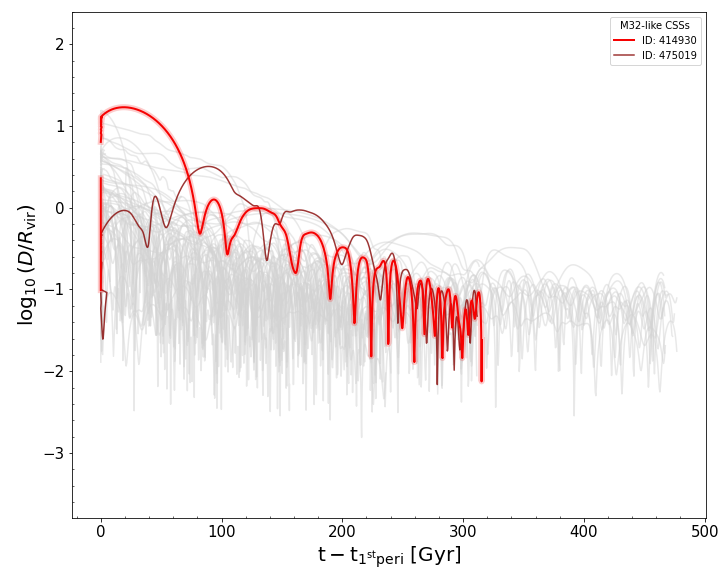

In [9]:
x_start = 2
dex = 0.55

CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)

# filter_condition_TS = np.array(CSSs3['Form_Type']) == 'Tidal Stripping'
# filter_condition_BSF = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation')
filter_condition_TS = (np.array(CSSs3['Form_Type']) == 'Tidal Stripping')
filter_condition_BSF = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation')
filter_condition_TSBSF = (np.array(CSSs3['Form_Type']) == 'TS+BSF')

# filtered_ids = np.concatenate((np.array(CSSs3['ID'])[filter_condition_BSF],np.array([275692,436946])),axis=0)

filtered_ids = np.array(CSSs3['ID'])[filter_condition_TS]

file_paths = {
    'MRI_path': '/home/bianyuan/workspace/data/combine_connect_snap/MRI_mergertree_evo_properties_3.hdf5',
    'MRO_path': '/home/bianyuan/workspace/data/combine_connect_snap/MRO_mergertree_evo_properties_3.hdf5'
}

highlighted_ids = [386288, 414930, 430876, 436946, 448833, 475019]

# 自定义颜色循环
warm_colors = [(246/255,1/255,1/255), (133/255,4/255,2/255), (254/255,101/255,4/255), (254/255,215/255,7/255), (186/255,252/255,70/255)]
cold_colors = [(0/255,52/255,245/255), (9/255,102/255,255/255), (17/255,214/255,255/255), (74/255,255/255,185/255), (0/255,24/255,134/255)]

# 设置颜色循环
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=warm_colors)

fig, axs = plt.subplots(1, 1, sharex=True, figsize=(10, 8))  # Adjusted subplot size
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.98, top=0.98, wspace=0.23, hspace=0.06)

# 对于每个HDF5文件
for model_name, file_path in file_paths.items():
    with h5py.File(file_path, 'r') as hdf_file:
        # 对于每个筛选出的星系ID
        for group_name in tqdm(filtered_ids, desc=f"Processing {model_name}"):
            group_name_str = str(group_name)
            if group_name_str in hdf_file:
                group = hdf_file[group_name_str]
                numbers = np.array(group['Number'])
                snaps = np.array(group['Snap'])  # Assuming Snap data is always available

                x = np.array(group['x'])
                y = np.array(group['y'])
                z = np.array(group['z'])
                vx = np.array(group['vx'])
                vy = np.array(group['vy'])
                vz = np.array(group['vz'])

                velocity = np.sqrt(vx**2+vy**2+vz**2)
                Rvir = np.array(group['Rvir'])
                dist = np.sqrt(x**2+y**2+z**2)
                dist_normalized = dist/Rvir[0]

                indices = (numbers > 150) & (dist_normalized > 0)

                times = np.array(FT(redshift_snapshot(np.array(group['Snap']))))

                times = times[indices][::-1]

                dist_normalized = dist_normalized[indices][::-1]

                velocity = velocity[indices][::-1]

                pericenter_index = find_periapsis_indices(dist_normalized, velocity, Rvir[-1])

                x = x[indices][::-1]
                y = y[indices][::-1]
                z = z[indices][::-1]
                Rvir = Rvir[indices][::-1]

                # Smooth trajectory and times
                smooth_x, smooth_y, smooth_z, smooth_times = smooth_trajectory_3d(x, y, z, times)

                # Log distance for plotting
                smoothed_distance_log = np.log10(np.sqrt(smooth_x**2 + smooth_y**2 + smooth_z**2) / Rvir[-1])

                peri_times = smooth_times[pericenter_index]  # 使用平滑后的时间获取近心点的时间
                orbit_durations = np.diff(peri_times, prepend=peri_times[0])

                # 初始化一个数组来保存每个点的轨道进度
                orbit_progress = np.zeros_like(smooth_times)

                # 为每个点计算其在当前轨道中的进度
                for i in range(len(pericenter_index)):
                    start_idx = pericenter_index[i]
                    if i < len(pericenter_index) - 1:
                        end_idx = pericenter_index[i + 1]
                    else:
                        end_idx = len(smooth_times)  # 最后一个周期可能需要特殊处理
                    current_orbit_duration = orbit_durations[i]
                    orbit_progress[start_idx:end_idx] = (smooth_times[start_idx:end_idx] - smooth_times[start_idx]) / current_orbit_duration

                if pericenter_index:
                    first_pericenter_index = pericenter_index[0]

                    snaps_filtered = snaps[indices]
                    label_str = f"ID: {group_name}"  # 生成标签字符串
                    if int(group_name_str) in highlighted_ids:
                        if group_name_str == '475019':
                            axs.plot(orbit_progress, smoothed_distance_log, label=label_str, alpha=0.8, zorder=200)
                        elif group_name_str == '414930':
                            axs.plot(orbit_progress, smoothed_distance_log, linewidth=6, color=(246/255,1/255,1/255), alpha=0.2, zorder=399)  # 无图例的轮廓线
                            axs.plot(orbit_progress, smoothed_distance_log, label=label_str, linewidth=2, zorder=400)  # 原始线条
                            cmap = cm.get_cmap('nipy_spectral')
                            # 定义要绘制的索引列表
                            lists = [87, 80, 73, 67, 64, 63, 61, 55, 50]
                            # 生成归一化的颜色值，范围从0到1
                            normalized_colors = np.linspace(0, 1, len(lists))
                            # 绘制散点，为每个散点使用colormap上的颜色
                            # for i, color_val in zip(lists, normalized_colors):
                            #     color = cmap(color_val)  # 从colormap中获取颜色
                            #     axs.scatter(FT(redshift_snapshot(i)) - times[first_pericenter_index],
                            #                 np.log10(dist_normalized[::-1][np.where(np.array(group['Snap']) == i)]),
                            #                 marker='*', s=200, color=color, edgecolor='white', zorder=401)
                            # for i in [87, 80, 73, 67, 64, 63, 61, 55, 50]:
                            #     axs[5].scatter(FT(redshift_snapshot(i)) - times[first_pericenter_index], ZHs[::-1][np.where(np.array(group['Snap']) == i)]-dex, marker='*',zorder=401)
                        else:
                            axs.plot(orbit_progress, smoothed_distance_log, label=label_str, zorder=200) 
                    else:
                        if group_name_str in ['548', '229996', '275568', '460736']:
                            axs.plot(orbit_progress, smoothed_distance_log, color='lightgrey', alpha=0.5)
                        elif group_name_str in ['308', '96853', '117357','198281','253938','410046']:
                            axs.plot(orbit_progress, smoothed_distance_log, color='lightgrey', alpha=0.5)
                        elif group_name_str in ['64002', '64240', '97019','185032','185068','289414','294895','428190','436968','438152','445663']:
                            axs.plot(orbit_progress, smoothed_distance_log, color='lightgrey', alpha=0.5)
                        else:
                            axs.plot(orbit_progress, smoothed_distance_log, color='lightgrey', alpha=0.5)

                    # axs.axvline(x=0, color='black', linewidth=2, linestyle='--') 
                    axs.tick_params(axis='x', which='both', labelsize=15)
                    axs.tick_params(axis='y', which='both', labelsize=15)
                    # axs.set_xlim(-3,10)
                    axs.set_ylim(-3.8,2.4)
                    axs.set_xlabel(r'$\mathrm{t-t_{1^{st}peri}\ [Gyr]}$',fontsize=20)
                    axs.set_ylabel(r'$\log_{10}(D / R_{\mathrm{vir}})$', fontsize=20)
                    axs.minorticks_on()
                    axs.tick_params(axis='both', which='minor', direction='in', labelbottom=False, labelleft=False)
                    legend = axs.legend(loc='upper right', fontsize=15)
                    legend.set_title('M32-like CSSs', prop={'size': 15})  # 使用具体数值设置大小
                plt.savefig('/home/bianyuan/workspace/pic/Evolution/TS_dis_evo.pdf')

In [10]:
h = 0.6774

ND = sns.load_dataset('Normal_Dwarf_1',data_home='/home/bianyuan/workspace/data',cache=True)

fig, axs = plt.subplots(1, 1, sharex=True, figsize=(10, 8))  # Adjusted subplot size
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.98, top=0.98, wspace=0.23, hspace=0.06)

for (i, j) in tqdm(zip(np.array(ND['ID'])[np.where(((ND['Distance']) > 0) & ((ND['Distance']) < 1) & (np.log10(ND['Star mass']) < 9.5))], np.array(ND['HostID'])[np.where(((ND['Distance']) > 0) & ((ND['Distance']) < 1) & (np.log10(ND['Star mass']) < 9.5))]), desc='Processing'):
    RowNum, _, _ = il.sublink.treeOffsets(basePath, 99, i, "SubLink")

    if RowNum < 1:
        continue
    else:
        try:
            fields = ['SubfindID','SubhaloGrNr','SubhaloVel','SubhaloMassInHalfRadType','SnapNum','SubhaloStarMetallicity',
        'SubhaloSFRinHalfRad','SubhaloHalfmassRadType',
        'SubhaloStarMetallicityHalfRad','GroupFirstSub',
        'SubhaloMassType','SubhaloSFR','SubhaloHalfmassRadType',
        'SubhaloStarMetallicity','SubhaloWindMass','SubhaloSpin',
        'SubhaloMass','SubhaloIDRaw','SubhaloPos','SubhaloStarMetalFractions']
            sat_idx_map = {}
            velocity = []
            distances = []
            snap = []
            x, y, z = [], [], []
            tree = il.sublink.loadTree(basePath,99,i,fields=fields,onlyMPB=True)
            host_tree = il.sublink.loadTree(basePath,99,j,fields=fields,onlyMPB=True)
            haloID = tree['SubhaloGrNr'][0]
            halo = il.groupcat.loadSingle(basePath, 99, haloID=haloID)
            sat_snap = tree['SnapNum']
            cen_snap = host_tree['SnapNum']
            M200 = halo['Group_M_Crit200'] * 1e10 / h
            Rvir = halo['Group_R_Crit200'] / h

            G = 4.302e-6

            V200 = np.sqrt(G*M200/Rvir)

            for ii, snap_num in enumerate(cen_snap):
                sat_idx = np.where(sat_snap == snap_num)[0]
                if len(sat_idx) > 0:
                    sat_idx_map[ii] = sat_idx[0]
            for cen_idx, sat_idx in sat_idx_map.items():
                cen_pos = host_tree['SubhaloPos'][cen_idx]
                cen_vel = host_tree['SubhaloVel'][cen_idx]
                cen_snap = host_tree['SnapNum'][cen_idx]
                sat_pos = tree['SubhaloPos'][sat_idx]
                sat_vel = tree['SubhaloVel'][sat_idx]
                sat_snap = tree['SnapNum'][sat_idx]
                
                x.append(sat_pos[0]-cen_pos[0])
                y.append(sat_pos[1]-cen_pos[1])
                z.append(sat_pos[2]-cen_pos[2])
                snap.append(sat_snap)

                distances.append(np.sqrt(np.sum((sat_pos - cen_pos)**2)))
                dist_normalized = distances/Rvir
                velocity.append(np.sqrt(np.sum((sat_vel - cen_vel)**2)))

            times = FT(redshift_snapshot(snap))

            times = times[::-1]

            pericenter_index = find_periapsis_indices(dist_normalized[::-1], velocity[::-1], Rvir)

            x = x[::-1]
            y = y[::-1]
            z = z[::-1]

            x = np.array(x)
            y = np.array(y)
            z = np.array(z)
            times = np.array(times)

            # Smooth trajectory and times
            smooth_x, smooth_y, smooth_z, smooth_times = smooth_trajectory_3d(x, y, z, times)

            # Log distance for plotting
            smoothed_distance_log = np.log10(np.sqrt(smooth_x**2 + smooth_y**2 + smooth_z**2) / Rvir)

            peri_times = smooth_times[pericenter_index]  # 使用平滑后的时间获取近心点的时间

            if len(peri_times) <= 1:
                orbit_durations = np.diff(peri_times, prepend=peri_times)
            else:
                orbit_durations = np.diff(peri_times, prepend=peri_times[0])

            # 初始化一个数组来保存每个点的轨道进度
            orbit_progress = np.zeros_like(smooth_times)

            # 为每个点计算其在当前轨道中的进度
            for i in range(len(pericenter_index)):
                start_idx = pericenter_index[i]
                if i < len(pericenter_index) - 1:
                    end_idx = pericenter_index[i + 1]
                else:
                    end_idx = len(smooth_times)  # 最后一个周期可能需要特殊处理
                current_orbit_duration = orbit_durations[i]
                orbit_progress[start_idx:end_idx] = (smooth_times[start_idx:end_idx] - smooth_times[start_idx]) / current_orbit_duration

            if pericenter_index:
                first_pericenter_index = pericenter_index[0]

                axs.plot(orbit_progress, smoothed_distance_log, alpha=0.8, zorder=200)

                # axs.axvline(x=0, color='black', linewidth=2, linestyle='--') 
                axs.tick_params(axis='x', which='both', labelsize=15)
                axs.tick_params(axis='y', which='both', labelsize=15)
                # axs.set_xlim(-3,10)
                axs.set_ylim(-3.8,2.4)
                axs.set_xlabel(r'$\mathrm{t-t_{1^{st}peri}\ [Gyr]}$',fontsize=20)
                axs.set_ylabel(r'$\log_{10}(D / R_{\mathrm{vir}})$', fontsize=20)
                axs.minorticks_on()
                axs.tick_params(axis='both', which='minor', direction='in', labelbottom=False, labelleft=False)
                # legend = axs.legend(loc='upper right')
                # legend.set_title('M32-like CSSs')
        except:
            continue
        plt.savefig('/home/bianyuan/workspace/pic/Evolution/ND_dis_evo.pdf')

Processing: 0it [00:00, ?it/s]

/tmp/ipykernel_98544/3842966284.py:99: RuntimeWarning: divide by zero encountered in divide
  orbit_progress[start_idx:end_idx] = (smooth_times[start_idx:end_idx] - smooth_times[start_idx]) / current_orbit_duration
/tmp/ipykernel_98544/3842966284.py:99: RuntimeWarning: invalid value encountered in divide
  orbit_progress[start_idx:end_idx] = (smooth_times[start_idx:end_idx] - smooth_times[start_idx]) / current_orbit_duration
Processing: 1it [00:00,  4.05it/s]/tmp/ipykernel_98544/3842966284.py:99: RuntimeWarning: divide by zero encountered in divide
  orbit_progress[start_idx:end_idx] = (smooth_times[start_idx:end_idx] - smooth_times[start_idx]) / current_orbit_duration
/tmp/ipykernel_98544/3842966284.py:99: RuntimeWarning: invalid value encountered in divide
  orbit_progress[start_idx:end_idx] = (smooth_times[start_idx:end_idx] - smooth_times[start_idx]) / current_orbit_duration
Processing: 3it [00:00,  5.36it/s]/tmp/ipykernel_98544/3842966284.py:99: RuntimeWarning: divide by zero enco

In [ ]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from tqdm import tqdm
from scipy.interpolate import interp1d
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from scipy.interpolate import UnivariateSpline
from scipy.signal import argrelextrema

def average_duplicates(times, x, y, z):
    # 获取唯一时间点及其索引
    unique_times = np.unique(times)
    new_x = np.zeros(len(unique_times))
    new_y = np.zeros(len(unique_times))
    new_z = np.zeros(len(unique_times))

    # 计算每个唯一时间点对应的坐标平均值
    for i, t in enumerate(unique_times):
        indices = np.where(times == t)
        new_x[i] = np.mean(x[indices])
        new_y[i] = np.mean(y[indices])
        new_z[i] = np.mean(z[indices])

    return unique_times, new_x, new_y, new_z

def smooth_trajectory_3d(x, y, z, times, num_points=1000):
    # 合并重复时间点
    times, x, y, z = average_duplicates(times, x, y, z)
    
    # 创建插值函数
    f_x = interp1d(times, x, kind='cubic',fill_value='constant')
    f_y = interp1d(times, y, kind='cubic',fill_value='constant')
    f_z = interp1d(times, z, kind='cubic',fill_value='constant')

    # 生成新的时间点
    new_times = np.linspace(times[0], times[-1], num_points)

    # 插值新的坐标
    new_x = f_x(new_times)
    new_y = f_y(new_times)
    new_z = f_z(new_times)

    return new_x, new_y, new_z, new_times

def remove_spikes(data, window_size=5):
    if window_size % 2 == 0:
        raise ValueError("window_size must be an odd number")

    n = len(data)
    half_window = window_size // 2
    filtered_data = np.copy(data)  # 创建数据的副本

    for i in range(half_window, n - half_window):
        # 使用当前点及其邻近点的中位数替换当前点的值
        filtered_data[i] = np.median(data[i - half_window:i + half_window + 1])

    return filtered_data

def remove_initial_spikes(data, threshold=10):
    # 找到第一个不大于阈值的值的索引
    valid_start_index = next((i for i, value in enumerate(data) if value <= threshold), None)
    
    # 如果找不到符合条件的值，意味着所有值都不需要被移除
    if valid_start_index is None:
        return data
    
    # 返回从找到的索引开始到结束的数据
    return data[valid_start_index:]

def find_periapsis_indices(distances, velocity, Rvir):
    # 找到distances中第一个小于Rvir的索引
    valid_start_index = next((i for i, value in enumerate(distances) if value < Rvir), None)
    
    if valid_start_index is None:
        return []  # 如果没有找到符合条件的索引，则返回空列表
    
    # 查找距离的局部最小点（仅在valid_start_index之后）
    local_min_indices = [i for i in range(valid_start_index + 1, len(distances) - 1) 
                         if distances[i] < distances[i - 1] and distances[i] < distances[i + 1]]
    
    local_max_indices = [i for i in range(valid_start_index + 1, len(distances) - 1) 
                         if distances[i] > distances[i - 1] and distances[i] > distances[i + 1]]
    
    # 查找速度的局部最大点
    local_max_velocity_indices = [i for i in range(1, len(velocity) - 1) 
                                  if velocity[i] > velocity[i - 1] and velocity[i] > velocity[i + 1]]
    
    return local_min_indices

def adjust_first_periapsis_index(periapsis_indices, SFR):
    # 找到SFR最大值的索引
    max_SFR_index = np.argmax(SFR)
    
    # 如果近心点索引列表为空，直接返回SFR最大值的索引
    if not periapsis_indices:
        return [max_SFR_index]
    
    # 计算第一个近心点索引与SFR最大值索引之间的差距
    distance_to_max_SFR = abs(periapsis_indices - max_SFR_index)
    
    # 设置一个阈值来决定是否需要调整第一个近心点的索引
    # 这里的阈值可以根据具体情况进行调整
    threshold = len(SFR) * 0.05  # 例如，总数据长度的5%
    
    # 如果第一个近心点与SFR最大值的索引相差大于阈值，则用SFR最大值的索引替换
    if distance_to_max_SFR > threshold:
        periapsis_indices = max_SFR_index
    
    return periapsis_indices

def find_first_pericenter_index(times, distances, velocity):
    # Step 1: 数据拟合
    dist_spline = UnivariateSpline(times, distances, s=1)
    vel_spline = UnivariateSpline(times, velocity, s=1)
    
    # 微分求导找局部极值点
    dist_spline_der = dist_spline.derivative()
    vel_spline_der = vel_spline.derivative()

    # Step 2: 找到距离的局部最小值点和速度的局部最大值点
    local_min_indices = argrelextrema(dist_spline_der(times), np.less)[0]
    # local_max_velocity_indices = argrelextrema(vel_spline_der(times), np.greater)[0]

    return local_min_indices

x_start = 2
dex = 0.55

CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)

# filter_condition_TS = np.array(CSSs3['Form_Type']) == 'Tidal Stripping'
# filter_condition_BSF = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation')
filter_condition_TS = (np.array(CSSs3['Form_Type']) == 'Tidal Stripping')
filter_condition_BSF = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation')
filter_condition_TSBSF = (np.array(CSSs3['Form_Type']) == 'TS+BSF')

# filtered_ids = np.concatenate((np.array(CSSs3['ID'])[filter_condition_BSF],np.array([275692,436946])),axis=0)

filtered_ids = np.array(CSSs3['ID'])[filter_condition_TS]

file_paths = {
    'MRI_path': '/home/bianyuan/workspace/data/combine_connect_snap/MRI_mergertree_evo_properties_3.hdf5',
    'MRO_path': '/home/bianyuan/workspace/data/combine_connect_snap/MRO_mergertree_evo_properties_3.hdf5'
}

highlighted_ids = [386288, 414930, 430876, 436946, 448833, 475019]

# 自定义颜色循环
warm_colors = [(246/255,1/255,1/255), (133/255,4/255,2/255), (254/255,101/255,4/255), (254/255,215/255,7/255), (186/255,252/255,70/255)]
cold_colors = [(0/255,52/255,245/255), (9/255,102/255,255/255), (17/255,214/255,255/255), (74/255,255/255,185/255), (0/255,24/255,134/255)]

# 设置颜色循环
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=warm_colors)


# 对于每个HDF5文件
for model_name, file_path in file_paths.items():
    with h5py.File(file_path, 'r') as hdf_file:
        # 对于每个筛选出的星系ID
        for group_name in tqdm(filtered_ids, desc=f"Processing {model_name}"):
            group_name_str = str(group_name)
            if group_name_str in hdf_file:
                fig, axs = plt.subplots(1, 1, sharex=True, figsize=(8, 8))  # Adjusted subplot size
                group = hdf_file[group_name_str]
                numbers = np.array(group['Number'])
                snaps = np.array(group['Snap'])  # Assuming Snap data is always available

                x = np.array(group['x'])
                y = np.array(group['y'])
                z = np.array(group['z'])
                vx = np.array(group['vx'])
                vy = np.array(group['vy'])
                vz = np.array(group['vz'])

                velocity = np.sqrt(vx**2+vy**2+vz**2)
                Rvir = np.array(group['Rvir'])
                dist = np.sqrt(x**2+y**2+z**2)
                dist_normalized = dist/Rvir[0]

                indices = (numbers > 150) & (dist_normalized > 0)

                times = np.array(FT(redshift_snapshot(np.array(group['Snap']))))

                times = times[indices][::-1]

                dist_normalized = dist_normalized[indices][::-1]

                velocity = velocity[indices][::-1]

                pericenter_index = find_periapsis_indices(dist_normalized, velocity, Rvir[-1])

                x = x[indices][::-1]
                y = y[indices][::-1]
                z = z[indices][::-1]
                Rvir = Rvir[indices][::-1]

                # Smooth trajectory and times
                smooth_x, smooth_y, smooth_z, smooth_times = smooth_trajectory_3d(x, y, z, times)

                # Log distance for plotting
                smoothed_distance_log = np.log10(np.sqrt(smooth_x**2 + smooth_y**2 + smooth_z**2) / Rvir[-1])

                if pericenter_index:
                    first_pericenter_index = pericenter_index[0]

                    snaps_filtered = snaps[indices]
                    label_str = f"ID: {group_name}"  # 生成标签字符串
                    if int(group_name_str) in highlighted_ids:
                        if group_name_str == '448833':
                            axs.plot(smooth_times - times[first_pericenter_index], smoothed_distance_log, linewidth=6, color=(74/255,255/255,185/255), alpha=0.2, zorder=399)  # 无图例的轮廓线
                            axs.plot(smooth_times - times[first_pericenter_index], smoothed_distance_log, label=label_str, linewidth=2, zorder=400)  # 原始线条
                            cmap = cm.get_cmap('Spectral')
                            # 定义要绘制的索引列表
                            lists = [64, 62, 61, 60, 59]
                            # 生成归一化的颜色值，范围从0到1
                            normalized_colors = np.linspace(0, 1, len(lists))

                            # # 在主循环中使用这个函数
                            # snap_times, interpolated_dists = get_interpolated_snap_values([64, 62, 61, 60, 59], times, smooth_times, dist_normalized)

                            # cmap = cm.get_cmap('Spectral')
                            # normalized_colors = np.linspace(0, 1, len(snap_times))

                            # for snap_time, interp_dist, color_val in zip(snap_times, interpolated_dists, normalized_colors):
                            #     color = cmap(color_val)
                            #     axs.scatter(snap_time - smooth_times[first_pericenter_index], np.log10(interp_dist), marker='*', s=200, color=color, edgecolor='white', zorder=401)

                            # 绘制散点，为每个散点使用colormap上的颜色
                            for i, color_val in zip(lists, normalized_colors):
                                color = cmap(color_val)  # 从colormap中获取颜色
                                axs.scatter(FT(redshift_snapshot(i)) - times[first_pericenter_index],
                                            np.log10(dist_normalized[::-1][np.where(np.array(group['Snap']) == i)]),
                                            marker='*', s=200, color=color, edgecolor='white', zorder=401)
                        else:
                            axs.plot(smooth_times-times[first_pericenter_index], smoothed_distance_log, label=label_str, zorder=200)
                    else:
                        if group_name_str in ['63931','63950']:
                            axs.plot(smooth_times - times[pericenter_index[2]], smoothed_distance_log, alpha=0.5)
                        elif group_name_str in ['289414','294895']:
                            axs.plot(smooth_times - times[pericenter_index[1]], smoothed_distance_log, alpha=0.5)
                        else:
                            axs.plot(smooth_times - times[first_pericenter_index], smoothed_distance_log, alpha=0.5)

                    axs.axvline(x=0, color='black', linewidth=2, linestyle='--') 
                    axs.tick_params(axis='x', which='both', labelsize=15)
                    axs.tick_params(axis='y', which='both', labelsize=15)
                    axs.set_xlim(-3,10)
                    axs.set_ylim(-3.8,2.4)
                    axs.set_xlabel(r'$\mathrm{t-t_{1^{st}peri}\ [Gyr]}$',fontsize=20)
                    axs.set_ylabel(r'$\log_{10}(D / R_{\mathrm{vir}})$', fontsize=20)
                    axs.minorticks_on()
                    axs.tick_params(axis='both', which='minor', direction='in', labelbottom=False, labelleft=False)
                    # legend = axs.legend(loc='upper right')
                    # legend.set_title('M32-like CSSs')
                # plt.savefig('/home/bianyuan/workspace/pic/Evolution/BSF_dis_evo.pdf')
                plt.savefig('/home/bianyuan/workspace/pic/Evolution/TS_dis/dis'+str(group_name)+'_evo.pdf')

In [ ]:
x_start = 2
dex = 0.55

CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)

# filter_condition_TS = np.array(CSSs3['Form_Type']) == 'Tidal Stripping'
# filter_condition_BSF = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation')
filter_condition_TS = (np.array(CSSs3['Form_Type']) == 'Tidal Stripping')
filter_condition_BSF = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation')
filter_condition_TSBSF = (np.array(CSSs3['Form_Type']) == 'TS+BSF')

# filtered_ids = np.concatenate((np.array(CSSs3['ID'])[filter_condition_BSF],np.array([275692,436946])),axis=0)

filtered_ids = np.array(CSSs3['ID'])[filter_condition_BSF]

file_paths = {
    'MRI_path': '/home/bianyuan/workspace/data/combine_connect_snap/MRI_mergertree_evo_properties_3.hdf5',
    'MRO_path': '/home/bianyuan/workspace/data/combine_connect_snap/MRO_mergertree_evo_properties_3.hdf5'
}

highlighted_ids = [386288, 414930, 430876, 436946, 448833, 475019]

# 自定义颜色循环
warm_colors = [(246/255,1/255,1/255), (133/255,4/255,2/255), (254/255,101/255,4/255), (254/255,215/255,7/255), (186/255,252/255,70/255)]
cold_colors = [(0/255,52/255,245/255), (9/255,102/255,255/255), (17/255,214/255,255/255), (74/255,255/255,185/255), (0/255,24/255,134/255)]

# 设置颜色循环
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cold_colors)

# fig, axs = plt.subplots(1, 1, sharex=True, figsize=(10, 8))  # Adjusted subplot size
# plt.subplots_adjust(left=0.1, bottom=0.1, right=0.98, top=0.98, wspace=0.23, hspace=0.06)

# 对于每个HDF5文件
for model_name, file_path in file_paths.items():
    with h5py.File(file_path, 'r') as hdf_file:
        # 对于每个筛选出的星系ID
        for group_name in tqdm(filtered_ids, desc=f"Processing {model_name}"):
            group_name_str = str(group_name)
            if group_name_str in hdf_file:
                fig, axs = plt.subplots(1, 1, sharex=True, figsize=(10, 8))  # Adjusted subplot size
                group = hdf_file[group_name_str]
                numbers = np.array(group['Number'])
                snaps = np.array(group['Snap'])  # Assuming Snap data is always available

                x = np.array(group['x'])
                y = np.array(group['y'])
                z = np.array(group['z'])
                vx = np.array(group['vx'])
                vy = np.array(group['vy'])
                vz = np.array(group['vz'])

                velocity = np.sqrt(vx**2+vy**2+vz**2)
                Rvir = np.array(group['Rvir'])
                dist = np.sqrt(x**2+y**2+z**2)
                dist_normalized = dist/Rvir[0]

                indices = (numbers > 150) & (dist_normalized > 0)

                times = np.array(FT(redshift_snapshot(np.array(group['Snap']))))

                times = times[indices][::-1]

                dist_normalized = dist_normalized[indices][::-1]

                velocity = velocity[indices][::-1]

                # pericenter_index = find_periapsis_indices(dist_normalized, velocity, Rvir[-1])

                x = x[indices][::-1]
                y = y[indices][::-1]
                z = z[indices][::-1]
                Rvir = Rvir[indices][::-1]

                # Smooth trajectory and times
                smooth_x, smooth_y, smooth_z, smooth_times = smooth_trajectory_3d(x, y, z, times)

                # Log distance for plotting
                smoothed_distance = np.sqrt(smooth_x**2 + smooth_y**2 + smooth_z**2) / Rvir[-1]
                smoothed_distance_log = np.log10(np.sqrt(smooth_x**2 + smooth_y**2 + smooth_z**2) / Rvir[-1])

                # peri_times = smooth_times[pericenter_index]  # 使用平滑后的时间获取近心点的时间
                # orbit_durations = np.diff(peri_times, prepend=peri_times[0])

                # # 初始化一个数组来保存每个点的轨道进度
                # orbit_progress = np.zeros_like(smooth_times)

                # # 为每个点计算其在当前轨道中的进度
                # for i in range(len(pericenter_index)):
                #     start_idx = pericenter_index[i]
                #     if i < len(pericenter_index) - 1:
                #         end_idx = pericenter_index[i + 1]
                #     else:
                #         end_idx = len(smooth_times)  # 最后一个周期可能需要特殊处理
                #     current_orbit_duration = orbit_durations[i]
                #     orbit_progress[start_idx:end_idx] = (smooth_times[start_idx:end_idx] - smooth_times[start_idx]) / current_orbit_duration

                pericenter_index = find_periapsis_indices(smoothed_distance, velocity, Rvir[-1])

                # 计算轨道进度
                orbit_progress = np.zeros_like(smooth_times)
                for i in range(len(pericenter_index)-1):
                    start_idx = pericenter_index[i]
                    end_idx = pericenter_index[i + 1]
                    duration = smooth_times[end_idx] - smooth_times[start_idx]
                    orbit_progress[start_idx:end_idx] = i + (smooth_times[start_idx:end_idx] - smooth_times[start_idx]) / duration

                if pericenter_index:
                    first_pericenter_index = pericenter_index[0]

                    snaps_filtered = snaps[indices]
                    label_str = f"ID: {group_name}"  # 生成标签字符串
                    if int(group_name_str) in highlighted_ids:
                        if group_name_str == '448833':
                            axs.plot(orbit_progress, smoothed_distance_log, linewidth=6, color=(74/255,255/255,185/255), alpha=0.2, zorder=399)  # 无图例的轮廓线
                            axs.plot(orbit_progress, smoothed_distance_log, label=label_str, linewidth=2, zorder=400)  # 原始线条
                            cmap = cm.get_cmap('Spectral')
                            # 定义要绘制的索引列表
                            lists = [64, 62, 61, 60, 59]
                            # 生成归一化的颜色值，范围从0到1
                            normalized_colors = np.linspace(0, 1, len(lists))

                            # # 在主循环中使用这个函数
                            # snap_times, interpolated_dists = get_interpolated_snap_values([64, 62, 61, 60, 59], times, smooth_times, dist_normalized)

                            # cmap = cm.get_cmap('Spectral')
                            # normalized_colors = np.linspace(0, 1, len(snap_times))

                            # for snap_time, interp_dist, color_val in zip(snap_times, interpolated_dists, normalized_colors):
                            #     color = cmap(color_val)
                            #     axs.scatter(snap_time - smooth_times[first_pericenter_index], np.log10(interp_dist), marker='*', s=200, color=color, edgecolor='white', zorder=401)

                            # 绘制散点，为每个散点使用colormap上的颜色
                            # for i, color_val in zip(lists, normalized_colors):
                            #     color = cmap(color_val)  # 从colormap中获取颜色
                            #     axs.scatter(FT(redshift_snapshot(i)) - times[first_pericenter_index],
                            #                 np.log10(dist_normalized[::-1][np.where(np.array(group['Snap']) == i)]),
                            #                 marker='*', s=200, color=color, edgecolor='white', zorder=401)
                        else:
                            axs.plot(orbit_progress, smoothed_distance_log, label=label_str, zorder=200)
                    else:
                        if group_name_str in ['63931','63950']:
                            axs.plot(orbit_progress, smoothed_distance_log, color='lightgrey', alpha=0.5)
                        elif group_name_str in ['289414','294895']:
                            axs.plot(orbit_progress, smoothed_distance_log, color='lightgrey', alpha=0.5)
                        else:
                            axs.plot(orbit_progress, smoothed_distance_log, color='lightgrey', alpha=0.5)

                    # axs.axvline(x=0, color='black', linewidth=2, linestyle='--') 
                    axs.tick_params(axis='x', which='both', labelsize=15)
                    axs.tick_params(axis='y', which='both', labelsize=15)
                    # axs.set_xlim(-3,10)
                    axs.set_ylim(-3.8,2.4)
                    axs.set_xlabel('Orbits',fontsize=20)
                    axs.set_ylabel(r'$\log_{10}(D / R_{\mathrm{vir}})$', fontsize=20)
                    axs.minorticks_on()
                    axs.tick_params(axis='both', which='minor', direction='in', labelbottom=False, labelleft=False)
                    legend = axs.legend(loc='upper right')
                    legend.set_title('M32-like CSSs')
                # plt.savefig('/home/bianyuan/workspace/pic/Evolution/BSF_dis_evo.pdf')
                plt.savefig('/home/bianyuan/workspace/pic/Evolution/BSF_dis/dis'+str(group_name)+'_evo.pdf')

In [13]:
h = 0.6774

HostID = 63866
CSSsID = 64240

all_fields_of_cent = il.groupcat.loadSingle(basePath,99,subhaloID=HostID)
x1 = all_fields_of_cent['SubhaloPos'][0]
y1 = all_fields_of_cent['SubhaloPos'][1]
z1 = all_fields_of_cent['SubhaloPos'][2]

all_fields_of_sat = il.groupcat.loadSingle(basePath,99,subhaloID=CSSsID)
x2= all_fields_of_sat['SubhaloPos'][0]
y2= all_fields_of_sat['SubhaloPos'][1]
z2= all_fields_of_sat['SubhaloPos'][2]

Subhalo = il.groupcat.loadSingle(basePath, 99, subhaloID=CSSsID)
haloID = Subhalo['SubhaloGrNr']
halo = il.groupcat.loadSingle(basePath, 99, haloID=haloID)
Rvir = halo['Group_R_Crit200'] / h

dis = (np.sqrt(pow(x1-x2,2)+pow(y1-y2,2)+pow(z1-z2,2))/h) / Rvir
print(dis)

0.02052567034453598


In [7]:
import csv
import pandas as pd
from tqdm import tqdm

h = 0.6774

desktop_path = "/home/bianyuan/workspace/data/"   # 新创建的txt文件的存放路径 
full_path = desktop_path + 'CSSs_distance.csv'          #也可以创建一个.doc的word文档

with open('/home/bianyuan/workspace/data/CSSs_distance.csv','w') as file:
    writer = csv.writer(file)
    writer.writerow(["ID","Distance"])
    file = open(full_path, 'w')                  # w 的含义为可进行读写                           
    file.close() 

# 替换为你的实际Excel文件路径
csv_file_path = '/home/bianyuan/workspace/data/CSSs6.csv'

# 读取Excel文件
df = pd.read_csv(csv_file_path)

for index, row in tqdm(df.iterrows(), total=df.shape[0], desc='Processing rows'):
    # 假设'Snap99_ID'是用来命名group的列
    CSSsID = int(row['ID'])
    HostID = int(row['HostID'])
    Subhalo = il.groupcat.loadSingle(basePath, 99, subhaloID=CSSsID)
    haloID = Subhalo['SubhaloGrNr']
    halo = il.groupcat.loadSingle(basePath, 99, haloID=haloID)
    Cen_subhalo = il.groupcat.loadSingle(basePath, 99, subhaloID=HostID)

    Pos = Subhalo['SubhaloPos']
    Cen_Pos = Cen_subhalo['SubhaloPos']

    Rvir = halo['Group_R_Crit200'] / h

    dis = ( np.sqrt((Pos[0]-Cen_Pos[0])**2+(Pos[1]-Cen_Pos[1])**2+(Pos[2]-Cen_Pos[2])**2) / h ) / Rvir

    with open('/home/bianyuan/workspace/data/CSSs_distance.csv','a') as file:
        row = [CSSsID, dis]
        out = open('/home/bianyuan/workspace/data/CSSs_distance.csv', "a")
        csv_writer = csv.writer(out, dialect = "excel")
        csv_writer.writerow(row)
        file.close()

Processing rows:   0%|          | 0/1009 [00:00<?, ?it/s]

Processing rows: 100%|██████████| 1009/1009 [00:35<00:00, 28.50it/s]


In [ ]:
# BSF_orbit

x_start = 2
dex = 0.55

CSSs3 = sns.load_dataset('CSSs6',data_home='/home/bianyuan/workspace/data',cache=True)

# filter_condition_TS = np.array(CSSs3['Form_Type']) == 'Tidal Stripping'
# filter_condition_BSF = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation')
filter_condition_TS = (np.array(CSSs3['Form_Type']) == 'Tidal Stripping') & (np.array(CSSs3['Orbit_Type']) == 'periodic')
filter_condition_BSF = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation')
filter_condition_TSBSF = (np.array(CSSs3['Form_Type']) == 'TS+BSF')

# filtered_ids = np.concatenate((np.array(CSSs3['ID'])[filter_condition_BSF],np.array([275692,436946])),axis=0)

filtered_ids = np.array(CSSs3['ID'])[filter_condition_BSF]

file_paths = {
    'MRI_path': '/home/bianyuan/workspace/data/combine_connect_snap/MRI_mergertree_evo_properties_3.hdf5',
    'MRO_path': '/home/bianyuan/workspace/data/combine_connect_snap/MRO_mergertree_evo_properties_3.hdf5'
}

highlighted_ids = [386288, 414930, 430876, 436946, 448833, 475019]

# 自定义颜色循环
warm_colors = [(246/255,1/255,1/255), (133/255,4/255,2/255), (254/255,101/255,4/255), (254/255,215/255,7/255), (186/255,252/255,70/255)]
cold_colors = [(0/255,52/255,245/255), (9/255,102/255,255/255), (17/255,214/255,255/255), (74/255,255/255,185/255), (0/255,24/255,134/255)]

# 设置颜色循环
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cold_colors)

# 对于每个HDF5文件
for model_name, file_path in file_paths.items():
    with h5py.File(file_path, 'r') as hdf_file:
        # 对于每个筛选出的星系ID
        for group_name in tqdm(filtered_ids, desc=f"Processing {model_name}"):
            group_name_str = str(group_name)
            if group_name_str in hdf_file:
                fig, axs = plt.subplots(1, 1, sharex=True, figsize=(8, 8))  # Adjusted subplot size
                group = hdf_file[group_name_str]
                numbers = np.array(group['Number'])
                snaps = np.array(group['Snap'])  # Assuming Snap data is always available

                x = np.array(group['x'])
                y = np.array(group['y'])
                z = np.array(group['z'])
                vx = np.array(group['vx'])
                vy = np.array(group['vy'])
                vz = np.array(group['vz'])

                velocity = np.sqrt(vx**2+vy**2+vz**2)
                Rvir = np.array(group['Rvir'])
                dist = np.sqrt(x**2+y**2+z**2)
                dist_normalized = dist/Rvir[0]

                indices = (numbers > 150) & (dist_normalized > 0)

                times = np.array(FT(redshift_snapshot(np.array(group['Snap']))))

                times = times[indices][::-1]

                dist_normalized = dist_normalized[indices][::-1]

                velocity = velocity[indices][::-1]

                # pericenter_index = find_periapsis_indices(dist_normalized, velocity, Rvir[-1])

                x = x[indices][::-1]
                y = y[indices][::-1]
                z = z[indices][::-1]
                Rvir = Rvir[indices][::-1]

                # Smooth trajectory and times
                smooth_x, smooth_y, smooth_z, smooth_times = smooth_trajectory_3d(x, y, z, times)

                # Log distance for plotting
                smoothed_distance = np.sqrt(smooth_x**2 + smooth_y**2 + smooth_z**2) / Rvir[-1]
                smoothed_distance_log = np.log10(np.sqrt(smooth_x**2 + smooth_y**2 + smooth_z**2) / Rvir[-1])

                # peri_times = smooth_times[pericenter_index]  # 使用平滑后的时间获取近心点的时间
                # orbit_durations = np.diff(peri_times, prepend=peri_times[0])

                # # 初始化一个数组来保存每个点的轨道进度
                # orbit_progress = np.zeros_like(smooth_times)

                # # 为每个点计算其在当前轨道中的进度
                # for i in range(len(pericenter_index)):
                #     start_idx = pericenter_index[i]
                #     if i < len(pericenter_index) - 1:
                #         end_idx = pericenter_index[i + 1]
                #     else:
                #         end_idx = len(smooth_times)  # 最后一个周期可能需要特殊处理
                #     current_orbit_duration = orbit_durations[i]
                #     orbit_progress[start_idx:end_idx] = (smooth_times[start_idx:end_idx] - smooth_times[start_idx]) / current_orbit_duration

                pericenter_index = find_periapsis_indices(smoothed_distance, velocity, Rvir[-1])

                # 计算轨道进度
                orbit_progress = np.zeros_like(smooth_times)
                for i in range(len(pericenter_index)-1):
                    start_idx = pericenter_index[i]
                    end_idx = pericenter_index[i + 1]
                    duration = smooth_times[end_idx] - smooth_times[start_idx]
                    orbit_progress[start_idx:end_idx] = i + (smooth_times[start_idx:end_idx] - smooth_times[start_idx]) / duration

                if pericenter_index:
                    first_pericenter_index = pericenter_index[0]

                    snaps_filtered = snaps[indices]
                    label_str = f"ID: {group_name}"  # 生成标签字符串
                    if int(group_name_str) in highlighted_ids:
                        if group_name_str == '448833':
                            # 只绘制每个近心点之间的部分
                            for i in range(len(pericenter_index)-1):
                                start_idx = pericenter_index[i]
                                end_idx = pericenter_index[i + 1]
                                # 绘制当前轨道周期
                                axs.plot(orbit_progress[start_idx:end_idx], smoothed_distance_log[start_idx:end_idx], color=(17/255,214/255,255/255), label=label_str if i == 0 else "", zorder=399)

                            # axs.plot(orbit_progress, smoothed_distance_log, linewidth=6, color=(74/255,255/255,185/255), alpha=0.2, zorder=399)  # 无图例的轮廓线
                            # axs.plot(orbit_progress, smoothed_distance_log, label=label_str, linewidth=2, zorder=400)  # 原始线条
                        elif group_name_str == '386288':
                            # axs.plot(orbit_progress, smoothed_distance_log, label=label_str, zorder=200)
                            for i in range(len(pericenter_index)-1):
                                start_idx = pericenter_index[i]
                                end_idx = pericenter_index[i + 1]
                                # 绘制当前轨道周期
                                axs.plot(orbit_progress[start_idx:end_idx], smoothed_distance_log[start_idx:end_idx], color=(0/255,52/255,245/255), label=label_str if i == 0 else "", zorder=200)
                        elif group_name_str == '430876':
                            # axs.plot(orbit_progress, smoothed_distance_log, label=label_str, zorder=200)
                            for i in range(len(pericenter_index)-1):
                                start_idx = pericenter_index[i]
                                end_idx = pericenter_index[i + 1]
                                # 绘制当前轨道周期
                                axs.plot(orbit_progress[start_idx:end_idx], smoothed_distance_log[start_idx:end_idx], color=(9/255,102/255,255/255), label=label_str if i == 0 else "", zorder=200)
                        elif group_name_str == '436946':
                            # axs.plot(orbit_progress, smoothed_distance_log, label=label_str, zorder=200)
                            for i in range(len(pericenter_index)-1):
                                start_idx = pericenter_index[i]
                                end_idx = pericenter_index[i + 1]
                                # 绘制当前轨道周期
                                axs.plot(orbit_progress[start_idx:end_idx], smoothed_distance_log[start_idx:end_idx], color=(74/255,255/255,185/255), label=label_str if i == 0 else "", zorder=200)
                        
                    else:
                        if group_name_str in ['63931','63950']:
                            # axs.plot(orbit_progress, smoothed_distance_log, color='lightgrey', alpha=0.5)
                            for i in range(len(pericenter_index)-1):
                                start_idx = pericenter_index[i]
                                end_idx = pericenter_index[i + 1]
                                # 绘制当前轨道周期
                                axs.plot(orbit_progress[start_idx:end_idx], smoothed_distance_log[start_idx:end_idx], color='lightgrey')
                        elif group_name_str in ['289414','294895']:
                            # axs.plot(orbit_progress, smoothed_distance_log, color='lightgrey', alpha=0.5)
                            for i in range(len(pericenter_index)-1):
                                start_idx = pericenter_index[i]
                                end_idx = pericenter_index[i + 1]
                                # 绘制当前轨道周期
                                axs.plot(orbit_progress[start_idx:end_idx], smoothed_distance_log[start_idx:end_idx], color='lightgrey')
                        else:
                            # axs.plot(orbit_progress, smoothed_distance_log, color='lightgrey', alpha=0.5)
                            for i in range(len(pericenter_index)-1):
                                start_idx = pericenter_index[i]
                                end_idx = pericenter_index[i + 1]
                                # 绘制当前轨道周期
                                axs.plot(orbit_progress[start_idx:end_idx], smoothed_distance_log[start_idx:end_idx], color='lightgrey')

                    # axs.axvline(x=0, color='black', linewidth=2, linestyle='--') 
                    axs.tick_params(axis='x', which='both', labelsize=15)
                    axs.tick_params(axis='y', which='both', labelsize=15)
                    axs.set_xlim(0,25)
                    axs.set_ylim(-3,1)
                    axs.set_xlabel('Orbits',fontsize=20)
                    axs.set_ylabel(r'$\log_{10}(D / R_{\mathrm{vir}})$', fontsize=20)
                    axs.minorticks_on()
                    axs.tick_params(axis='both', which='minor', direction='in', labelbottom=False, labelleft=False)
                    legend = axs.legend(loc='upper right', fontsize=15)
                    legend.set_title('M32-like CSSs', prop={'size': 15})  # 使用具体数值设置大小
                # plt.savefig('/home/bianyuan/workspace/pic/Evolution/BSF_dis_evo.pdf')
                plt.savefig('/home/bianyuan/workspace/pic/Evolution/BSF_dis/dis'+str(group_name)+'_evo.pdf')

In [ ]:
# TS_orbit

x_start = 2
dex = 0.55

CSSs3 = sns.load_dataset('CSSs6',data_home='/home/bianyuan/workspace/data',cache=True)

# filter_condition_TS = np.array(CSSs3['Form_Type']) == 'Tidal Stripping'
# filter_condition_BSF = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation')
filter_condition_TS = (np.array(CSSs3['Form_Type']) == 'Tidal Stripping')
filter_condition_BSF = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation')
filter_condition_TSBSF = (np.array(CSSs3['Form_Type']) == 'TS+BSF')

# filtered_ids = np.concatenate((np.array(CSSs3['ID'])[filter_condition_BSF],np.array([275692,436946])),axis=0)

filtered_ids = np.array(CSSs3['ID'])[filter_condition_TS]

file_paths = {
    'MRI_path': '/home/bianyuan/workspace/data/combine_connect_snap/MRI_mergertree_evo_properties_3.hdf5',
    'MRO_path': '/home/bianyuan/workspace/data/combine_connect_snap/MRO_mergertree_evo_properties_3.hdf5'
}

highlighted_ids = [386288, 414930, 430876, 436946, 448833, 475019]

# 自定义颜色循环
warm_colors = [(246/255,1/255,1/255), (133/255,4/255,2/255), (254/255,101/255,4/255), (254/255,215/255,7/255), (186/255,252/255,70/255)]
cold_colors = [(0/255,52/255,245/255), (9/255,102/255,255/255), (17/255,214/255,255/255), (74/255,255/255,185/255), (0/255,24/255,134/255)]

# 设置颜色循环
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=warm_colors)

# 对于每个HDF5文件
for model_name, file_path in file_paths.items():
    with h5py.File(file_path, 'r') as hdf_file:
        # 对于每个筛选出的星系ID
        for group_name in tqdm(filtered_ids, desc=f"Processing {model_name}"):
            group_name_str = str(group_name)
            if group_name_str in hdf_file:
                fig, axs = plt.subplots(1, 1, sharex=True, figsize=(8, 8))  # Adjusted subplot size
                group = hdf_file[group_name_str]
                numbers = np.array(group['Number'])
                snaps = np.array(group['Snap'])  # Assuming Snap data is always available

                x = np.array(group['x'])
                y = np.array(group['y'])
                z = np.array(group['z'])
                vx = np.array(group['vx'])
                vy = np.array(group['vy'])
                vz = np.array(group['vz'])

                velocity = np.sqrt(vx**2+vy**2+vz**2)
                Rvir = np.array(group['Rvir'])
                dist = np.sqrt(x**2+y**2+z**2)
                dist_normalized = dist/Rvir[0]

                indices = (numbers > 150) & (dist_normalized > 0)

                times = np.array(FT(redshift_snapshot(np.array(group['Snap']))))

                times = times[indices][::-1]

                dist_normalized = dist_normalized[indices][::-1]

                velocity = velocity[indices][::-1]

                # pericenter_index = find_periapsis_indices(dist_normalized, velocity, Rvir[-1])

                x = x[indices][::-1]
                y = y[indices][::-1]
                z = z[indices][::-1]
                Rvir = Rvir[indices][::-1]

                # Smooth trajectory and times
                smooth_x, smooth_y, smooth_z, smooth_times = smooth_trajectory_3d(x, y, z, times)

                # Log distance for plotting
                smoothed_distance = np.sqrt(smooth_x**2 + smooth_y**2 + smooth_z**2) / Rvir[-1]
                smoothed_distance_log = np.log10(np.sqrt(smooth_x**2 + smooth_y**2 + smooth_z**2) / Rvir[-1])

                # peri_times = smooth_times[pericenter_index]  # 使用平滑后的时间获取近心点的时间
                # orbit_durations = np.diff(peri_times, prepend=peri_times[0])

                # # 初始化一个数组来保存每个点的轨道进度
                # orbit_progress = np.zeros_like(smooth_times)

                # # 为每个点计算其在当前轨道中的进度
                # for i in range(len(pericenter_index)):
                #     start_idx = pericenter_index[i]
                #     if i < len(pericenter_index) - 1:
                #         end_idx = pericenter_index[i + 1]
                #     else:
                #         end_idx = len(smooth_times)  # 最后一个周期可能需要特殊处理
                #     current_orbit_duration = orbit_durations[i]
                #     orbit_progress[start_idx:end_idx] = (smooth_times[start_idx:end_idx] - smooth_times[start_idx]) / current_orbit_duration

                pericenter_index = find_periapsis_indices(smoothed_distance, velocity, Rvir[-1])

                # 计算轨道进度
                orbit_progress = np.zeros_like(smooth_times)
                for i in range(len(pericenter_index)-1):
                    start_idx = pericenter_index[i]
                    end_idx = pericenter_index[i + 1]
                    duration = smooth_times[end_idx] - smooth_times[start_idx]
                    orbit_progress[start_idx:end_idx] = i + (smooth_times[start_idx:end_idx] - smooth_times[start_idx]) / duration

                if pericenter_index:
                    first_pericenter_index = pericenter_index[0]

                    snaps_filtered = snaps[indices]
                    label_str = f"ID: {group_name}"  # 生成标签字符串
                    if int(group_name_str) in highlighted_ids:
                        if group_name_str == '414930':
                            # 只绘制每个近心点之间的部分
                            for i in range(len(pericenter_index)-1):
                                start_idx = pericenter_index[i]
                                end_idx = pericenter_index[i + 1]
                                # 绘制当前轨道周期
                                axs.plot(orbit_progress[start_idx:end_idx], smoothed_distance_log[start_idx:end_idx], color=(246/255,1/255,1/255), label=label_str if i == 0 else "", zorder=399)

                            # axs.plot(orbit_progress, smoothed_distance_log, linewidth=6, color=(74/255,255/255,185/255), alpha=0.2, zorder=399)  # 无图例的轮廓线
                            # axs.plot(orbit_progress, smoothed_distance_log, label=label_str, linewidth=2, zorder=400)  # 原始线条
                        elif group_name_str == '475019':
                            # axs.plot(orbit_progress, smoothed_distance_log, label=label_str, zorder=200)
                            for i in range(len(pericenter_index)-1):
                                start_idx = pericenter_index[i]
                                end_idx = pericenter_index[i + 1]
                                # 绘制当前轨道周期
                                axs.plot(orbit_progress[start_idx:end_idx], smoothed_distance_log[start_idx:end_idx], color=(133/255,4/255,2/255), label=label_str if i == 0 else "", zorder=200)
                        
                    else:
                        for i in range(len(pericenter_index)-1):
                            start_idx = pericenter_index[i]
                            end_idx = pericenter_index[i + 1]
                            # 绘制当前轨道周期
                            axs.plot(orbit_progress[start_idx:end_idx], smoothed_distance_log[start_idx:end_idx], color='lightgrey')

                    # axs.axvline(x=0, color='black', linewidth=2, linestyle='--') 
                    axs.tick_params(axis='x', which='both', labelsize=15)
                    axs.tick_params(axis='y', which='both', labelsize=15)
                    axs.set_xlim(0,25)
                    axs.set_ylim(-3,1)
                    axs.set_xlabel('Orbits',fontsize=20)
                    axs.set_ylabel(r'$\log_{10}(D / R_{\mathrm{vir}})$', fontsize=20)
                    axs.minorticks_on()
                    axs.tick_params(axis='both', which='minor', direction='in', labelbottom=False, labelleft=False)
                    legend = axs.legend(loc='upper right', fontsize=15)
                    legend.set_title('M32-like CSSs', prop={'size': 15})  # 使用具体数值设置大小
                plt.savefig('/home/bianyuan/workspace/pic/Evolution/TS_dis/dis'+str(group_name)+'_evo.pdf')

In [25]:
CSSs3 = sns.load_dataset('CSSs6',data_home='/home/bianyuan/workspace/data',cache=True)

filter_condition_TS_periodic = (np.array(CSSs3['Form_Type']) == 'Tidal Stripping') & (np.array(CSSs3['Orbit_Type']) == 'periodic')
filter_condition_BSF_periodic = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation') & (np.array(CSSs3['Orbit_Type']) == 'periodic')
filter_condition_TS_chaotic = (np.array(CSSs3['Form_Type']) == 'Tidal Stripping') & (np.array(CSSs3['Orbit_Type']) == 'chaotic')
filter_condition_BSF_chaotic = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation') & (np.array(CSSs3['Orbit_Type']) == 'chaotic')

TS_periodic_ids = np.array(CSSs3['ID'])[filter_condition_TS_periodic]
BSF_periodic_ids = np.array(CSSs3['ID'])[filter_condition_BSF_periodic]
TS_chaotic_ids = np.array(CSSs3['ID'])[filter_condition_TS_chaotic]
BSF_chaotic_ids = np.array(CSSs3['ID'])[filter_condition_BSF_chaotic]

print(len(TS_periodic_ids))
print(len(BSF_periodic_ids))
print(len(TS_chaotic_ids))
print(len(BSF_chaotic_ids))

44
140
10
33


In [5]:
import seaborn as sns
CSSs3 = sns.load_dataset('CSSs6',data_home='/home/bianyuan/workspace/data',cache=True)

filter_condition_out = ((np.array(CSSs3['Form_Type']) == 'Bursty Star Formation') | (np.array(CSSs3['Form_Type']) == 'Tidal Stripping')) & (np.array(CSSs3['Out_in']) == 'out') & (np.array(CSSs3['Orbit_Type']) == 'chaotic')

CSSs_out_ids = np.array(CSSs3['ID'])[filter_condition_out]

print(len(CSSs_out_ids))

6


In [3]:
import seaborn as sns
CSSs3 = sns.load_dataset('CSSs6',data_home='/home/bianyuan/workspace/data',cache=True)

CSSs_mass = np.array(CSSs3['Stellarmass'])[ (np.array(CSSs3['Form_Type']) == 'Tidal Stripping') | (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation') ]
CSSs_ID = np.array(CSSs3['ID'])[ (np.array(CSSs3['Form_Type']) == 'Tidal Stripping') | (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation') ]
host_ids = np.array(CSSs3['HostID'])[ (np.array(CSSs3['Form_Type']) == 'Tidal Stripping') | (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation') ]

CSSs_host_mass = []
h = 0.6774

for i in host_ids:
    Subhalo = il.groupcat.loadSingle(basePath, 99, subhaloID=i)
    CSSs_host_mass.append(Subhalo['SubhaloMassType'][4] * 1e10 / h)

mass_ratio = np.array(CSSs_host_mass) / CSSs_mass

In [30]:
print(mass_ratio)

[6.93130160e+02 1.00621693e+03 1.15292958e+03 1.28434317e+03
 1.39091095e+03 1.44329681e+03 2.23713938e+00 1.51697947e+03
 1.60418870e+03 1.02688619e+01 7.27250509e+00 1.92462575e+03
 1.90583257e+03 1.95151138e+03 1.95304990e+03 1.95001750e+03
 2.11345767e+03 2.07441545e+03 2.28053582e+03 2.18018398e+03
 2.21840899e+03 2.54220040e+03 2.42328893e+03 2.81963131e+03
 2.96332073e+03 3.06095758e+03 3.47124751e+03 3.54326581e+03
 3.65858859e+03 3.48905523e+03 3.62970413e+03 3.78723547e+03
 3.48571096e+03 3.95788794e+03 3.99347082e+03 4.10591741e+03
 4.22665376e+03 4.28715033e+03 4.36706416e+03 4.58563283e+03
 4.69065598e+03 1.34509973e+01 4.64360690e+03 1.02616695e+02
 5.56832862e+03 5.20847724e+03 6.08833586e+03 5.78347740e+03
 6.67395342e+03 6.31890275e+03 8.14921715e+03 6.59233091e+03
 6.75239311e+03 7.28150752e+03 7.36090471e+03 8.11674401e+03
 7.79334551e+03 9.56667179e+03 1.00507354e+04 9.17454043e+03
 1.03832066e+04 1.24182631e+04 1.32464271e+04 1.52737100e+04
 1.75536095e+04 1.851534

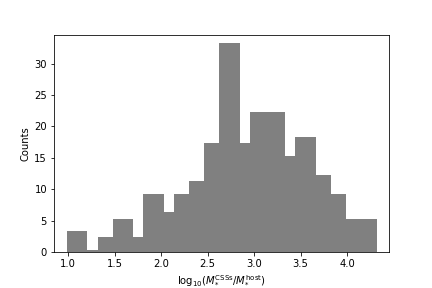

In [4]:
plt.figure()

plt.hist(np.log10(np.array(mass_ratio)[np.array(mass_ratio) > 10]), bins=20, edgecolor='grey', facecolor='grey', linewidth=5, histtype='stepfilled')

plt.ylabel('Counts')
plt.xlabel(r'$\mathrm{log}_{10}(M_{*}^{\mathrm{CSSs}}/M_{*}^{\mathrm{host}})$')

plt.savefig('/home/bianyuan/workspace/pic/mass_ratio_CSSs_host.pdf')